# Neutropenia, Insomnia 부작용 분석

**Neutropenia**
```
ICD-9  : 288.0/288.00/288.01/288.02/288.03/288.04/288.09
ICD-10 : D70
```

**Insomnia**
```
ICD-9  : 307.41/327.01/327.02/327.09/780.52
ICD-10 : F51.0/F51.5
```

## 라이브러리 및 함수 

In [ ]:
import pyPheWAS
import pandas as pd
import numpy as np
import os
import os.path as osp
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import statsmodels.discrete.discrete_model as sm
import statsmodels.formula.api as smf

from tqdm import tqdm
from PIL import Image
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def barchart(data, x, y, figsize=(6, 6), margin=10, vertical=False, ratio=False, color='#87CEFA', palette=''):
    sns.set(font_scale = 1.2, rc={'figure.figsize':figsize, "axes.unicode_minus":False}, style='whitegrid', font="NanumBarunGothic")
    
    if palette:
        ax = sns.barplot(x=x, y=y, data=data, palette=palette)
    else:
        ax = sns.barplot(x=x, y=y, data=data, color=color)
    
    if vertical:
        for p in ax.patches:
            x = p.get_x()
            width = p.get_width()
            height = p.get_height()
            if ratio:
                ax.text(x + width / 2., height + margin, height, ha='center', size=12)
            else:
                ax.text(x + width / 2., height + margin, format(round(height), ','), ha='center', size=12)
    else:
        initialx=0
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            if ratio:
                ax.text(width + 1, initialx + height / 8, width, size=13)
            else:
                ax.text(width + 1, initialx + height / 8, format(round(width), ','), size=13)
            initialx+=1

    sns.despine(left=True, bottom=True)
    # plt.legend(['비다약제', '다약제'])
    # plt.xlabel('Patient Sex')
    # ax.set_xticklabels(['남성', '여성'])
    # plt.ylabel('Number of unique AE reports', size=14, labelpad=25)
    # plt.ylim([0, 250000])
    plt.show()

In [ ]:
def reports_by_drug_taking(drug, phenotype):
    d_Y = set(ua[ua['ACTIVE_DRUG_INGREDIENT']==drug]['KD_NO'])
    d_N = set(ua[ua['ACTIVE_DRUG_INGREDIENT']!=drug]['KD_NO']) - d_Y
    a_Y = set(ua[ua['Phenotype']==phenotype]['KD_NO'])
    a_N = set(ua[ua['Phenotype']!=phenotype]['KD_NO']) - a_Y
    print(drug, '복용한 사람 수 :', len(d_Y))
    print(drug, '복용하지 않은 사람 수 :', len(d_N))
    print(phenotype, '보고한 사람 수 :', len(a_Y))
    print(phenotype, '보고하지 않은 사람 수 :', len(a_N))
    print()
    
    print('약물', drug, '복용하고', phenotype, '부작용을 보고한 KD_NO 개수')
    d_Y_a_Y = set(ua[(ua['ACTIVE_DRUG_INGREDIENT']==drug) & (ua['Phenotype']==phenotype)]['KD_NO'])
    print(len(d_Y_a_Y))
    print('(', drug, '복용한 사람들 중', round(len(d_Y_a_Y)/len(d_Y)*100, 1), '% ) | (', phenotype, '부작용 보고한 사람들 중', round(len(d_Y_a_Y)/len(a_Y)*100, 2), '% )\n')
    
    print('약물', drug, '복용하지 않고', phenotype, '부작용을 보고한 KD_NO 개수')
    d_N_a_Y = set(ua[(ua['ACTIVE_DRUG_INGREDIENT']!=drug) & (ua['Phenotype']==phenotype)]['KD_NO']) - d_Y_a_Y
    print(len(d_N_a_Y))
    print('(', drug, '복용하지 않은 사람들 중', round(len(d_N_a_Y)/len(d_N)*100, 1), '% ) | (', phenotype, '부작용 보고한 사람들 중', round(len(d_N_a_Y)/len(a_Y)*100, 2), '% )\n')
          
    print('약물', drug, '복용하고 다른 부작용을 보고한 KD_NO 개수')
    d_Y_a_N = set(ua[(ua['ACTIVE_DRUG_INGREDIENT']==drug) & (ua['Phenotype']!=phenotype)]['KD_NO']) - d_Y_a_Y
    print(len(d_Y_a_N))
    print('(', drug, '복용한 사람들 중', round(len(d_Y_a_N)/len(d_Y)*100, 1), '% ) | ( 부작용 보고하지 않은 사람들 중', round(len(d_Y_a_N)/len(a_N)*100, 2), '% )\n')
          
    print('약물', drug, '복용하지 않고 다른 부작용을 보고한 KD_NO 개수')
    d_N_a_N = set(ua[(ua['ACTIVE_DRUG_INGREDIENT']!=drug) & (ua['Phenotype']!=phenotype)]['KD_NO']) - d_Y_a_N - d_N_a_Y - d_Y_a_Y
    print(len(d_N_a_N))
    print('(', drug, '복용하지 않은 사람들 중', round(len(d_N_a_N)/len(d_N)*100, 1), '% ) | ( 부작용 보고하지 않은 사람들 중', round(len(d_N_a_N)/len(a_N)*100, 2), '% )')

In [ ]:
def table_reports_by_drug_taking(drug, phenotype, suspected=False):
    result = pd.DataFrame()
    result['Drug'] = [drug]
    result['Phenotype'] = [phenotype]
    d_Y_p_Y = d_N_p_Y = d_Y_p_N = d_N_p_N = 0
    
    if suspected: # 해당 부작용의 의심약물
        
        # 약물을 복용하고 해당 부작용을 보고한 KD_NO 개수
        d_Y_p_Y = set(ua[(ua['ACTIVE_DRUG_INGREDIENT']==drug) & (ua['Phenotype']==phenotype) & (ua['DOUBT_CMBT_CSF']=='1')]['KD_NO'])
        result['d_Y_p_Y'] = [len(d_Y_p_Y)]

        # 약물을 복용하지 않고 해당 부작용을 보고한 KD_NO 개수
        d_N_p_Y = set(set(ua[(ua['ACTIVE_DRUG_INGREDIENT']!=drug) & (ua['Phenotype']==phenotype) & (ua['DOUBT_CMBT_CSF']=='1')]['KD_NO']) - d_Y_p_Y)
        result['d_N_p_Y'] = [len(d_N_p_Y)]
        
    else: # 해당 부작용의 의심약물 + 병용약물 모두
        
        # 약물을 복용하고 해당 부작용을 보고한 KD_NO 개수
        d_Y_p_Y = set(ua[(ua['ACTIVE_DRUG_INGREDIENT']==drug) & (ua['Phenotype']==phenotype)]['KD_NO'])
        result['d_Y_p_Y'] = [len(d_Y_p_Y)]

        # 약물을 복용하지 않고 해당 부작용을 보고한 KD_NO 개수
        d_N_p_Y = set(set(ua[(ua['ACTIVE_DRUG_INGREDIENT']!=drug) & (ua['Phenotype']==phenotype)]['KD_NO']) - d_Y_p_Y)
        result['d_N_p_Y'] = [len(d_N_p_Y)]
    
          
    # 약물을 복용하고 해당 부작용을 보고하지 않은 KD_NO 개수
    d_Y_p_N = set(set(ua[(ua['ACTIVE_DRUG_INGREDIENT']==drug) & (ua['Phenotype']!=phenotype)]['KD_NO']) - d_Y_p_Y)
    result['d_Y_p_N'] = [len(d_Y_p_N)]
    
    # 약물을 복용하지 않고 해당 부작용을 보고하지 않은 KD_NO 개수
    d_N_p_N = set(set(ua[(ua['ACTIVE_DRUG_INGREDIENT']!=drug) & (ua['Phenotype']!=phenotype)]['KD_NO']) - d_Y_p_Y - d_Y_p_N - d_N_p_Y)
    result['d_N_p_N'] = [len(d_N_p_N)]
    
    return result

In [ ]:
def filtering(drug_list, phenotype, rate=20):
    result = {}
    
    for drug in tqdm(drug_list):
        d_Y = set(ua[ua['ACTIVE_DRUG_INGREDIENT']==drug]['KD_NO'])
        d_Y_a_Y = set(ua[(ua['ACTIVE_DRUG_INGREDIENT']==drug) & (ua['Phenotype']==phenotype)]['KD_NO'])
        
        Y_Y_rate = round(len(d_Y_a_Y)/len(d_Y)*100)
        if Y_Y_rate < rate: continue
        result[drug] = Y_Y_rate
        
    return result

In [ ]:
def drugs_by_reports(df, KD_NO_list):    
    result = pd.DataFrame()
    
    for KD_NO in tqdm(KD_NO_list):
        row = pd.DataFrame()
        row['KD_NO'] = [KD_NO]
        row['phenotype'] = [df.loc[df['KD_NO']==KD_NO, 'Phenotype'].unique()[0]]
        
        susp_drugs = '/'.join(sorted(list(df.loc[(df['KD_NO']==KD_NO) & (df['DOUBT_CMBT_CSF']=='1'), 'ACTIVE_DRUG_INGREDIENT'].dropna().unique())))
        conc_drugs = '/'.join(sorted(list(df.loc[(df['KD_NO']==KD_NO) & (df['DOUBT_CMBT_CSF']=='2'), 'ACTIVE_DRUG_INGREDIENT'].dropna().unique())))

        row['suspected_drug'] = [susp_drugs] if susp_drugs != '' else [np.NaN]
        row['concomitant_drug'] = [conc_drugs] if conc_drugs != '' else [np.NaN]
        
        result = result.append(row)
    
    return result.reset_index(drop=True)

In [ ]:
# Heatmap
def draw_heatmap(data, xlabel, ylabel, 
                 figsize=(30,20), palette='Blues',
                 vmin=0, vmax=1000,
                 isNormalized=False):
    xticklabels = list(data.columns)
    yticklabels = list(data.index)
    
    if isNormalized:
        scaler = MinMaxScaler(feature_range=(0, 1))
        data = scaler.fit_transform(data)
        data = pd.DataFrame(data,
                            index = yticklabels,
                            columns = xticklabels)
    else:
        data = data.astype(int)

    sns.set(font_scale = 1.2, rc={'figure.figsize':figsize})
    sns.heatmap(data, 
                xticklabels=xticklabels, yticklabels=yticklabels,
                annot=True, cmap=palette, 
                fmt=',d', linewidths=1, vmin=vmin, vmax=vmax)

    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.show()

## 데이터 불러오기

In [ ]:
ua = pd.read_csv('KAERS_ADR_DRUG_ING_ICD_v2.tsv', sep='\t', low_memory=False, encoding='latin1')
ua['KD_NO'] = ua['KD_NO'].astype(str)
ua['ICD10_code'] = ua['ICD10_code'].astype(str)
ua['ICD9CM_code'] = ua['ICD9CM_code'].astype(str)
ua['ICD10CM_code '] = ua['ICD10CM_code'].astype(str)
ua['drug_seq'] = ua['drug_seq'].astype(str)
ua['DOUBT_CMBT_CSF'] = ua['DOUBT_CMBT_CSF'].astype(str)
ua

,KD_NO,adr_seq,WHOART_ARRN,WHOART_SEQ,ICD10_code,ICD9CM_code,ICD10CM_code,drug_seq,DRUG_CHEM,WHO_ATC_CD,DSAS_CD,dsas_cd_ver,ACTIVE_DRUG_INGREDIENT,Phenotype,DOUBT_CMBT_CSF,ICD10CM_code
0,724,1,27,1.0,nan,nan,NaN,1,dextran,B05AA05,NaN,NaN,dextran,NaN,1,nan
1,724,2,514,1.0,R06.0,786.05,R06.0,1,dextran,B05AA05,NaN,NaN,dextran,NaN,1,R06.0
2,724,2,514,1.0,R06.0,786.05,R06.00,1,dextran,B05AA05,NaN,NaN,dextran,NaN,1,R06.00
3,724,2,514,1.0,R06.0,786.05,R06.02,1,dextran,B05AA05,NaN,NaN,dextran,NaN,1,R06.02
4,834,1,308,1.0,nan,nan,R11.0,1,fluorouracil,L01BC02,C18.7,7.0,fluorouracil,NaN,1,R11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180048,1261766395,1,308,1.0,nan,nan,R11.0,1,fentanyl,N01AH01,R52.0,7.0,fentanyl,NaN,1,R11.0
4180049,1261797044,1,308,1.0,nan,nan,R11.0,1,fentanyl,N01AH01,R52.0,7.0,fentanyl,NaN,1,R11.0
4180050,1261871208,1,228,1.0,nan,nan,R11.1,1,lactulose,A06AD11,K59.0,7.0,lactulose,NaN,1,R11.1
4180051,1261871208,1,228,1.0,nan,nan,R11.10,1,lactulose,A06AD11,K59.0,7.0,lactulose,NaN,1,R11.10


In [ ]:
ua.nunique()

KD_NO                     641266
adr_seq                       50
WHOART_ARRN                 2133
WHOART_SEQ                    30
ICD10_code                   638
ICD9CM_code                  676
ICD10CM_code                1035
drug_seq                     117
DRUG_CHEM                   1894
WHO_ATC_CD                  2041
DSAS_CD                     6603
dsas_cd_ver                    3
ACTIVE_DRUG_INGREDIENT      1446
Phenotype                      2
DOUBT_CMBT_CSF                 3
ICD10CM_code                1036
dtype: int64

## 두 가지 부작용에 연결된 약물

### Neutropenia

In [ ]:
df_neu = ua.loc[ua['KD_NO'].isin(neu_id) & (ua['ICD9CM_code'].isin(neu_icd) | ua['ICD10CM_code'].isin(neu_icd) | ua['ICD10_code'].isin(neu_icd))].drop_duplicates().reset_index(drop=True)
df_neu = pd.merge(df_neu, group, left_on='KD_NO', right_on='id', how='left').drop('id', axis=1)
df_neu = df_neu.dropna(subset=['ACTIVE_DRUG_INGREDIENT'])
df_neu['DOUBT_CMBT_CSF'] = df_neu['DOUBT_CMBT_CSF'].astype(str) 
df_neu

,KD_NO,adr_seq,WHOART_ARRN,WHOART_SEQ,ICD10_code,ICD9CM_code,ICD10CM_code,drug_seq,DRUG_CHEM,WHO_ATC_CD,DSAS_CD,dsas_cd_ver,ACTIVE_DRUG_INGREDIENT,Phenotype,DOUBT_CMBT_CSF,ICD10CM_code,response,MaxAgeAtVisit,other_covariates(PatientSex_1=male_2=female)
0,9018,3,572,3.0,nan,288.0,D70,1,lansoprazole,A02BC03,NaN,NaN,lansoprazole,Neutropenia,2,D70,1,63,2
1,9018,3,572,3.0,nan,288.0,D70.9,1,lansoprazole,A02BC03,NaN,NaN,lansoprazole,Neutropenia,2,D70.9,1,63,2
2,9018,3,572,3.0,nan,288.00,D70,1,lansoprazole,A02BC03,NaN,NaN,lansoprazole,Neutropenia,2,D70,1,63,2
3,9018,3,572,3.0,nan,288.00,D70.9,1,lansoprazole,A02BC03,NaN,NaN,lansoprazole,Neutropenia,2,D70.9,1,63,2
4,9018,3,572,3.0,nan,288.0,D70,2,acetylsalicylic acid,B01AC06,NaN,NaN,acetylsalicylic acid,Neutropenia,2,D70,1,63,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150290,1260798126,1,572,3.0,nan,288.00,D70.9,6,tigecycline,J01AA12,L03,7.0,tigecycline,Neutropenia,1,D70.9,1,68,1
150291,1260798126,1,572,3.0,nan,288.0,D70,7,zolpidem,N05CF02,NaN,NaN,zolpidem,Neutropenia,2,D70,1,68,1
150292,1260798126,1,572,3.0,nan,288.0,D70.9,7,zolpidem,N05CF02,NaN,NaN,zolpidem,Neutropenia,2,D70.9,1,68,1
150293,1260798126,1,572,3.0,nan,288.00,D70,7,zolpidem,N05CF02,NaN,NaN,zolpidem,Neutropenia,2,D70,1,68,1


In [ ]:
df_neu.nunique()

KD_NO                                           10404
adr_seq                                            14
WHOART_ARRN                                         5
WHOART_SEQ                                          2
ICD10_code                                          2
ICD9CM_code                                         3
ICD10CM_code                                        2
drug_seq                                           58
DRUG_CHEM                                         732
WHO_ATC_CD                                        770
DSAS_CD                                           962
dsas_cd_ver                                         2
ACTIVE_DRUG_INGREDIENT                            688
Phenotype                                           1
DOUBT_CMBT_CSF                                      2
ICD10CM_code                                        2
response                                            2
MaxAgeAtVisit                                      92
other_covariates(PatientSex_

#### ATC 분석

In [ ]:
neu_drug = df_neu[['ACTIVE_DRUG_INGREDIENT','WHO_ATC_CD']].drop_duplicates().reset_index(drop=True)
neu_drug

,ACTIVE_DRUG_INGREDIENT,WHO_ATC_CD
0,lansoprazole,A02BC03
1,acetylsalicylic acid,B01AC06
2,dexamethasone,H02AB02
3,carfilzomib,L01XG02
4,lenalidomide,L04AX04
...,...,...
821,cefpiramide,J01DD11
822,oxytetracycline,D06AA03
823,ceftezole,J01DB12
824,pentazocine,N02AD01


In [ ]:
neu_drug['1'] = neu_drug['WHO_ATC_CD'].apply(lambda x: x[0])
neu_drug['2'] = neu_drug['WHO_ATC_CD'].apply(lambda x: x[1:3])
neu_drug['3'] = neu_drug['WHO_ATC_CD'].apply(lambda x: x[3] if len(x) > 3 else np.NaN)
neu_drug['4'] = neu_drug['WHO_ATC_CD'].apply(lambda x: x[4] if len(x) > 4 else np.NaN)
neu_drug['5'] = neu_drug['WHO_ATC_CD'].apply(lambda x: x[5:] if len(x) > 5 else np.NaN)

In [ ]:
neu_drug

,ACTIVE_DRUG_INGREDIENT,WHO_ATC_CD,1,2,3,4,5
0,lansoprazole,A02BC03,A,02,B,C,03
1,acetylsalicylic acid,B01AC06,B,01,A,C,06
2,dexamethasone,H02AB02,H,02,A,B,02
3,carfilzomib,L01XG02,L,01,X,G,02
4,lenalidomide,L04AX04,L,04,A,X,04
...,...,...,...,...,...,...,...
821,cefpiramide,J01DD11,J,01,D,D,11
822,oxytetracycline,D06AA03,D,06,A,A,03
823,ceftezole,J01DB12,J,01,D,B,12
824,pentazocine,N02AD01,N,02,A,D,01


In [ ]:
neu_drug.nunique()

ACTIVE_DRUG_INGREDIENT    688
WHO_ATC_CD                770
1                          14
2                          13
3                          12
4                          16
5                          47
dtype: int64

In [ ]:
neu_drug.isnull().sum()

ACTIVE_DRUG_INGREDIENT    0
WHO_ATC_CD                0
1                         0
2                         0
3                         0
4                         0
5                         0
dtype: int64

In [ ]:
neu_drug_atc1 = neu_drug.groupby('1').count()
neu_drug_atc1['Percent'] = neu_drug_atc1['ACTIVE_DRUG_INGREDIENT'].apply(lambda x: x/826*100)
neu_drug_atc1 = neu_drug_atc1[['ACTIVE_DRUG_INGREDIENT','Percent']].reset_index()\
        .rename(columns={'1':'ATC Class','ACTIVE_DRUG_INGREDIENT':'ACTIVE_DRUG_INGREDIENT Count'})
neu_drug_atc1

,ATC Class,ACTIVE_DRUG_INGREDIENT Count,Percent
0,A,131,15.859564
1,B,50,6.053269
2,C,89,10.774818
3,D,31,3.753027
4,G,16,1.937046
5,H,17,2.058111
6,J,134,16.222760
7,L,129,15.617433
8,M,39,4.721550
9,N,96,11.622276


In [ ]:
neu_drug_atc1['Percent'].sum()

99.99999999999997

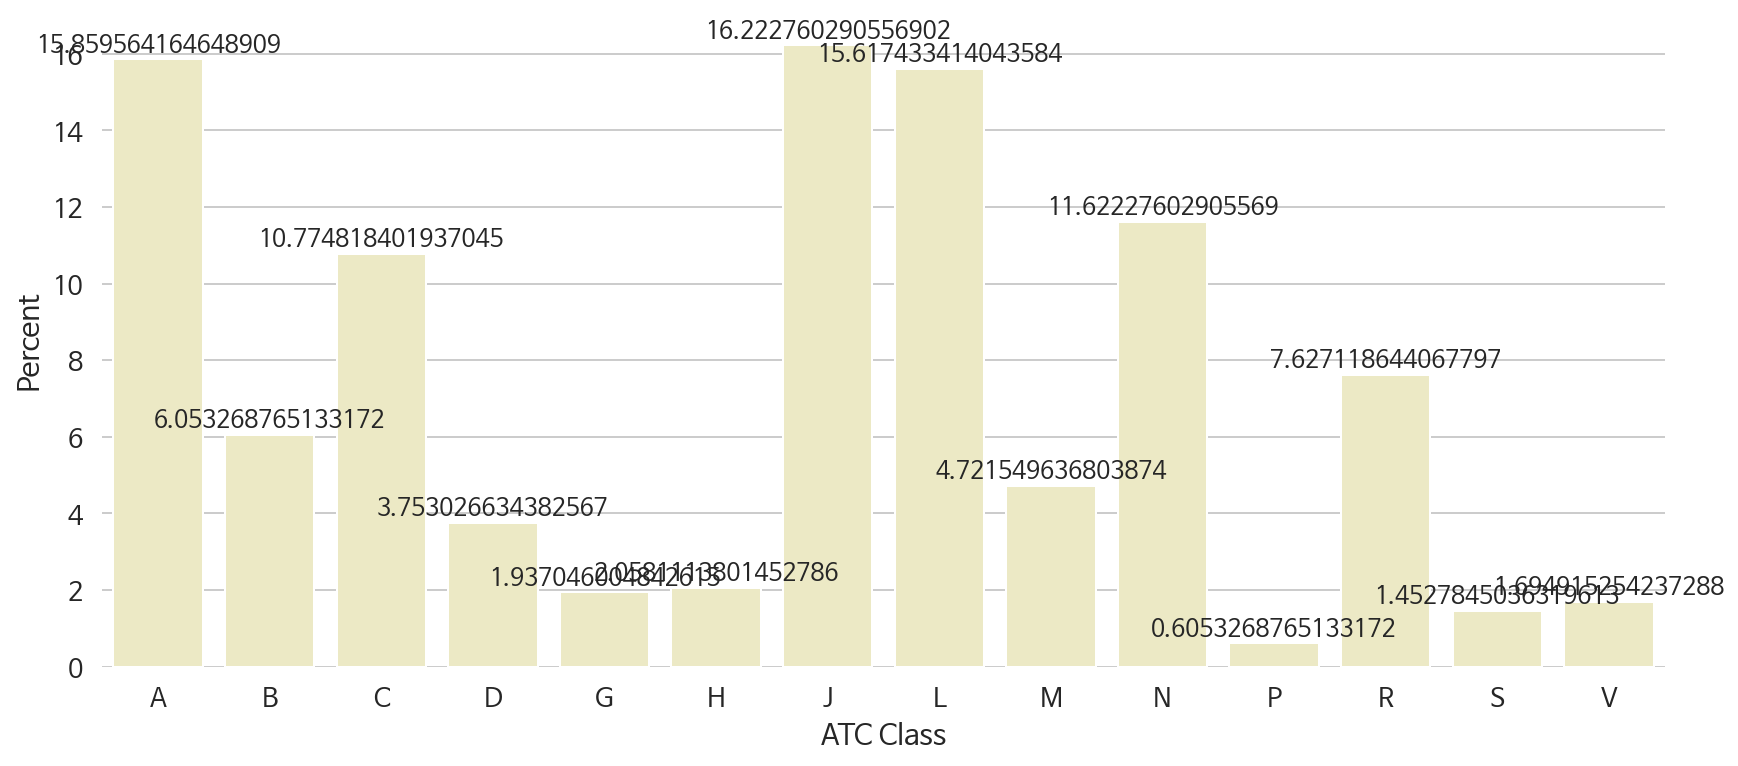

In [ ]:
barchart(data=neu_drug_atc1,
         x='ATC Class',
         y='Percent',
         figsize=(14, 6),
         color='#F2EEBF',
         margin=0.2,
         vertical=True,
         ratio=True)

In [ ]:
neu_drug_atc1['color'] = sns.color_palette('Pastel1')[:8] + sns.color_palette('Pastel2')[:6]
neu_drug_atc1_sort = neu_drug_atc1.sort_values(by='Percent', ascending=False).reset_index(drop=True)
neu_drug_atc1_sort

,ATC Class,ACTIVE_DRUG_INGREDIENT Count,Percent,color
0,J,134,16.222760,"(0.8980392156862745, 0.8470588235294118, 0.741..."
1,A,131,15.859564,"(0.984313725490196, 0.7058823529411765, 0.6823..."
2,L,129,15.617433,"(0.9921568627450981, 0.8549019607843137, 0.925..."
3,N,96,11.622276,"(0.9921568627450981, 0.803921568627451, 0.6745..."
4,C,89,10.774818,"(0.8, 0.9215686274509803, 0.7725490196078432)"
5,R,63,7.627119,"(0.9568627450980393, 0.792156862745098, 0.8941..."
6,B,50,6.053269,"(0.7019607843137254, 0.803921568627451, 0.8901..."
7,M,39,4.721550,"(0.7019607843137254, 0.8862745098039215, 0.803..."
8,D,31,3.753027,"(0.8705882352941177, 0.796078431372549, 0.8941..."
9,H,17,2.058111,"(1.0, 1.0, 0.8)"


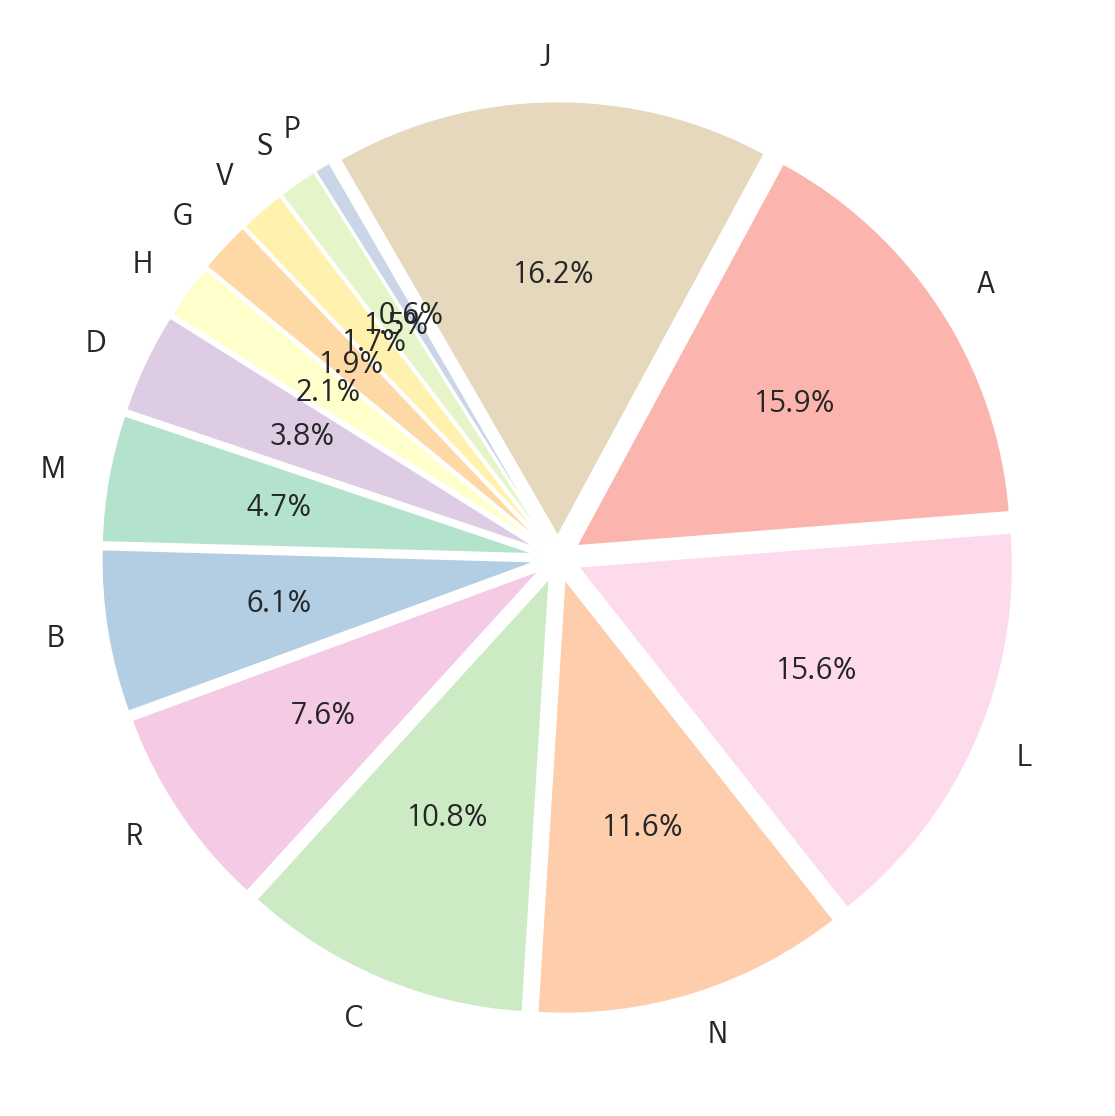

In [ ]:
data = neu_drug_atc1_sort['Percent'].to_list()
labels = neu_drug_atc1_sort['ATC Class'].to_list()
explode = [0.05] * 14
colors = neu_drug_atc1_sort['color'].to_list()
plt.figure(figsize=(10,10))
plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%', textprops={'fontsize': 14},
        explode=explode, startangle=120, counterclock=False)
plt.show()

#### 전체 ATC 분포와 비교 분석

In [ ]:
all_drug = ua[['ACTIVE_DRUG_INGREDIENT','WHO_ATC_CD']].drop_duplicates()
all_drug = all_drug.dropna().reset_index(drop=True)
all_drug.iloc[1809]['WHO_ATC_CD'] = 'V08AB05'   ### 나중에 지워도 됨
all_drug

,ACTIVE_DRUG_INGREDIENT,WHO_ATC_CD
0,dextran,B05AA05
1,fluorouracil,L01BC02
2,oxaliplatin,L01XA03
3,triamcinolone,H02AB08
4,botulinum toxin,M03AX01
...,...,...
1900,hexoprenaline,R03CC05
1901,oxaprozin,M01AE12
1902,bromperidol,N05AD06
1903,hetacillin,J01CA18


In [ ]:
all_drug['1'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[0])
all_drug['2'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[1:3])
all_drug['3'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[3] if len(x) > 3 else np.NaN)
all_drug['4'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[4] if len(x) > 4 else np.NaN)
all_drug['5'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[5:] if len(x) > 5 else np.NaN)

In [ ]:
all_drug

,ACTIVE_DRUG_INGREDIENT,WHO_ATC_CD,1,2,3,4,5
0,dextran,B05AA05,B,05,A,A,05
1,fluorouracil,L01BC02,L,01,B,C,02
2,oxaliplatin,L01XA03,L,01,X,A,03
3,triamcinolone,H02AB08,H,02,A,B,08
4,botulinum toxin,M03AX01,M,03,A,X,01
...,...,...,...,...,...,...,...
1900,hexoprenaline,R03CC05,R,03,C,C,05
1901,oxaprozin,M01AE12,M,01,A,E,12
1902,bromperidol,N05AD06,N,05,A,D,06
1903,hetacillin,J01CA18,J,01,C,A,18


In [ ]:
all_drug.nunique()

ACTIVE_DRUG_INGREDIENT    1447
WHO_ATC_CD                1758
1                           14
2                           14
3                           15
4                           18
5                           54
dtype: int64

In [ ]:
all_drug.isnull().sum()

ACTIVE_DRUG_INGREDIENT    0
WHO_ATC_CD                0
1                         0
2                         0
3                         0
4                         0
5                         0
dtype: int64

In [ ]:
all_drug_atc1 = all_drug.groupby('1').count()
all_drug_atc1['Percent'] = all_drug_atc1['ACTIVE_DRUG_INGREDIENT'].apply(lambda x: x/1905*100)
all_drug_atc1 = all_drug_atc1[['ACTIVE_DRUG_INGREDIENT','Percent']].reset_index()\
        .rename(columns={'1':'ATC Class','ACTIVE_DRUG_INGREDIENT':'ACTIVE_DRUG_INGREDIENT Count'})
all_drug_atc1

,ATC Class,ACTIVE_DRUG_INGREDIENT Count,Percent
0,A,277,14.540682
1,B,112,5.879265
2,C,208,10.918635
3,D,105,5.511811
4,G,93,4.881890
5,H,35,1.837270
6,J,277,14.540682
7,L,198,10.393701
8,M,91,4.776903
9,N,204,10.708661


In [ ]:
all_drug_atc1['Percent'].sum()

99.99999999999999

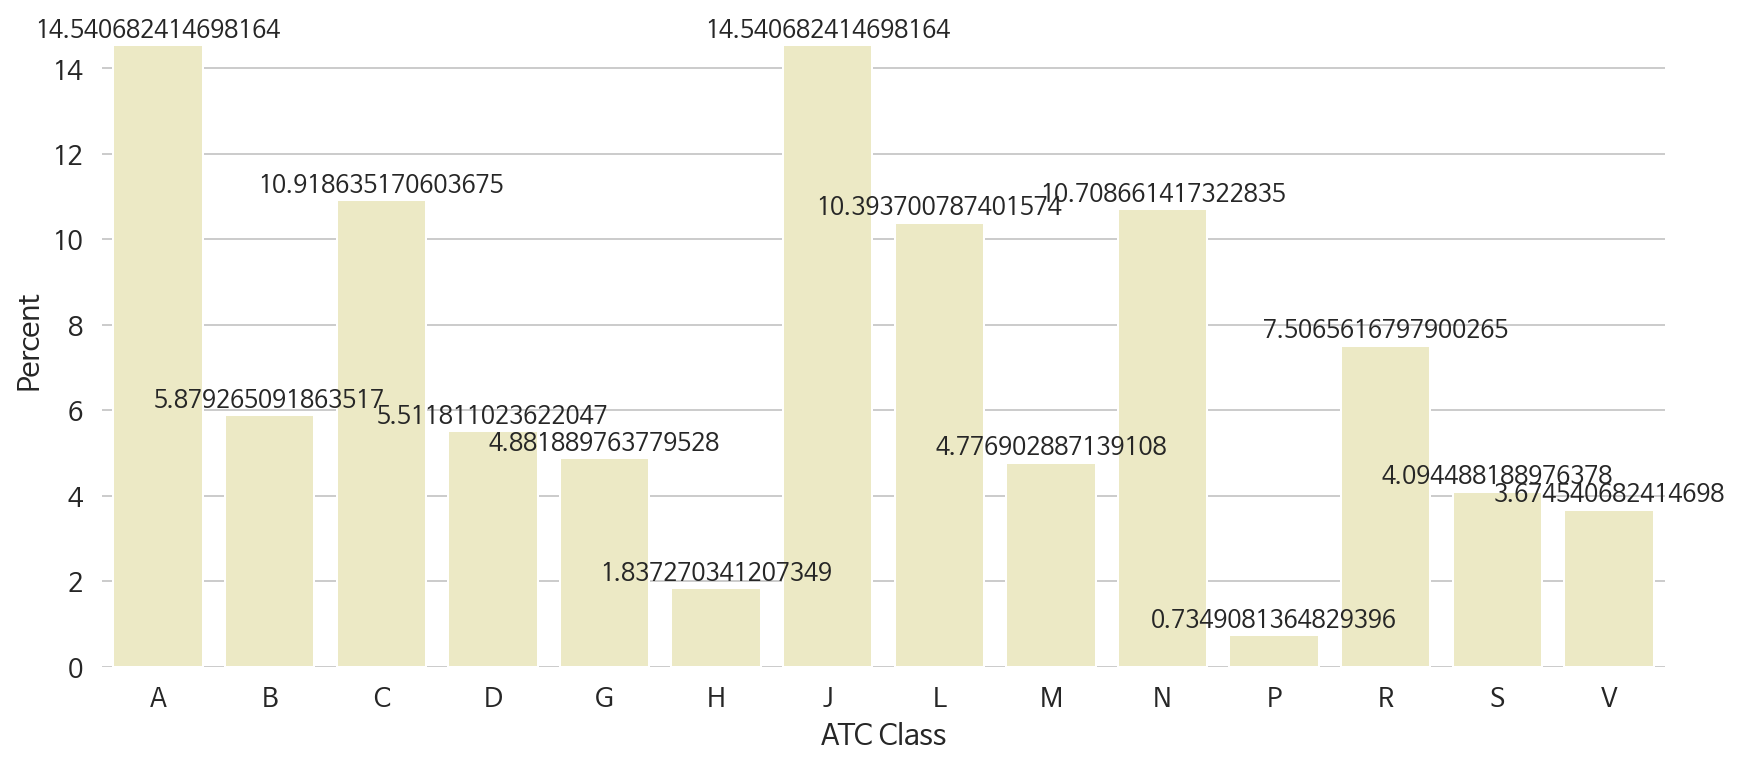

In [ ]:
barchart(data=all_drug_atc1,
         x='ATC Class',
         y='Percent',
         figsize=(14, 6),
         color='#F2EEBF',
         margin=0.2,
         vertical=True,
         ratio=True)

In [ ]:
all_drug_atc1['color'] = sns.color_palette('Pastel1')[:8] + sns.color_palette('Pastel2')[:6]
all_drug_atc1_sort = all_drug_atc1.sort_values(by='Percent', ascending=False).reset_index(drop=True)
all_drug_atc1_sort

,ATC Class,ACTIVE_DRUG_INGREDIENT Count,Percent,color
0,A,277,14.540682,"(0.984313725490196, 0.7058823529411765, 0.6823..."
1,J,277,14.540682,"(0.8980392156862745, 0.8470588235294118, 0.741..."
2,C,208,10.918635,"(0.8, 0.9215686274509803, 0.7725490196078432)"
3,N,204,10.708661,"(0.9921568627450981, 0.803921568627451, 0.6745..."
4,L,198,10.393701,"(0.9921568627450981, 0.8549019607843137, 0.925..."
5,R,143,7.506562,"(0.9568627450980393, 0.792156862745098, 0.8941..."
6,B,112,5.879265,"(0.7019607843137254, 0.803921568627451, 0.8901..."
7,D,105,5.511811,"(0.8705882352941177, 0.796078431372549, 0.8941..."
8,G,93,4.881890,"(0.996078431372549, 0.8509803921568627, 0.6509..."
9,M,91,4.776903,"(0.7019607843137254, 0.8862745098039215, 0.803..."


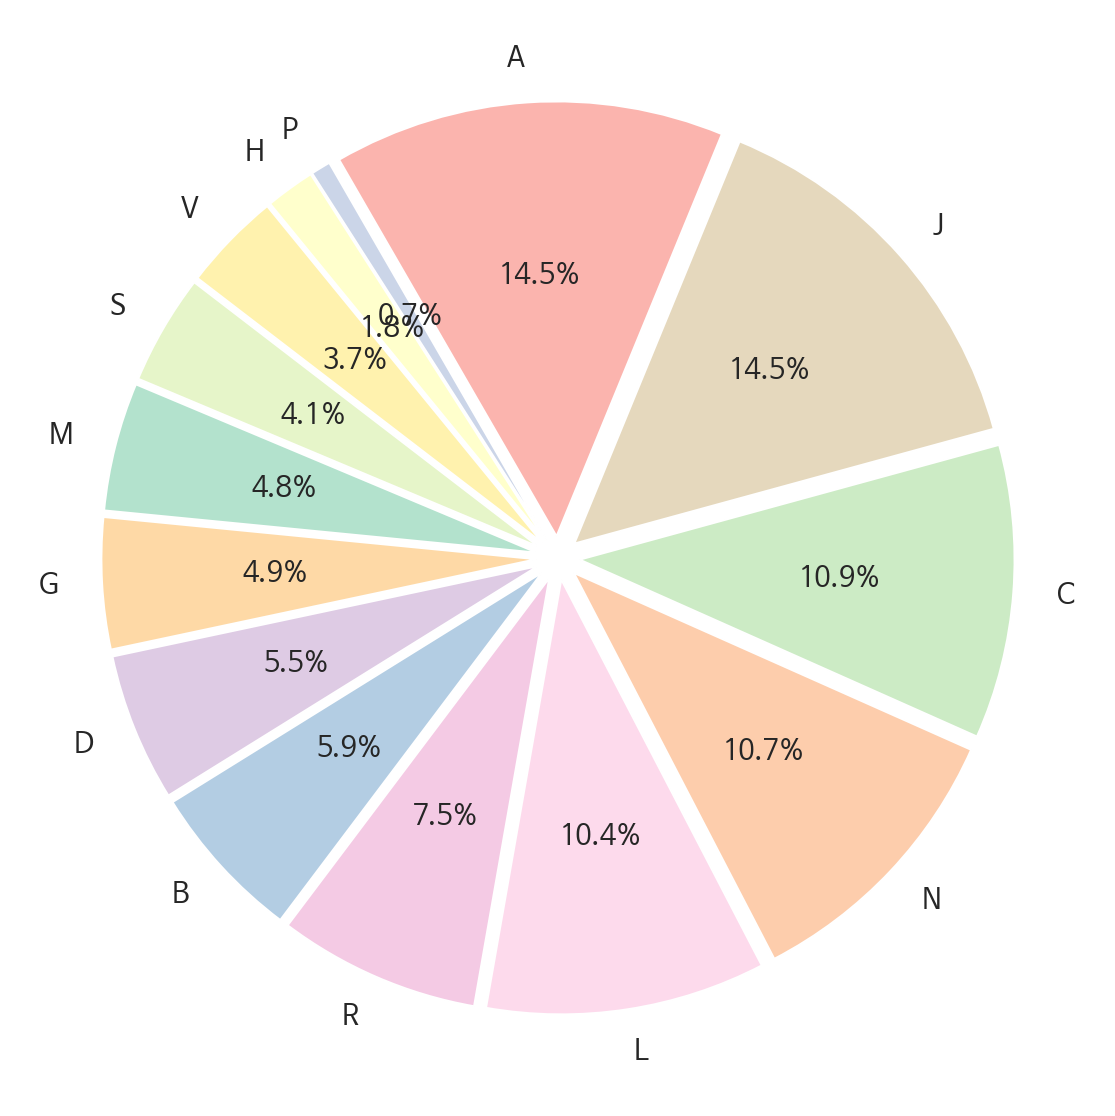

In [ ]:
data = all_drug_atc1_sort['Percent'].to_list()
labels = all_drug_atc1_sort['ATC Class'].to_list()
explode = [0.05] * 14
colors = all_drug_atc1_sort['color'].to_list()
plt.figure(figsize=(10,10))
plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%', textprops={'fontsize': 14},
        explode=explode, startangle=120, counterclock=False)
plt.show()

In [ ]:
na1 = neu_drug_atc1_sort[['ATC Class','ACTIVE_DRUG_INGREDIENT Count']]
na1.columns = ['ATC Class','Neu Count']
na1

,ATC Class,Neu Count
0,J,134
1,A,131
2,L,129
3,N,96
4,C,89
5,R,63
6,B,50
7,M,39
8,D,31
9,H,17


In [ ]:
aa1 = all_drug_atc1[['ATC Class','ACTIVE_DRUG_INGREDIENT Count']]
aa1.columns = ['ATC Class','All Count']
aa1

,ATC Class,All Count
0,A,277
1,B,112
2,C,208
3,D,105
4,G,93
5,H,35
6,J,277
7,L,198
8,M,91
9,N,204


In [ ]:
naa1 = pd.merge(na1, aa1, on='ATC Class', how='inner')
naa1

,ATC Class,Neu Count,All Count
0,J,134,277
1,A,131,277
2,L,129,198
3,N,96,204
4,C,89,208
5,R,63,143
6,B,50,112
7,M,39,91
8,D,31,105
9,H,17,35


In [ ]:
naa1['Percent of All'] = ''

for i in range(14):
    naa1.iloc[i, 3] = round(naa1.iloc[i, 1] / naa1.iloc[i, 2] * 100, 1)
    
naa1

,ATC Class,Neu Count,All Count,Percent of All
0,J,134,277,48.4
1,A,131,277,47.3
2,L,129,198,65.2
3,N,96,204,47.1
4,C,89,208,42.8
5,R,63,143,44.1
6,B,50,112,44.6
7,M,39,91,42.9
8,D,31,105,29.5
9,H,17,35,48.6


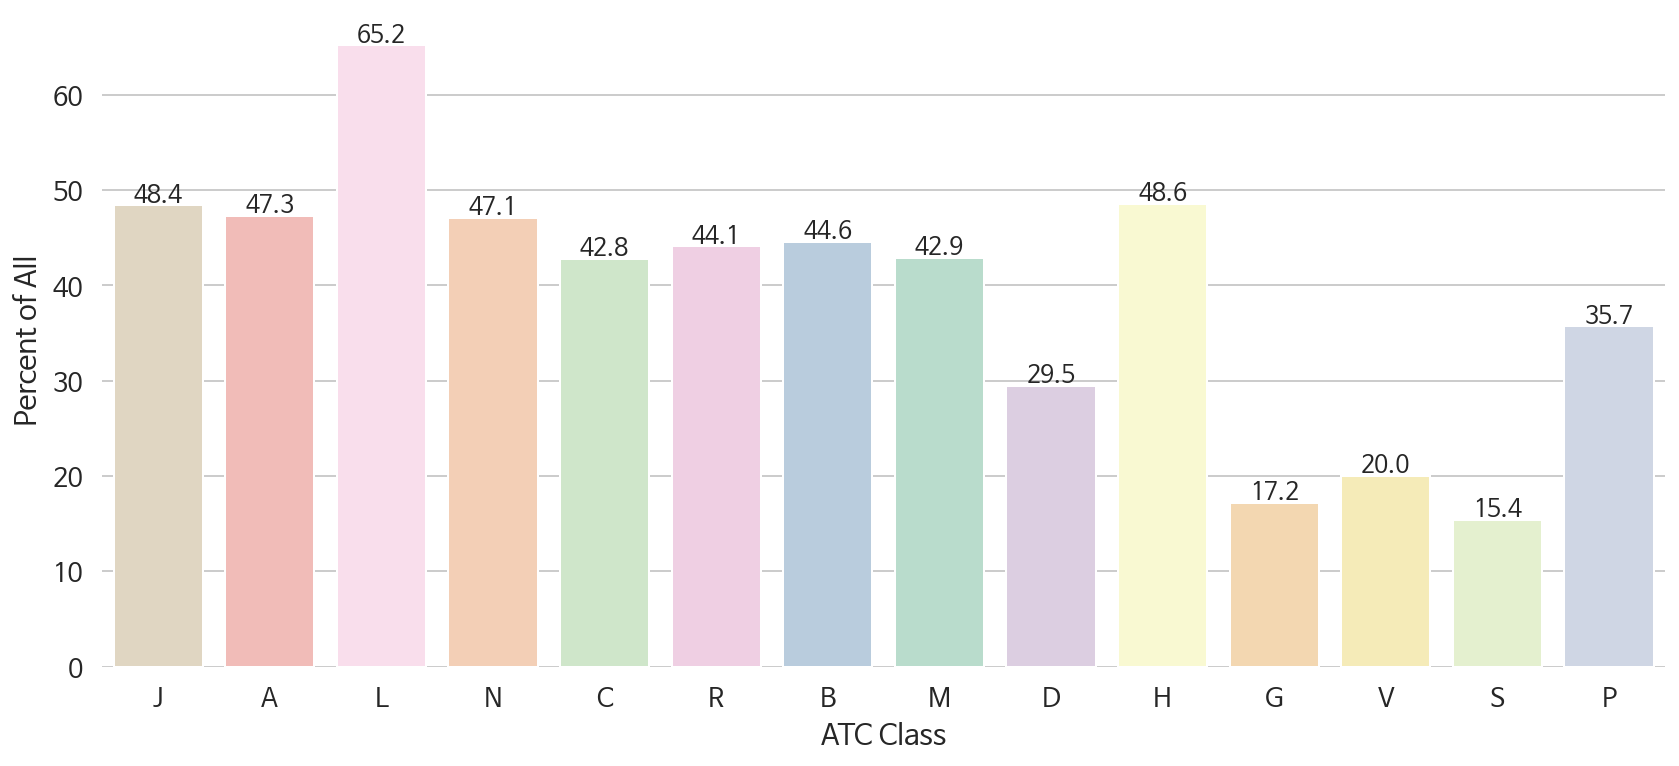

In [ ]:
barchart(data=naa1,
         x='ATC Class',
         y='Percent of All',
         figsize=(14, 6),
         palette=neu_drug_atc1_sort['color'].to_list(),
         margin=0.4,
         vertical=True,
         ratio=True)

In [ ]:
all_drug

,ACTIVE_DRUG_INGREDIENT,WHO_ATC_CD,1,2,3,4,5
0,dextran,B05AA05,B,05,A,A,05
1,fluorouracil,L01BC02,L,01,B,C,02
2,oxaliplatin,L01XA03,L,01,X,A,03
3,triamcinolone,H02AB08,H,02,A,B,08
4,botulinum toxin,M03AX01,M,03,A,X,01
...,...,...,...,...,...,...,...
1900,hexoprenaline,R03CC05,R,03,C,C,05
1901,oxaprozin,M01AE12,M,01,A,E,12
1902,bromperidol,N05AD06,N,05,A,D,06
1903,hetacillin,J01CA18,J,01,C,A,18


In [ ]:
all_drug = ua[['DRUG_CHEM','WHO_ATC_CD']].drop_duplicates()
all_drug = all_drug.dropna().reset_index(drop=True)
all_drug.drop(all_drug[all_drug['WHO_ATC_CD']=='99999'].index, inplace=True)
all_drug

,DRUG_CHEM,WHO_ATC_CD
0,dextran,B05AA05
1,fluorouracil,L01BC02
2,oxaliplatin,L01XA03
3,triamcinolone,H02AB08
4,botulinum toxin,M03AX01
...,...,...
2043,bromperidol,N05AD06
2044,hetacillin,J01CA18
2045,Methyldopa,C02AB
2046,URINE TESTS,V04B


In [ ]:
all_drug['1'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[0])
all_drug['2'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[1:3])
all_drug['3'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[3] if len(x) > 3 else np.NaN)
all_drug['4'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[4] if len(x) > 4 else np.NaN)
all_drug['5'] = all_drug['WHO_ATC_CD'].apply(lambda x: x[5:] if len(x) > 5 else np.NaN)
all_drug

,DRUG_CHEM,WHO_ATC_CD,1,2,3,4,5
0,dextran,B05AA05,B,05,A,A,05
1,fluorouracil,L01BC02,L,01,B,C,02
2,oxaliplatin,L01XA03,L,01,X,A,03
3,triamcinolone,H02AB08,H,02,A,B,08
4,botulinum toxin,M03AX01,M,03,A,X,01
...,...,...,...,...,...,...,...
2043,bromperidol,N05AD06,N,05,A,D,06
2044,hetacillin,J01CA18,J,01,C,A,18
2045,Methyldopa,C02AB,C,02,A,B,NaN
2046,URINE TESTS,V04B,V,04,B,NaN,NaN


In [ ]:
all_drug_atc1 = all_drug.groupby('1').count()
all_drug_atc1['Percent'] = all_drug_atc1['DRUG_CHEM'].apply(lambda x: x/2047*100)
all_drug_atc1 = all_drug_atc1[['DRUG_CHEM','Percent']].reset_index()\
        .rename(columns={'1':'ATC Class','ACTIVE_DRUG_INGREDIENT':'ACTIVE_DRUG_INGREDIENT Count'})
all_drug_atc1

,ATC Class,DRUG_CHEM,Percent
0,A,338,16.511969
1,B,126,6.155349
2,C,209,10.210064
3,D,124,6.057645
4,G,98,4.787494
5,H,37,1.807523
6,J,254,12.408403
7,L,212,10.356619
8,M,97,4.738642
9,N,214,10.454323


In [ ]:
all_drug_atc1.drop([14, 15], inplace=True)
all_drug_atc1

,ATC Class,DRUG_CHEM,Percent
0,A,338,16.511969
1,B,126,6.155349
2,C,209,10.210064
3,D,124,6.057645
4,G,98,4.787494
5,H,37,1.807523
6,J,254,12.408403
7,L,212,10.356619
8,M,97,4.738642
9,N,214,10.454323


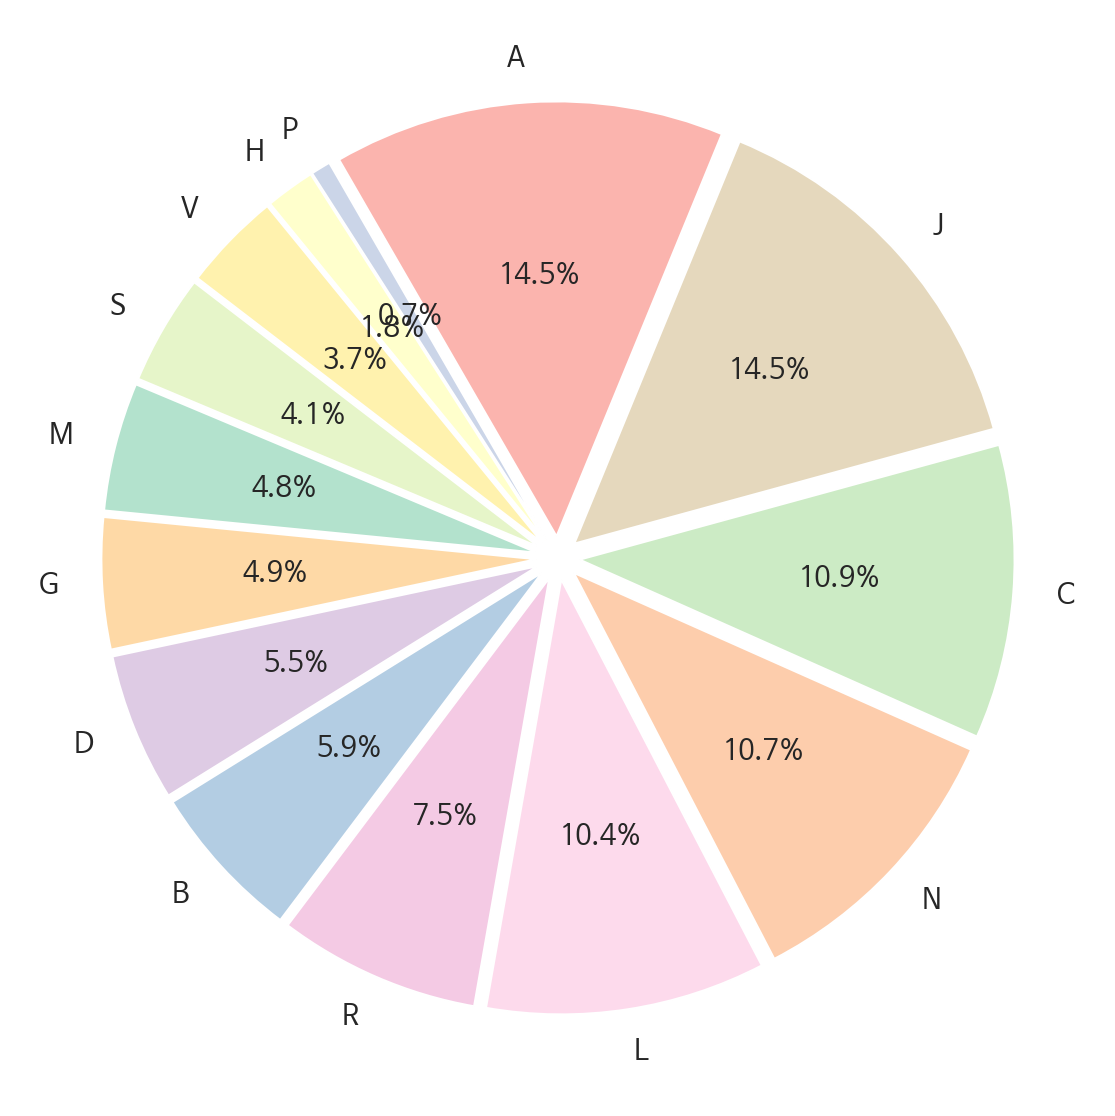

In [ ]:
data = all_drug_atc1_sort['Percent'].to_list()
labels = all_drug_atc1_sort['ATC Class'].to_list()
explode = [0.05] * 14
colors = all_drug_atc1_sort['color'].to_list()
plt.figure(figsize=(10,10))
plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%', textprops={'fontsize': 14},
        explode=explode, startangle=120, counterclock=False)
plt.show()

#### 부작용을 많이 보고한 환자/약물 상위 10개

In [ ]:
neu_id_drug = df_neu[['KD_NO','ACTIVE_DRUG_INGREDIENT','other_covariates(PatientSex_1=male_2=female)']].drop_duplicates().reset_index(drop=True)
neu_id_drug

,KD_NO,ACTIVE_DRUG_INGREDIENT,other_covariates(PatientSex_1=male_2=female)
0,9018,lansoprazole,2
1,9018,acetylsalicylic acid,2
2,9018,dexamethasone,2
3,9018,carfilzomib,2
4,9018,lenalidomide,2
...,...,...,...
33838,1260798126,acetylsalicylic acid,1
33839,1260798126,lercanidipine,1
33840,1260798126,terbinafine,1
33841,1260798126,tigecycline,1


In [ ]:
neu_id_drug.nunique()

KD_NO                                           10404
ACTIVE_DRUG_INGREDIENT                            688
other_covariates(PatientSex_1=male_2=female)        2
dtype: int64

In [ ]:
neu_id_drug['KD_NO'].value_counts()[:20]

88117581     52
140094180    46
98679347     45
31773068     44
480098457    43
587525512    43
74261834     42
40634847     42
91400938     40
229595387    40
73897585     39
217779030    39
212752889    39
89490730     38
254665157    37
40610007     37
220887512    37
181954899    36
28425776     36
98805858     36
Name: KD_NO, dtype: int64

In [ ]:
neu_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts()[:20]

cyclophosphamide            1586
doxorubicin                 1512
fluorouracil                 953
docetaxel                    933
cisplatin                    870
eribulin                     864
dexamethasone                844
paclitaxel                   741
carboplatin                  739
vincristine                  720
filgrastim                   711
pegfilgrastim                608
rituximab                    524
irinotecan                   502
etoposide                    490
aprepitant                   490
metoclopramide               466
paracetamol                  448
gemcitabine                  442
beta-lactamase inhibitor     420
Name: ACTIVE_DRUG_INGREDIENT, dtype: int64

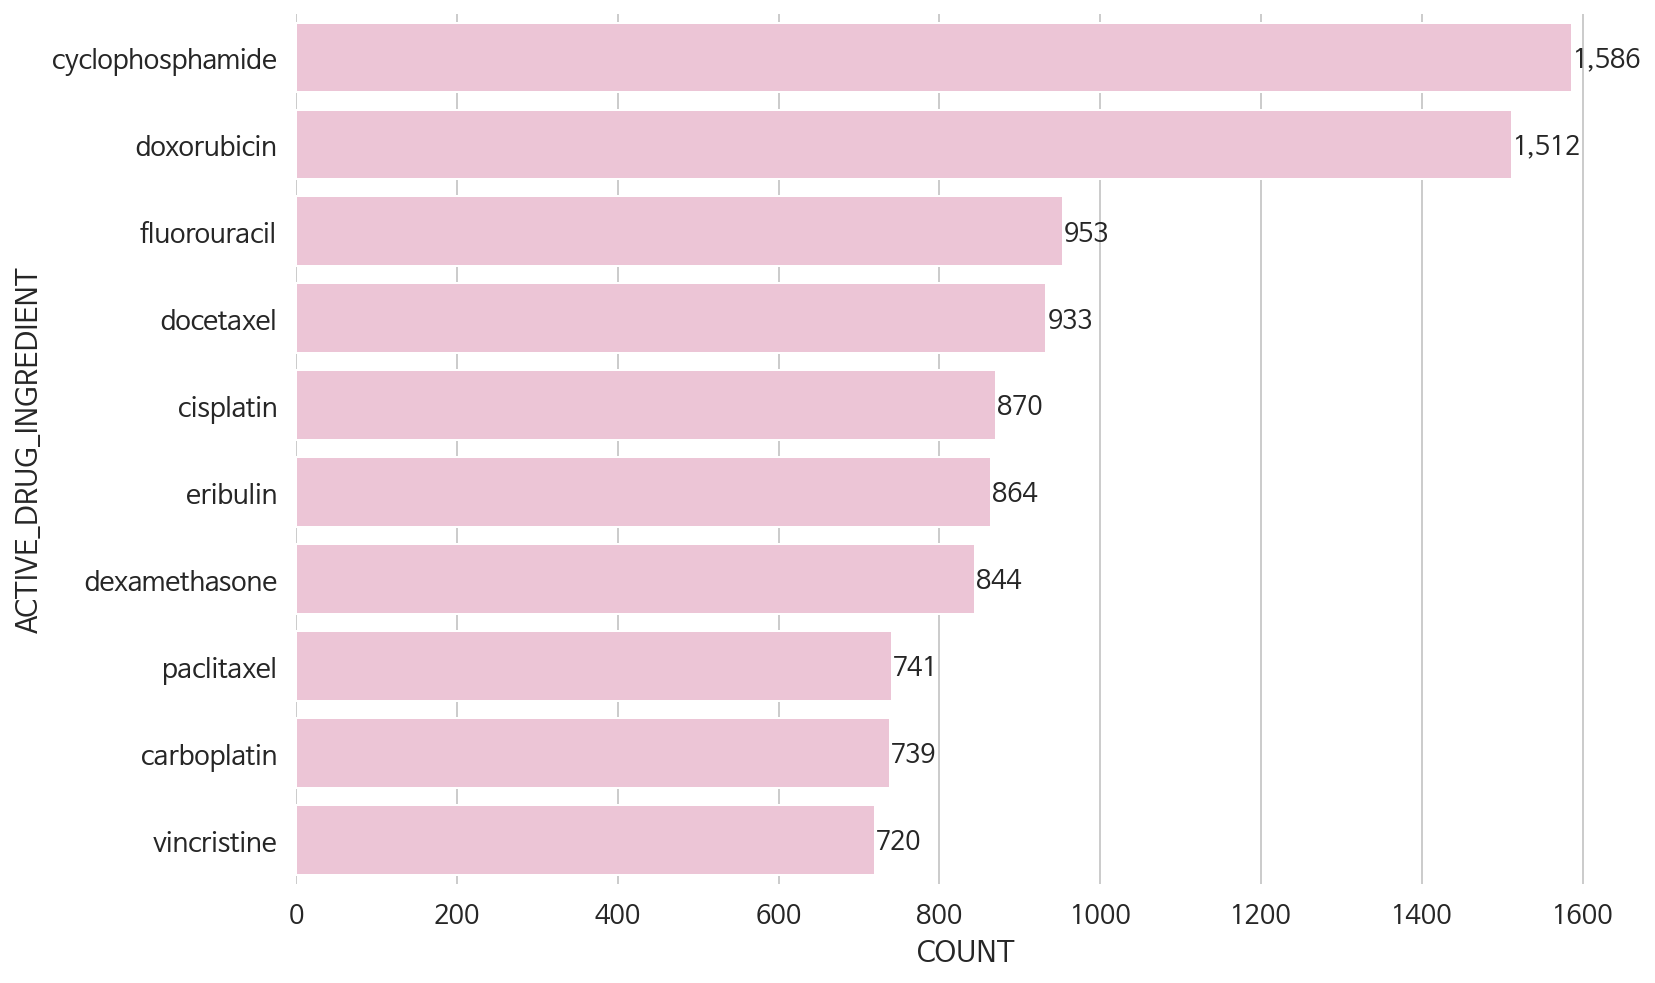

In [ ]:
barchart(data=neu_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts()[:10].to_frame().reset_index().rename(columns={'ACTIVE_DRUG_INGREDIENT':'COUNT','index':'ACTIVE_DRUG_INGREDIENT'}),
         x='COUNT',
         y='ACTIVE_DRUG_INGREDIENT',
         figsize=(12, 8),
         color='#F2BFD5',
         vertical=False)

In [ ]:
neu_id_drug.groupby(['other_covariates(PatientSex_1=male_2=female)']).count()

,KD_NO,ACTIVE_DRUG_INGREDIENT
other_covariates(PatientSex_1=male_2=female),,
1,12548,12548
2,21295,21295


In [ ]:
neu_id_drug[neu_id_drug['other_covariates(PatientSex_1=male_2=female)']==1].nunique()

KD_NO                                           4323
ACTIVE_DRUG_INGREDIENT                           560
other_covariates(PatientSex_1=male_2=female)       1
dtype: int64

In [ ]:
neu_id_drug[neu_id_drug['other_covariates(PatientSex_1=male_2=female)']==2].nunique()

KD_NO                                           6081
ACTIVE_DRUG_INGREDIENT                           584
other_covariates(PatientSex_1=male_2=female)       1
dtype: int64

In [ ]:
round(4323/10404*100, 1), round(6081/10404*100, 1)

(41.6, 58.4)

In [ ]:
neu_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().describe()

count     688.000000
mean       49.190407
std       143.297159
min         1.000000
25%         2.000000
50%         7.000000
75%        30.250000
max      1586.000000
Name: ACTIVE_DRUG_INGREDIENT, dtype: float64

In [ ]:
print('min :', neu_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().min())
print('max :', neu_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().max())
print('mean :', round(neu_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().mean(), 1))
print('median :', neu_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().median())

min : 1
max : 1586
mean : 49.2
median : 7.0


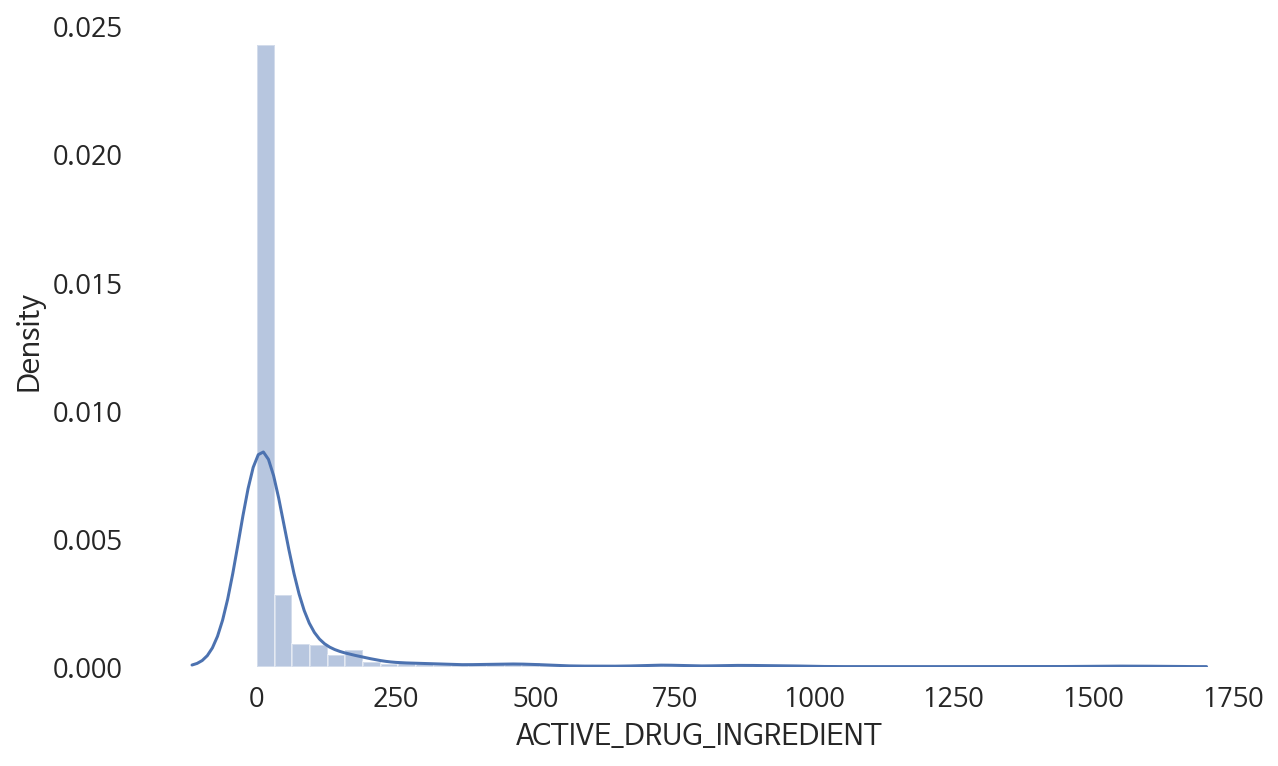

In [ ]:
sns.set(font_scale = 1.2, rc={'figure.figsize':(10, 6), "axes.unicode_minus":False}, style='white', font="NanumBarunGothic")
sns.distplot(neu_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts())
sns.despine(left=True, bottom=True)
plt.show()

#### 약물들과 같이 보고된 약물들 (병용약물)

vincristine 병용약물


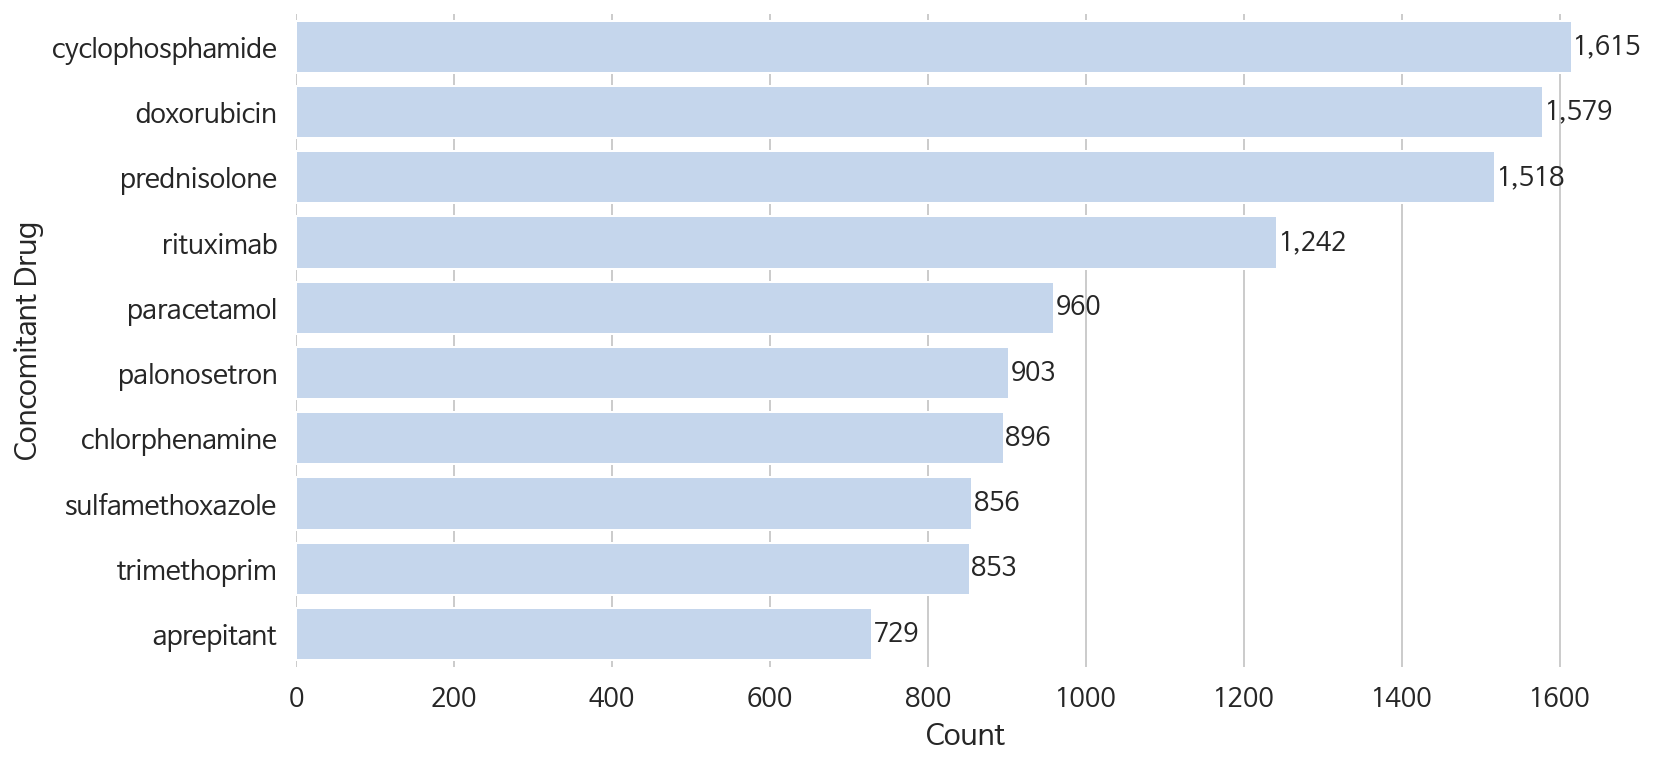

In [ ]:
for drug in neu_drug_10[9:10]:
    print(drug, '병용약물')
    
    ids = list(set(amd[amd['ACTIVE_DRUG_INGREDIENT']==drug]['KD_NO']))
    tmp = amd[amd['KD_NO'].isin(ids) & (amd['DOUBT_CMBT_CSF']==2)][['KD_NO','ACTIVE_DRUG_INGREDIENT']].drop_duplicates().reset_index(drop=True)['ACTIVE_DRUG_INGREDIENT'].value_counts()[:11].to_frame()
    
    if drug in tmp.index:
        tmp = tmp.drop(drug).reset_index().rename(columns={'index':'Concomitant Drug', 'ACTIVE_DRUG_INGREDIENT':'Count'})
    else:
        tmp = tmp.reset_index().drop(10).rename(columns={'index':'Concomitant Drug', 'ACTIVE_DRUG_INGREDIENT':'Count'})
    # display(tmp)
    
    barchart(data=tmp,
             x='Count',
             y='Concomitant Drug',
             figsize=(12, 6),
             margin=100,
             color='#BFD5F2',
             vertical=False)
    # print()

In [ ]:
ua[(ua['ACTIVE_DRUG_INGREDIENT']==drug) & (ua['Phenotype']==phenotype) & (ua['DOUBT_CMBT_CSF']==2)]

,KD_NO,adr_seq,WHOART_ARRN,WHOART_SEQ,ICD10_code,ICD9CM_code,ICD10CM_code,drug_seq,DRUG_CHEM,WHO_ATC_CD,DSAS_CD,dsas_cd_ver,ACTIVE_DRUG_INGREDIENT,Phenotype,DOUBT_CMBT_CSF
241449,31125036,3,572,3.0,NaN,288.0,D70,10,cyclophosphamide,L01AA01,C41.9,7.0,cyclophosphamide,Neutropenia,2
241450,31125036,3,572,3.0,NaN,288.0,D70.9,10,cyclophosphamide,L01AA01,C41.9,7.0,cyclophosphamide,Neutropenia,2
241451,31125036,3,572,3.0,NaN,288.00,D70,10,cyclophosphamide,L01AA01,C41.9,7.0,cyclophosphamide,Neutropenia,2
241452,31125036,3,572,3.0,NaN,288.00,D70.9,10,cyclophosphamide,L01AA01,C41.9,7.0,cyclophosphamide,Neutropenia,2
263617,33207589,1,572,3.0,NaN,288.0,D70,5,cyclophosphamide,L01AA01,C50.9,7.0,cyclophosphamide,Neutropenia,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3938594,739405188,1,572,3.0,NaN,288.00,D70.9,5,cyclophosphamide,L01AA01,C85.9,6.0,cyclophosphamide,Neutropenia,2
4016018,880830907,1,572,3.0,NaN,288.0,D70,3,cyclophosphamide,L01AA01,NaN,NaN,cyclophosphamide,Neutropenia,2
4016019,880830907,1,572,3.0,NaN,288.0,D70.9,3,cyclophosphamide,L01AA01,NaN,NaN,cyclophosphamide,Neutropenia,2
4016020,880830907,1,572,3.0,NaN,288.00,D70,3,cyclophosphamide,L01AA01,NaN,NaN,cyclophosphamide,Neutropenia,2


#### 약물 복용 여부에 따른 2 x 2 매트릭스 확인

In [ ]:
phenotype = 'Neutropenia'

for d in neu_drug_10[:1]:
    print(d)
    reports_by_drug_taking(d, phenotype)
    print()

cyclophosphamide
cyclophosphamide 복용한 사람 수 : 8180
cyclophosphamide 복용하지 않은 사람 수 : 633086
Neutropenia 보고한 사람 수 : 10404
Neutropenia 보고하지 않은 사람 수 : 630862
약물 cyclophosphamide 복용하고 Neutropenia 부작용을 보고한 KD_NO 개수
1586
( cyclophosphamide 복용한 사람들 중 19.4 % ) | ( Neutropenia 부작용 보고한 사람들 중 15.24 % )

약물 cyclophosphamide 복용하지 않고 Neutropenia 부작용을 보고한 KD_NO 개수
8818
( cyclophosphamide 복용하지 않은 사람들 중 1.4 % ) | ( Neutropenia 부작용 보고한 사람들 중 84.76 % )

약물 cyclophosphamide 복용하고 다른 부작용을 보고한 KD_NO 개수
6594
( cyclophosphamide 복용한 사람들 중 80.6 % ) | ( 부작용 보고하지 않은 사람들 중 1.05 % )

약물 cyclophosphamide 복용하지 않고 다른 부작용을 보고한 KD_NO 개수
624268
( cyclophosphamide 복용하지 않은 사람들 중 98.6 % ) | ( 부작용 보고하지 않은 사람들 중 98.95 % )



#### 약물 복용 여부와 부작용 보고 여부 개수 CSV 파일 만들기

In [ ]:
neu_matrix = pd.DataFrame()
neu_drug = list(df_neu['ACTIVE_DRUG_INGREDIENT'].unique())
phenotype = 'Neutropenia'

for drug in tqdm(neu_drug):
    neu_matrix = neu_matrix.append(table_reports_by_drug_taking(drug, phenotype))

100%|██████████| 688/688 [20:43<00:00,  1.81s/it]


In [ ]:
neu_matrix = neu_matrix.reset_index(drop=True)
neu_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
0,lansoprazole,Neutropenia,92,10312,2687,628175
1,acetylsalicylic acid,Neutropenia,88,10316,12891,617971
2,dexamethasone,Neutropenia,844,9560,7110,623752
3,carfilzomib,Neutropenia,38,10366,531,630331
4,lenalidomide,Neutropenia,177,10227,1038,629824
...,...,...,...,...,...,...
683,deferasirox,Neutropenia,3,10401,89,630773
684,cefpiramide,Neutropenia,1,10403,352,630510
685,oxytetracycline,Neutropenia,1,10403,228,630634
686,ceftezole,Neutropenia,1,10403,540,630322


In [ ]:
neu_matrix.sort_values(by='d_Y_p_Y', ascending=False)

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
7,cyclophosphamide,Neutropenia,1586,8818,6594,624268
8,doxorubicin,Neutropenia,1512,8892,6472,624390
37,fluorouracil,Neutropenia,953,9451,11374,619488
62,docetaxel,Neutropenia,933,9471,6296,624566
97,cisplatin,Neutropenia,870,9534,8274,622588
...,...,...,...,...,...,...
430,desloratadine,Neutropenia,1,10403,262,630600
579,iopromide,Neutropenia,1,10403,4016,626846
431,vecuronium,Neutropenia,1,10403,271,630591
577,beclometasone,Neutropenia,1,10403,71,630791


In [ ]:
neu_matrix.to_csv('Neutropenia_count_matrix.csv', index=False)

In [ ]:
# Neutropenia 의심약물만

neu_susp_matrix = pd.DataFrame()
neu_susp_drug = list(df_neu[df_neu['DOUBT_CMBT_CSF']=='1']['ACTIVE_DRUG_INGREDIENT'].unique())
phenotype = 'Neutropenia'

for drug in tqdm(neu_susp_drug):
    neu_susp_matrix = neu_susp_matrix.append(table_reports_by_drug_taking(drug, phenotype))

100%|██████████| 303/303 [09:09<00:00,  1.81s/it]


In [ ]:
neu_susp_matrix = neu_susp_matrix.reset_index(drop=True)
neu_susp_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
0,carfilzomib,Neutropenia,38,10366,531,630331
1,cyclophosphamide,Neutropenia,1586,8818,6594,624268
2,doxorubicin,Neutropenia,1512,8892,6472,624390
3,lenalidomide,Neutropenia,177,10227,1038,629824
4,fluorouracil,Neutropenia,953,9451,11374,619488
...,...,...,...,...,...,...
298,colistin,Neutropenia,3,10401,217,630645
299,celecoxib,Neutropenia,40,10364,5102,625760
300,polycarbophil,Neutropenia,32,10372,624,630238
301,ceftezole,Neutropenia,1,10403,540,630322


In [ ]:
neu_susp_matrix.sort_values(by='d_Y_p_Y', ascending=False)

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
1,cyclophosphamide,Neutropenia,1586,8818,6594,624268
2,doxorubicin,Neutropenia,1512,8892,6472,624390
4,fluorouracil,Neutropenia,953,9451,11374,619488
7,docetaxel,Neutropenia,933,9471,6296,624566
23,cisplatin,Neutropenia,870,9534,8274,622588
...,...,...,...,...,...,...
244,dolutegravir,Neutropenia,1,10403,310,630552
245,trifluridine,Neutropenia,1,10403,9,630853
250,lenvatinib,Neutropenia,1,10403,224,630638
260,cefmetazole,Neutropenia,1,10403,1090,629772


In [ ]:
neu_susp_matrix.to_csv('Neutropenia_count_matrix_susp.csv', index=False)

#### 카이 제곱 검정 및 오즈비 구하기

In [ ]:
neu_matrix = pd.read_csv('Neutropenia_count_matrix.csv')
neu_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
0,lansoprazole,Neutropenia,92,10312,2687,628175
1,acetylsalicylic acid,Neutropenia,88,10316,12891,617971
2,dexamethasone,Neutropenia,844,9560,7110,623752
3,carfilzomib,Neutropenia,38,10366,531,630331
4,lenalidomide,Neutropenia,177,10227,1038,629824
...,...,...,...,...,...,...
683,deferasirox,Neutropenia,3,10401,89,630773
684,cefpiramide,Neutropenia,1,10403,352,630510
685,oxytetracycline,Neutropenia,1,10403,228,630634
686,ceftezole,Neutropenia,1,10403,540,630322


In [ ]:
row = neu_matrix.iloc[0]
data = [[row['d_Y_p_Y'], row['d_Y_p_N']], [row['d_N_p_Y'], row['d_N_p_N']]]
df = pd.DataFrame(data, columns=columns, index=index)
df

,phenotype_O,phenotype_X
drug_O,92,2687
drug_X,10312,628175


In [ ]:
chi_result = chi2_contingency(df, correction=False)
print('P-value :', chi_result[1])

P-value : 1.6730689786948608e-12


In [ ]:
neu_matrix['p-value'] = ''
neu_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value
0,lansoprazole,Neutropenia,92,10312,2687,628175,
1,acetylsalicylic acid,Neutropenia,88,10316,12891,617971,
2,dexamethasone,Neutropenia,844,9560,7110,623752,
3,carfilzomib,Neutropenia,38,10366,531,630331,
4,lenalidomide,Neutropenia,177,10227,1038,629824,
...,...,...,...,...,...,...,...
683,deferasirox,Neutropenia,3,10401,89,630773,
684,cefpiramide,Neutropenia,1,10403,352,630510,
685,oxytetracycline,Neutropenia,1,10403,228,630634,
686,ceftezole,Neutropenia,1,10403,540,630322,


In [ ]:
columns = ['phenotype_O','phenotype_X']
index = ['drug_O','drug_X']

for i in tqdm(range(len(neu_matrix))):
    row = neu_matrix.iloc[i]
    data = [[row['d_Y_p_Y'], row['d_Y_p_N']], [row['d_N_p_Y'], row['d_N_p_N']]]
    df = pd.DataFrame(data, columns=columns, index=index)

    chi_result = chi2_contingency(df, correction=False)
    neu_matrix.iloc[i, 6] = chi_result[1]

100%|██████████| 688/688 [00:00<00:00, 1914.80it/s]


In [ ]:
neu_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value
0,lansoprazole,Neutropenia,92,10312,2687,628175,0.0
1,acetylsalicylic acid,Neutropenia,88,10316,12891,617971,0.0
2,dexamethasone,Neutropenia,844,9560,7110,623752,0.0
3,carfilzomib,Neutropenia,38,10366,531,630331,0.0
4,lenalidomide,Neutropenia,177,10227,1038,629824,0.0
...,...,...,...,...,...,...,...
683,deferasirox,Neutropenia,3,10401,89,630773,0.213489
684,cefpiramide,Neutropenia,1,10403,352,630510,0.046366
685,oxytetracycline,Neutropenia,1,10403,228,630634,0.15545
686,ceftezole,Neutropenia,1,10403,540,630322,0.008102


In [ ]:
neu_matrix['odds_ratio'] = ''
neu_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,lansoprazole,Neutropenia,92,10312,2687,628175,0.0,
1,acetylsalicylic acid,Neutropenia,88,10316,12891,617971,0.0,
2,dexamethasone,Neutropenia,844,9560,7110,623752,0.0,
3,carfilzomib,Neutropenia,38,10366,531,630331,0.0,
4,lenalidomide,Neutropenia,177,10227,1038,629824,0.0,
...,...,...,...,...,...,...,...,...
683,deferasirox,Neutropenia,3,10401,89,630773,0.213489,
684,cefpiramide,Neutropenia,1,10403,352,630510,0.046366,
685,oxytetracycline,Neutropenia,1,10403,228,630634,0.15545,
686,ceftezole,Neutropenia,1,10403,540,630322,0.008102,


In [ ]:
for i in tqdm(range(len(neu_matrix))):
    row = neu_matrix.iloc[i]
    odds = (row['d_Y_p_Y'] / row['d_Y_p_N']) / (row['d_N_p_Y'] / row['d_N_p_N'])
    neu_matrix.iloc[i, 7] = odds

100%|██████████| 688/688 [00:00<00:00, 5405.46it/s]


In [ ]:
neu_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,lansoprazole,Neutropenia,92,10312,2687,628175,0.0,2.085729
1,acetylsalicylic acid,Neutropenia,88,10316,12891,617971,0.0,0.408934
2,dexamethasone,Neutropenia,844,9560,7110,623752,0.0,7.745098
3,carfilzomib,Neutropenia,38,10366,531,630331,0.0,4.351576
4,lenalidomide,Neutropenia,177,10227,1038,629824,0.0,10.501392
...,...,...,...,...,...,...,...,...
683,deferasirox,Neutropenia,3,10401,89,630773,0.213489,2.044228
684,cefpiramide,Neutropenia,1,10403,352,630510,0.046366,0.172183
685,oxytetracycline,Neutropenia,1,10403,228,630634,0.15545,0.265879
686,ceftezole,Neutropenia,1,10403,540,630322,0.008102,0.112204


In [ ]:
neu_matrix.sort_values(by=['p-value'])[:15]

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
66,carboplatin,Neutropenia,739,9665,4386,626476,0.0,10.921402
224,tobramycin,Neutropenia,180,10224,143,630719,0.0,77.651802
62,docetaxel,Neutropenia,933,9471,6296,624566,0.0,9.772359
63,rituximab,Neutropenia,524,9880,4643,626219,0.0,7.153225
65,etoposide,Neutropenia,490,9914,3160,627702,0.0,9.817787
200,granisetron,Neutropenia,183,10221,876,629986,0.0,12.876105
199,decitabine,Neutropenia,136,10268,436,630426,0.0,19.151407
69,paclitaxel,Neutropenia,741,9663,6631,624231,0.0,7.218925
195,dexrazoxane,Neutropenia,156,10248,288,630574,0.0,33.32952
76,clozapine,Neutropenia,277,10127,484,630378,0.0,35.624981


In [ ]:
neu_matrix.sort_values(by=['p-value', 'odds_ratio'], ascending=[True, False], inplace=True)

In [ ]:
neu_matrix = neu_matrix.reset_index(drop=True)
neu_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,tobramycin,Neutropenia,180,10224,143,630719,0.0,77.651802
1,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773
2,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785
3,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156
4,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616
...,...,...,...,...,...,...,...,...
683,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054
684,phytomenadione,Neutropenia,8,10396,493,630369,0.963797,0.983947
685,oxybutynin,Neutropenia,1,10403,63,630799,0.969734,0.96248
686,azathioprine,Neutropenia,10,10394,601,630261,0.977754,1.008935


In [ ]:
neu_matrix[:15]

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,tobramycin,Neutropenia,180,10224,143,630719,0.0,77.651802
1,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773
2,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785
3,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156
4,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616
5,clozapine,Neutropenia,277,10127,484,630378,0.0,35.624981
6,dexrazoxane,Neutropenia,156,10248,288,630574,0.0,33.32952
7,lenograstim,Neutropenia,160,10244,331,630531,0.0,29.75287
8,vincristine,Neutropenia,720,9684,1915,628947,0.0,24.418725
9,cefoperazone,Neutropenia,179,10225,529,630333,0.0,20.859509


In [ ]:
neu_matrix.to_csv('Neutropenia_count_matrix_v2.csv', index=False)

In [ ]:
len_neu_matrix = len(neu_matrix)
bon_correction = 0.05 / len_neu_matrix

print(bon_correction)
neu_matrix['bon_correction'] = neu_matrix['p-value'].apply(lambda x: True if x < bon_correction else False)
neu_matrix

7.267441860465116e-05


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction
0,tobramycin,Neutropenia,180,10224,143,630719,0.0,77.651802,True
1,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773,True
2,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785,True
3,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156,True
4,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616,True
...,...,...,...,...,...,...,...,...,...
683,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054,False
684,phytomenadione,Neutropenia,8,10396,493,630369,0.963797,0.983947,False
685,oxybutynin,Neutropenia,1,10403,63,630799,0.969734,0.96248,False
686,azathioprine,Neutropenia,10,10394,601,630261,0.977754,1.008935,False


In [ ]:
display(neu_matrix[neu_matrix['bon_correction']==True])
display(neu_matrix[neu_matrix['bon_correction']==False])

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction
0,tobramycin,Neutropenia,180,10224,143,630719,0.0,77.651802,True
1,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773,True
2,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785,True
3,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156,True
4,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616,True
...,...,...,...,...,...,...,...,...,...
221,flubendazole,Neutropenia,14,10390,297,630565,0.000058,2.860789,True
222,vancomycin,Neutropenia,118,10286,4942,625920,0.00006,1.452953,True
223,rocuronium,Neutropenia,1,10403,1091,629771,0.000061,0.055488,True
224,cefmetazole,Neutropenia,1,10403,1090,629772,0.000062,0.055539,True


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction
226,vigabatrin,Neutropenia,2,10402,11,630851,0.000086,11.026743,False
227,pravastatin,Neutropenia,4,10400,1364,629498,0.000097,0.177503,False
228,cefotiam,Neutropenia,1,10403,1037,629825,0.000098,0.058382,False
229,tacrolimus,Neutropenia,5,10399,1459,629403,0.000103,0.207421,False
230,warfarin,Neutropenia,5,10399,1452,629410,0.000109,0.208423,False
...,...,...,...,...,...,...,...,...,...
683,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054,False
684,phytomenadione,Neutropenia,8,10396,493,630369,0.963797,0.983947,False
685,oxybutynin,Neutropenia,1,10403,63,630799,0.969734,0.96248,False
686,azathioprine,Neutropenia,10,10394,601,630261,0.977754,1.008935,False


In [ ]:
# https://stackoverflow.com/questions/7450957/how-to-implement-rs-p-adjust-in-python

from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')

p_adjust = stats.p_adjust(FloatVector(neu_matrix['p-value'].to_list()), method = 'bonferroni')
p_adjust

0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000


In [ ]:
adjust_p = pd.DataFrame.from_dict({'adjust_p-value': list(p_adjust)})

neu_matrix_adj = pd.concat([neu_matrix, adjust_p], axis=1)
neu_matrix_adj

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction,adjust_p-value
0,tobramycin,Neutropenia,180,10224,143,630719,0.0,77.651802,True,0.0
1,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773,True,0.0
2,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785,True,0.0
3,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156,True,0.0
4,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616,True,0.0
...,...,...,...,...,...,...,...,...,...,...
683,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054,False,1.0
684,phytomenadione,Neutropenia,8,10396,493,630369,0.963797,0.983947,False,1.0
685,oxybutynin,Neutropenia,1,10403,63,630799,0.969734,0.96248,False,1.0
686,azathioprine,Neutropenia,10,10394,601,630261,0.977754,1.008935,False,1.0


In [ ]:
display(neu_matrix_adj[neu_matrix_adj['bon_correction']==True])
display(neu_matrix_adj[neu_matrix_adj['bon_correction']==False])

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction,adjust_p-value
0,tobramycin,Neutropenia,180,10224,143,630719,0.0,77.651802,True,0.000000
1,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773,True,0.000000
2,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785,True,0.000000
3,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156,True,0.000000
4,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616,True,0.000000
...,...,...,...,...,...,...,...,...,...,...
221,flubendazole,Neutropenia,14,10390,297,630565,0.000058,2.860789,True,0.040039
222,vancomycin,Neutropenia,118,10286,4942,625920,0.00006,1.452953,True,0.041553
223,rocuronium,Neutropenia,1,10403,1091,629771,0.000061,0.055488,True,0.042205
224,cefmetazole,Neutropenia,1,10403,1090,629772,0.000062,0.055539,True,0.042574


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction,adjust_p-value
226,vigabatrin,Neutropenia,2,10402,11,630851,0.000086,11.026743,False,0.059012
227,pravastatin,Neutropenia,4,10400,1364,629498,0.000097,0.177503,False,0.066746
228,cefotiam,Neutropenia,1,10403,1037,629825,0.000098,0.058382,False,0.067585
229,tacrolimus,Neutropenia,5,10399,1459,629403,0.000103,0.207421,False,0.070774
230,warfarin,Neutropenia,5,10399,1452,629410,0.000109,0.208423,False,0.075051
...,...,...,...,...,...,...,...,...,...,...
683,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054,False,1.000000
684,phytomenadione,Neutropenia,8,10396,493,630369,0.963797,0.983947,False,1.000000
685,oxybutynin,Neutropenia,1,10403,63,630799,0.969734,0.96248,False,1.000000
686,azathioprine,Neutropenia,10,10394,601,630261,0.977754,1.008935,False,1.000000


In [ ]:
neu_matrix_adj = neu_matrix_adj.drop('bon_correction', axis=1)
neu_matrix_adj

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
0,tobramycin,Neutropenia,180,10224,143,630719,0.0,77.651802,0.0
1,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773,0.0
2,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785,0.0
3,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156,0.0
4,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616,0.0
...,...,...,...,...,...,...,...,...,...
683,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054,1.0
684,phytomenadione,Neutropenia,8,10396,493,630369,0.963797,0.983947,1.0
685,oxybutynin,Neutropenia,1,10403,63,630799,0.969734,0.96248,1.0
686,azathioprine,Neutropenia,10,10394,601,630261,0.977754,1.008935,1.0


In [ ]:
display(neu_matrix_adj[neu_matrix_adj['adjust_p-value'] < 0.05])
display(neu_matrix_adj[neu_matrix_adj['adjust_p-value'] >= 0.05])

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
0,tobramycin,Neutropenia,180,10224,143,630719,0.0,77.651802,0.000000
1,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773,0.000000
2,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785,0.000000
3,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156,0.000000
4,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616,0.000000
...,...,...,...,...,...,...,...,...,...
221,flubendazole,Neutropenia,14,10390,297,630565,0.000058,2.860789,0.040039
222,vancomycin,Neutropenia,118,10286,4942,625920,0.00006,1.452953,0.041553
223,rocuronium,Neutropenia,1,10403,1091,629771,0.000061,0.055488,0.042205
224,cefmetazole,Neutropenia,1,10403,1090,629772,0.000062,0.055539,0.042574


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
226,vigabatrin,Neutropenia,2,10402,11,630851,0.000086,11.026743,0.059012
227,pravastatin,Neutropenia,4,10400,1364,629498,0.000097,0.177503,0.066746
228,cefotiam,Neutropenia,1,10403,1037,629825,0.000098,0.058382,0.067585
229,tacrolimus,Neutropenia,5,10399,1459,629403,0.000103,0.207421,0.070774
230,warfarin,Neutropenia,5,10399,1452,629410,0.000109,0.208423,0.075051
...,...,...,...,...,...,...,...,...,...
683,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054,1.000000
684,phytomenadione,Neutropenia,8,10396,493,630369,0.963797,0.983947,1.000000
685,oxybutynin,Neutropenia,1,10403,63,630799,0.969734,0.96248,1.000000
686,azathioprine,Neutropenia,10,10394,601,630261,0.977754,1.008935,1.000000


In [ ]:
neu_matrix_adj.to_csv('Neutropenia_count_matrix_v3.csv', index=False)

In [ ]:
# Neutropenia 의심약물만

def matrix_pval_odds_corr(result_matrix):
    result_matrix['p-value'] = ''
    columns = ['phenotype_O','phenotype_X']
    index = ['drug_O','drug_X']

    for i in tqdm(range(len(result_matrix))):
        row = result_matrix.iloc[i]
        data = [[row['d_Y_p_Y'], row['d_Y_p_N']], [row['d_N_p_Y'], row['d_N_p_N']]]
        df = pd.DataFrame(data, columns=columns, index=index)

        chi_result = chi2_contingency(df, correction=False)
        result_matrix.iloc[i, 6] = chi_result[1]
    display(result_matrix)

    result_matrix['odds_ratio'] = ''
    for i in tqdm(range(len(result_matrix))):
        row = result_matrix.iloc[i]
        odds = (row['d_Y_p_Y'] / row['d_Y_p_N']) / (row['d_N_p_Y'] / row['d_N_p_N'])
        result_matrix.iloc[i, 7] = odds
    result_matrix = result_matrix.sort_values(by=['p-value', 'odds_ratio'], ascending=[True, False])
    result_matrix = result_matrix.reset_index(drop=True)
    display(result_matrix)

    len_matrix = len(result_matrix)
    bon_correction = 0.05 / len_matrix
    print('Bonferroni correction 0.05 /', len_matrix, ':' , bon_correction)

    stats = importr('stats')
    p_adjust = stats.p_adjust(FloatVector(result_matrix['p-value'].to_list()), method = 'bonferroni')
    adjust_p = pd.DataFrame.from_dict({'adjust_p-value': list(p_adjust)})
    result_matrix_adj = pd.concat([result_matrix, adjust_p], axis=1)
    display(result_matrix_adj)
    
    return result_matrix_adj

neu_susp_matrix_adj = matrix_pval_odds_corr(neu_susp_matrix)

100%|██████████| 303/303 [00:00<00:00, 2025.19it/s]


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value
0,carfilzomib,Neutropenia,38,10366,531,630331,0.0
1,cyclophosphamide,Neutropenia,1586,8818,6594,624268,0.0
2,doxorubicin,Neutropenia,1512,8892,6472,624390,0.0
3,lenalidomide,Neutropenia,177,10227,1038,629824,0.0
4,fluorouracil,Neutropenia,953,9451,11374,619488,0.0
...,...,...,...,...,...,...,...
298,colistin,Neutropenia,3,10401,217,630645,0.761228
299,celecoxib,Neutropenia,40,10364,5102,625760,0.000001
300,polycarbophil,Neutropenia,32,10372,624,630238,0.0
301,ceftezole,Neutropenia,1,10403,540,630322,0.008102


100%|██████████| 303/303 [00:00<00:00, 5603.11it/s]


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773
1,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785
2,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156
3,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616
4,clozapine,Neutropenia,277,10127,484,630378,0.0,35.624981
...,...,...,...,...,...,...,...,...
298,gentamicin,Neutropenia,4,10400,259,630603,0.896312,0.936446
299,temozolomide,Neutropenia,1,10403,69,630793,0.897848,0.878778
300,alectinib,Neutropenia,2,10402,130,630732,0.922284,0.932856
301,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054


Bonferroni correction 0.05 / 303 : 0.00016501650165016502


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
0,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773,0.0
1,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785,0.0
2,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156,0.0
3,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616,0.0
4,clozapine,Neutropenia,277,10127,484,630378,0.0,35.624981,0.0
...,...,...,...,...,...,...,...,...,...
298,gentamicin,Neutropenia,4,10400,259,630603,0.896312,0.936446,1.0
299,temozolomide,Neutropenia,1,10403,69,630793,0.897848,0.878778,1.0
300,alectinib,Neutropenia,2,10402,130,630732,0.922284,0.932856,1.0
301,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054,1.0


In [ ]:
display(neu_susp_matrix_adj[neu_susp_matrix_adj['adjust_p-value'] < 0.05])
display(neu_susp_matrix_adj[neu_susp_matrix_adj['adjust_p-value'] >= 0.05])

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
0,mercaptopurine,Neutropenia,61,10343,60,630802,0.0,62.004773,0.000000
1,pegfilgrastim,Neutropenia,608,9796,731,630131,0.0,53.501785,0.000000
2,filgrastim,Neutropenia,711,9693,1077,629785,0.0,42.893156,0.000000
3,eribulin,Neutropenia,864,9540,1567,629295,0.0,36.370616,0.000000
4,clozapine,Neutropenia,277,10127,484,630378,0.0,35.624981,0.000000
...,...,...,...,...,...,...,...,...,...
139,vancomycin,Neutropenia,118,10286,4942,625920,0.00006,1.452953,0.018300
140,cefmetazole,Neutropenia,1,10403,1090,629772,0.000062,0.055539,0.018750
141,tacrolimus,Neutropenia,5,10399,1459,629403,0.000103,0.207421,0.031170
142,moxifloxacin,Neutropenia,15,10389,2375,628487,0.000115,0.382076,0.034822


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
144,ixazomib,Neutropenia,2,10402,12,630850,0.000176,10.107832,0.053479
145,metformin,Neutropenia,115,10289,9867,620995,0.000178,0.703441,0.053823
146,micafungin,Neutropenia,6,10398,87,630775,0.000227,4.183663,0.068880
147,infliximab,Neutropenia,3,10401,1143,629719,0.000263,0.158908,0.079718
148,thiotepa,Neutropenia,4,10400,45,630817,0.00029,5.391598,0.087805
...,...,...,...,...,...,...,...,...,...
298,gentamicin,Neutropenia,4,10400,259,630603,0.896312,0.936446,1.000000
299,temozolomide,Neutropenia,1,10403,69,630793,0.897848,0.878778,1.000000
300,alectinib,Neutropenia,2,10402,130,630732,0.922284,0.932856,1.000000
301,cefotaxime,Neutropenia,39,10365,2346,628516,0.96045,1.008054,1.000000


In [ ]:
neu_susp_matrix_adj.to_csv('Neutropenia_count_matrix_susp.csv', index=False)

#### 의심약물과 병용약물 확인

In [ ]:
# 병용 약물을 보고한 보고번호 리스트
KD_NO_list = list(df_neu[df_neu['DOUBT_CMBT_CSF']=='2']['KD_NO'].unique())
neu_conc = drugs_by_reports(df_neu, KD_NO_list)
neu_conc

100%|██████████| 2230/2230 [01:37<00:00, 22.80it/s]


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,9018,Neutropenia,carfilzomib,acetylsalicylic acid/dexamethasone/lansoprazol...
1,39362,Neutropenia,carfilzomib/lenalidomide,acetylsalicylic acid/benzydamine/dexamethasone...
2,64718,Neutropenia,carfilzomib/lenalidomide,acetylsalicylic acid/aciclovir/alendronic acid...
3,169151,Neutropenia,carfilzomib,aciclovir/butylscopolamine/clarithromycin/dexa...
4,364950,Neutropenia,carfilzomib,acetylsalicylic acid/albumin/allopurinol/calci...
...,...,...,...,...
2225,1075814574,Neutropenia,lenalidomide,dexamethasone
2226,1076419938,Neutropenia,lenalidomide,dexamethasone
2227,1219951443,Neutropenia,isoniazid,bicalutamide/ethambutol/metformin/pyrazinamide...
2228,1220237631,Neutropenia,methotrexate,amitriptyline/amlodipine/atorvastatin/celecoxi...


In [ ]:
# neu_conc.to_csv('Neutropenia_concomitant_drug.csv', index=False)

In [ ]:
neu_dbr = drugs_by_reports(df_neu, neu_id)
neu_dbr

100%|██████████| 10404/10404 [07:31<00:00, 23.06it/s]


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,9018,Neutropenia,carfilzomib,acetylsalicylic acid/dexamethasone/lansoprazol...
1,24280,Neutropenia,cyclophosphamide/doxorubicin,NaN
2,39362,Neutropenia,carfilzomib/lenalidomide,acetylsalicylic acid/benzydamine/dexamethasone...
3,64718,Neutropenia,carfilzomib/lenalidomide,acetylsalicylic acid/aciclovir/alendronic acid...
4,169151,Neutropenia,carfilzomib,aciclovir/butylscopolamine/clarithromycin/dexa...
...,...,...,...,...
10399,1253969790,Neutropenia,gemcitabine,NaN
10400,1254116741,Neutropenia,docetaxel,NaN
10401,1254189839,Neutropenia,doxorubicin,NaN
10402,1254271327,Neutropenia,cyclophosphamide,NaN


In [ ]:
# neu_dbr.to_csv('Neutropenia_drugs_by_reports.csv', index=False)

In [ ]:
pd.options.display.max_rows = 20

display(neu_dbr[neu_dbr['concomitant_drug'].isnull()].reset_index(drop=True))
display(neu_dbr[neu_dbr['concomitant_drug'].notnull()].reset_index(drop=True))
display(neu_dbr[neu_dbr['suspected_drug'].isnull()].reset_index(drop=True))
display(neu_dbr[neu_dbr['suspected_drug'].notnull()].reset_index(drop=True))

pd.options.display.max_rows = 60

,KD_NO,phenotype,suspected_drug,concomitant_drug
0,24280,Neutropenia,cyclophosphamide/doxorubicin,NaN
1,334743,Neutropenia,calcium/fluorouracil/oxaliplatin,NaN
2,665353,Neutropenia,docetaxel,NaN
3,724040,Neutropenia,cyclophosphamide/doxorubicin/rituximab,NaN
4,729368,Neutropenia,carboplatin/etoposide/ifosfamide,NaN
...,...,...,...,...
8169,1253768103,Neutropenia,gemcitabine,NaN
8170,1253969790,Neutropenia,gemcitabine,NaN
8171,1254116741,Neutropenia,docetaxel,NaN
8172,1254189839,Neutropenia,doxorubicin,NaN


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,9018,Neutropenia,carfilzomib,acetylsalicylic acid/dexamethasone/lansoprazol...
1,39362,Neutropenia,carfilzomib/lenalidomide,acetylsalicylic acid/benzydamine/dexamethasone...
2,64718,Neutropenia,carfilzomib/lenalidomide,acetylsalicylic acid/aciclovir/alendronic acid...
3,169151,Neutropenia,carfilzomib,aciclovir/butylscopolamine/clarithromycin/dexa...
4,364950,Neutropenia,carfilzomib,acetylsalicylic acid/albumin/allopurinol/calci...
...,...,...,...,...
2225,1075814574,Neutropenia,lenalidomide,dexamethasone
2226,1076419938,Neutropenia,lenalidomide,dexamethasone
2227,1219951443,Neutropenia,isoniazid,bicalutamide/ethambutol/metformin/pyrazinamide...
2228,1220237631,Neutropenia,methotrexate,amitriptyline/amlodipine/atorvastatin/celecoxi...


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,8864577,Neutropenia,NaN,docetaxel/megestrol
1,99587436,Neutropenia,NaN,carboplatin/dexamethasone/etoposide/ifosfamide...
2,107279250,Neutropenia,NaN,leuprorelin/magnesium
3,112648997,Neutropenia,NaN,dutasteride/megestrol/tamsulosin/tramadol
4,112667871,Neutropenia,NaN,silodosin
...,...,...,...,...
20,400300294,Neutropenia,NaN,cyclophosphamide/doxorubicin
21,400703931,Neutropenia,NaN,cyclophosphamide/doxorubicin/prednisolone/ritu...
22,400705021,Neutropenia,NaN,cyclophosphamide/doxorubicin/prednisolone/ritu...
23,463624247,Neutropenia,NaN,efavirenz/emtricitabine/prednisolone/ritonavir...


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,9018,Neutropenia,carfilzomib,acetylsalicylic acid/dexamethasone/lansoprazol...
1,24280,Neutropenia,cyclophosphamide/doxorubicin,NaN
2,39362,Neutropenia,carfilzomib/lenalidomide,acetylsalicylic acid/benzydamine/dexamethasone...
3,64718,Neutropenia,carfilzomib/lenalidomide,acetylsalicylic acid/aciclovir/alendronic acid...
4,169151,Neutropenia,carfilzomib,aciclovir/butylscopolamine/clarithromycin/dexa...
...,...,...,...,...
10374,1253969790,Neutropenia,gemcitabine,NaN
10375,1254116741,Neutropenia,docetaxel,NaN
10376,1254189839,Neutropenia,doxorubicin,NaN
10377,1254271327,Neutropenia,cyclophosphamide,NaN


#### 의심약물 부작용 보고건수 상위 10개

In [ ]:
neu_dbr = pd.read_csv('Neutropenia_drugs_by_reports.csv')
neu_id_susp = neu_dbr[['KD_NO','suspected_drug']].drop_duplicates().reset_index(drop=True)
neu_id_susp

,KD_NO,suspected_drug
0,9018,carfilzomib
1,24280,cyclophosphamide/doxorubicin
2,39362,carfilzomib/lenalidomide
3,64718,carfilzomib/lenalidomide
4,169151,carfilzomib
...,...,...
10399,1253969790,gemcitabine
10400,1254116741,docetaxel
10401,1254189839,doxorubicin
10402,1254271327,cyclophosphamide


In [ ]:
neu_id_susp['suspected_drug'].value_counts()[:20]

eribulin                        861
pegfilgrastim                   574
fluorouracil                    479
paclitaxel                      355
cisplatin                       320
doxorubicin                     282
clozapine                       273
docetaxel                       270
gemcitabine                     269
cyclophosphamide/doxorubicin    268
oxaliplatin                     267
aprepitant                      263
irinotecan                      260
carboplatin                     254
cyclophosphamide                229
etoposide                       194
carboplatin/paclitaxel          174
methotrexate                    162
bevacizumab                     156
vincristine                     147
Name: suspected_drug, dtype: int64

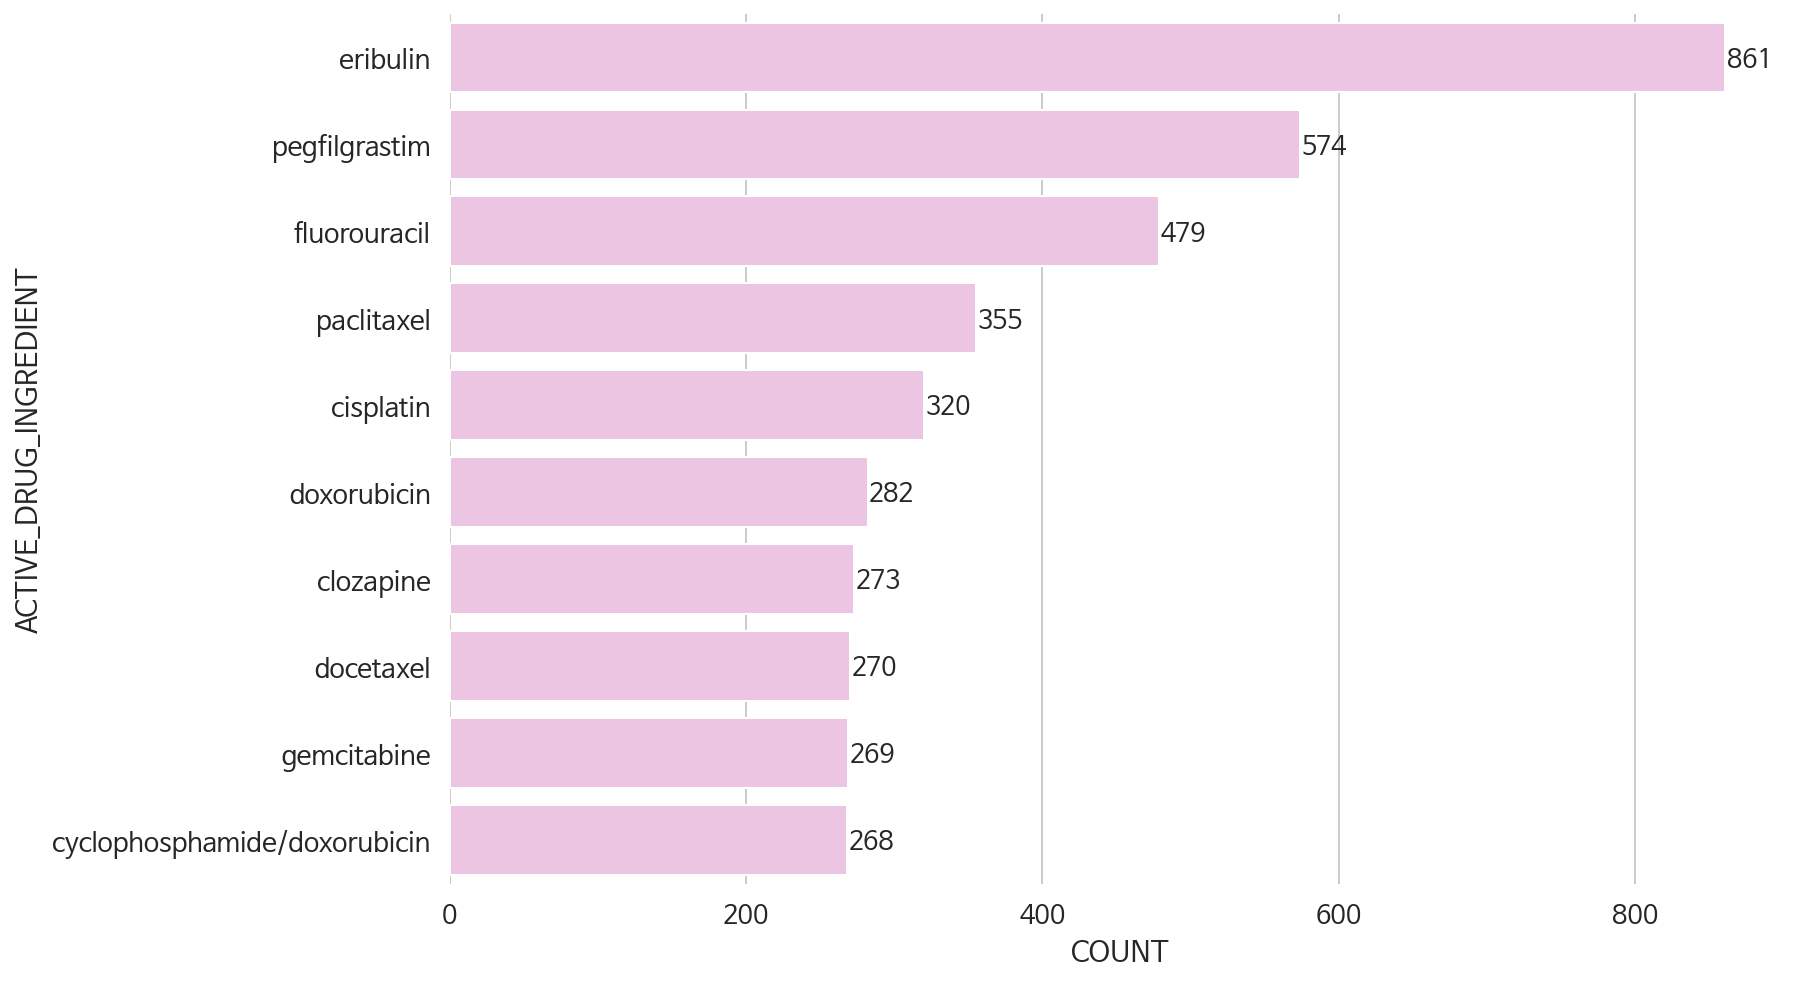

In [ ]:
barchart(data=neu_id_susp['suspected_drug'].value_counts()[:10].to_frame().reset_index().rename(columns={'suspected_drug':'COUNT','index':'ACTIVE_DRUG_INGREDIENT'}),
         x='COUNT',
         y='ACTIVE_DRUG_INGREDIENT',
         figsize=(12, 8),
         color='#F2BFE7',
         vertical=False)

In [ ]:
def get_matrix(matrix, drug_list):
    result = pd.DataFrame()

    for drug in drug_list:
        drugs = drug.split('/')
        for d in drugs:
            result = result.append(matrix[matrix['Drug']==d])

    return result

neu_matrix = pd.read_csv('Neutropenia_count_matrix.csv')
    
print('의심약물 순위')
display(get_matrix(neu_matrix, list(neu_id_susp['suspected_drug'].value_counts()[:10].index)))

print('의심+병용약물 순위')
display(get_matrix(neu_matrix, list(neu_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts()[:10].index)))

의심약물 순위


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
152,eribulin,Neutropenia,864,9540,1567,629295
176,pegfilgrastim,Neutropenia,608,9796,731,630131
37,fluorouracil,Neutropenia,953,9451,11374,619488
69,paclitaxel,Neutropenia,741,9663,6631,624231
97,cisplatin,Neutropenia,870,9534,8274,622588
8,doxorubicin,Neutropenia,1512,8892,6472,624390
76,clozapine,Neutropenia,277,10127,484,630378
62,docetaxel,Neutropenia,933,9471,6296,624566
166,gemcitabine,Neutropenia,442,9962,4121,626741
7,cyclophosphamide,Neutropenia,1586,8818,6594,624268


의심+병용약물 순위


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
7,cyclophosphamide,Neutropenia,1586,8818,6594,624268
8,doxorubicin,Neutropenia,1512,8892,6472,624390
37,fluorouracil,Neutropenia,953,9451,11374,619488
62,docetaxel,Neutropenia,933,9471,6296,624566
97,cisplatin,Neutropenia,870,9534,8274,622588
152,eribulin,Neutropenia,864,9540,1567,629295
2,dexamethasone,Neutropenia,844,9560,7110,623752
69,paclitaxel,Neutropenia,741,9663,6631,624231
66,carboplatin,Neutropenia,739,9665,4386,626476
99,vincristine,Neutropenia,720,9684,1915,628947


In [ ]:
def divide_age_group(x):
    if 0 <= x < 10:
        return '0-9'
    elif 10 <= x < 20:
        return '10-19'
    elif 20 <= x < 30:
        return '20-29'
    elif 30 <= x < 40:
        return '30-39'
    elif 40 <= x < 50:
        return '40-49'
    elif 50 <= x < 60:
        return '50-59'
    elif 60 <= x < 70:
        return '60-69'
    elif 70 <= x < 80:
        return '70-79'
    elif 80 <= x < 90:
        return '80-89'
    else:
        return '90-'
    
neu_age = df_neu[['KD_NO','MaxAgeAtVisit']].drop_duplicates().reset_index(drop=True)
neu_age['age_group'] = neu_age['MaxAgeAtVisit'].apply(divide_age_group)

neu_id_susp['KD_NO'] = neu_id_susp['KD_NO'].astype(str)
neu_id_susp_age = pd.merge(neu_id_susp, neu_age, on='KD_NO', how='left')
neu_id_susp_age.drop('MaxAgeAtVisit', axis=1, inplace=True)
neu_id_susp_age

,KD_NO,suspected_drug,age_group
0,9018,carfilzomib,60-69
1,24280,cyclophosphamide/doxorubicin,50-59
2,39362,carfilzomib/lenalidomide,60-69
3,64718,carfilzomib/lenalidomide,70-79
4,169151,carfilzomib,60-69
...,...,...,...
10399,1253969790,gemcitabine,50-59
10400,1254116741,docetaxel,60-69
10401,1254189839,doxorubicin,50-59
10402,1254271327,cyclophosphamide,50-59


In [ ]:
neu_susp_age_pivot = pd.pivot_table(neu_id_susp_age[neu_id_susp_age['suspected_drug'].isin(neu_id_susp['suspected_drug'].value_counts()[:10].index.to_list())],
                                    index='suspected_drug',
                                    columns='age_group',
                                    values='KD_NO',
                                    aggfunc='count',
                                    fill_value=0)
neu_susp_age_pivot

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89
suspected_drug,,,,,,,,,
cisplatin,0,1,3,12,45,96,103,53,7
clozapine,0,10,43,53,78,65,18,5,1
cyclophosphamide/doxorubicin,0,1,2,17,97,99,39,12,1
docetaxel,0,0,1,12,46,70,74,62,5
doxorubicin,5,3,7,11,42,85,94,29,6
eribulin,0,0,7,55,250,363,136,35,15
fluorouracil,0,0,2,16,28,134,173,107,19
gemcitabine,0,0,0,3,19,49,102,89,7
paclitaxel,0,0,1,14,57,120,87,68,8


In [ ]:
neu_susp_age_pivot['90-'] = 0
neu_susp_age_pivot

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
suspected_drug,,,,,,,,,,
cisplatin,0,1,3,12,45,96,103,53,7,0
clozapine,0,10,43,53,78,65,18,5,1,0
cyclophosphamide/doxorubicin,0,1,2,17,97,99,39,12,1,0
docetaxel,0,0,1,12,46,70,74,62,5,0
doxorubicin,5,3,7,11,42,85,94,29,6,0
eribulin,0,0,7,55,250,363,136,35,15,0
fluorouracil,0,0,2,16,28,134,173,107,19,0
gemcitabine,0,0,0,3,19,49,102,89,7,0
paclitaxel,0,0,1,14,57,120,87,68,8,0


In [ ]:
# 약물 기준
neu_susp_age_pivot.style.background_gradient(cmap='Blues', axis=1)

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
suspected_drug,,,,,,,,,,
cisplatin,0,1,3,12,45,96,103,53,7,0
clozapine,0,10,43,53,78,65,18,5,1,0
cyclophosphamide/doxorubicin,0,1,2,17,97,99,39,12,1,0
docetaxel,0,0,1,12,46,70,74,62,5,0
doxorubicin,5,3,7,11,42,85,94,29,6,0
eribulin,0,0,7,55,250,363,136,35,15,0
fluorouracil,0,0,2,16,28,134,173,107,19,0
gemcitabine,0,0,0,3,19,49,102,89,7,0
paclitaxel,0,0,1,14,57,120,87,68,8,0


In [ ]:
# 나이 기준
neu_susp_age_pivot.style.background_gradient(cmap='Blues', axis=0)

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
suspected_drug,,,,,,,,,,
cisplatin,0,1,3,12,45,96,103,53,7,0
clozapine,0,10,43,53,78,65,18,5,1,0
cyclophosphamide/doxorubicin,0,1,2,17,97,99,39,12,1,0
docetaxel,0,0,1,12,46,70,74,62,5,0
doxorubicin,5,3,7,11,42,85,94,29,6,0
eribulin,0,0,7,55,250,363,136,35,15,0
fluorouracil,0,0,2,16,28,134,173,107,19,0
gemcitabine,0,0,0,3,19,49,102,89,7,0
paclitaxel,0,0,1,14,57,120,87,68,8,0


In [ ]:
neu_gender = df_neu[['KD_NO','other_covariates(PatientSex_1=male_2=female)']].drop_duplicates().reset_index(drop=True)
neu_gender.columns = ['KD_NO', 'patient_sex']
neu_gender['patient_sex'] = neu_gender['patient_sex'].astype(str)
neu_gender['patient_sex'] = neu_gender['patient_sex'].apply(lambda x: 'Male' if x == '1' else 'Female')

neu_id_susp['KD_NO'] = neu_id_susp['KD_NO'].astype(str)
neu_id_susp_gen = pd.merge(neu_id_susp, neu_gender, on='KD_NO', how='left')
neu_id_susp_gen

,KD_NO,suspected_drug,patient_sex
0,9018,carfilzomib,Female
1,24280,cyclophosphamide/doxorubicin,Female
2,39362,carfilzomib/lenalidomide,Male
3,64718,carfilzomib/lenalidomide,Female
4,169151,carfilzomib,Male
...,...,...,...
10399,1253969790,gemcitabine,Male
10400,1254116741,docetaxel,Male
10401,1254189839,doxorubicin,Female
10402,1254271327,cyclophosphamide,Female


In [ ]:
neu_susp_gen_pivot = pd.pivot_table(neu_id_susp_gen[neu_id_susp_gen['suspected_drug'].isin(neu_id_susp['suspected_drug'].value_counts()[:10].index.to_list())],
                                    index='suspected_drug',
                                    columns='patient_sex',
                                    values='KD_NO',
                                    aggfunc='count')
neu_susp_gen_pivot

patient_sex,Female,Male
suspected_drug,,
cisplatin,128,192
clozapine,149,124
cyclophosphamide/doxorubicin,264,4
docetaxel,152,118
doxorubicin,196,86
eribulin,855,6
fluorouracil,209,270
gemcitabine,122,147
paclitaxel,277,78


In [ ]:
# 약물 기준
neu_susp_gen_pivot.style.background_gradient(cmap='Greens', axis=1)

patient_sex,Female,Male
suspected_drug,,
cisplatin,128,192
clozapine,149,124
cyclophosphamide/doxorubicin,264,4
docetaxel,152,118
doxorubicin,196,86
eribulin,855,6
fluorouracil,209,270
gemcitabine,122,147
paclitaxel,277,78


In [ ]:
# 성별 기준
neu_susp_gen_pivot.style.background_gradient(cmap='Greens', axis=0)

patient_sex,Female,Male
suspected_drug,,
cisplatin,128,192
clozapine,149,124
cyclophosphamide/doxorubicin,264,4
docetaxel,152,118
doxorubicin,196,86
eribulin,855,6
fluorouracil,209,270
gemcitabine,122,147
paclitaxel,277,78


#### 의심약물 ATC 분포 확인

In [ ]:
neu_susp_drug = df_neu[df_neu['DOUBT_CMBT_CSF']=='1'][['ACTIVE_DRUG_INGREDIENT','WHO_ATC_CD']].drop_duplicates().reset_index(drop=True)
neu_susp_drug

,ACTIVE_DRUG_INGREDIENT,WHO_ATC_CD
0,carfilzomib,L01XG02
1,cyclophosphamide,L01AA01
2,doxorubicin,L01DB01
3,lenalidomide,L04AX04
4,fluorouracil,L01BC02
...,...,...
324,colistin,J01XB01
325,celecoxib,M01AH01
326,polycarbophil,A06AC08
327,ceftezole,J01DB12


In [ ]:
neu_susp_drug.nunique()

ACTIVE_DRUG_INGREDIENT    303
WHO_ATC_CD                309
1                          13
2                          10
3                          10
4                          15
5                          38
dtype: int64

In [ ]:
neu_susp_drug['1'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[0])
neu_susp_drug['2'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[1:3])
neu_susp_drug['3'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[3] if len(x) > 3 else np.NaN)
neu_susp_drug['4'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[4] if len(x) > 4 else np.NaN)
neu_susp_drug['5'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[5:] if len(x) > 5 else np.NaN)

neu_susp_drug_atc1 = neu_susp_drug.groupby('1').count()
neu_susp_drug_atc1['Percent'] = neu_susp_drug_atc1['ACTIVE_DRUG_INGREDIENT'].apply(lambda x: x/329*100)
neu_susp_drug_atc1 = neu_susp_drug_atc1[['ACTIVE_DRUG_INGREDIENT','Percent']].reset_index()\
        .rename(columns={'1':'ATC Class','ACTIVE_DRUG_INGREDIENT':'ACTIVE_DRUG_INGREDIENT Count'})
neu_susp_drug_atc1

,ATC Class,ACTIVE_DRUG_INGREDIENT Count,Percent
0,A,19,5.775076
1,B,10,3.039514
2,C,10,3.039514
3,D,1,0.303951
4,H,9,2.735562
5,J,96,29.179331
6,L,121,36.778116
7,M,6,1.823708
8,N,37,11.246201
9,P,2,0.607903


In [ ]:
neu_susp_drug['1'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[0])
neu_susp_drug['2'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[1:3])
neu_susp_drug['3'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[3] if len(x) > 3 else np.NaN)
neu_susp_drug['4'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[4] if len(x) > 4 else np.NaN)
neu_susp_drug['5'] = neu_susp_drug['WHO_ATC_CD'].apply(lambda x: x[5:] if len(x) > 5 else np.NaN)

neu_susp_drug_atc1 = neu_susp_drug.groupby('1').count()
neu_susp_drug_atc1['Percent'] = neu_susp_drug_atc1['ACTIVE_DRUG_INGREDIENT'].apply(lambda x: x/329*100)
neu_susp_drug_atc1 = neu_susp_drug_atc1[['ACTIVE_DRUG_INGREDIENT','Percent']].reset_index()\
        .rename(columns={'1':'ATC Class','ACTIVE_DRUG_INGREDIENT':'ACTIVE_DRUG_INGREDIENT Count'})

row_G = {
    'ATC Class': 'G',
    'ACTIVE_DRUG_INGREDIENT Count': 0,
    'Percent': 0
}

idx = 4
t1 = neu_susp_drug_atc1[neu_susp_drug_atc1.index < idx]
t2 = neu_susp_drug_atc1[neu_susp_drug_atc1.index >= idx]

neu_susp_drug_atc1 = t1.append(row_G, ignore_index=True).append(t2, ignore_index=True)

neu_susp_drug_atc1['color'] = sns.color_palette('Pastel1')[:8] + sns.color_palette('Pastel2')[:6]
neu_susp_drug_atc1 = neu_susp_drug_atc1.sort_values(by='Percent', ascending=False).reset_index(drop=True)
neu_susp_drug_atc1

,ATC Class,ACTIVE_DRUG_INGREDIENT Count,Percent,color
0,L,121,36.778116,"(0.9921568627450981, 0.8549019607843137, 0.925..."
1,J,96,29.179331,"(0.8980392156862745, 0.8470588235294118, 0.741..."
2,N,37,11.246201,"(0.9921568627450981, 0.803921568627451, 0.6745..."
3,A,19,5.775076,"(0.984313725490196, 0.7058823529411765, 0.6823..."
4,R,12,3.647416,"(0.9568627450980393, 0.792156862745098, 0.8941..."
5,B,10,3.039514,"(0.7019607843137254, 0.803921568627451, 0.8901..."
6,C,10,3.039514,"(0.8, 0.9215686274509803, 0.7725490196078432)"
7,H,9,2.735562,"(1.0, 1.0, 0.8)"
8,M,6,1.823708,"(0.7019607843137254, 0.8862745098039215, 0.803..."
9,V,5,1.519757,"(1.0, 0.9490196078431372, 0.6823529411764706)"


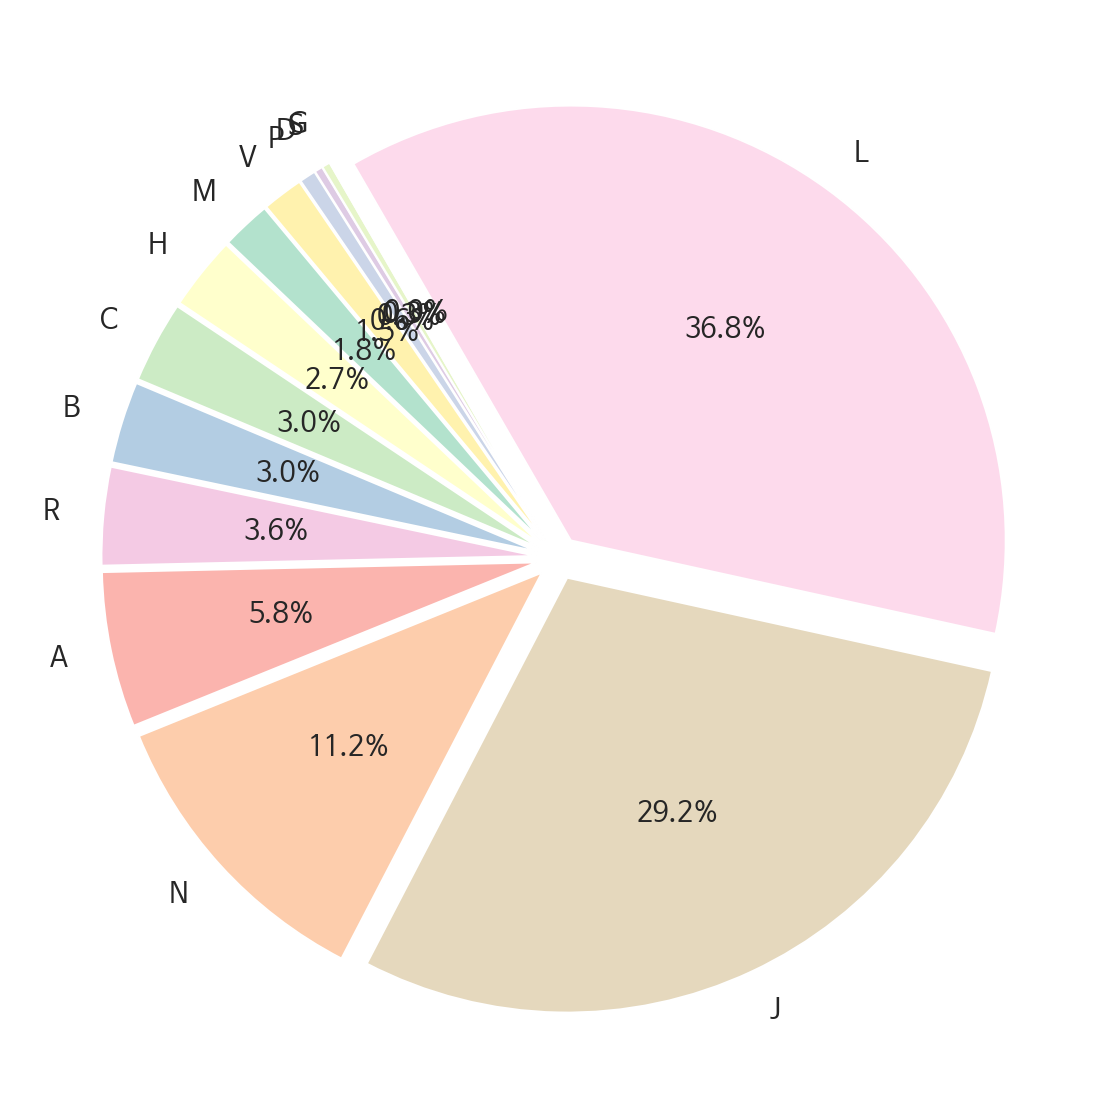

In [ ]:
data = neu_susp_drug_atc1['Percent'].to_list()
labels = neu_susp_drug_atc1['ATC Class'].to_list()
explode = [0.05] * 14
colors = neu_susp_drug_atc1['color'].to_list()
plt.figure(figsize=(10,10))
plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%', textprops={'fontsize': 14},
        explode=explode, startangle=120, counterclock=False)
plt.show()

In [ ]:
nsa1 = neu_susp_drug_atc1[['ATC Class','ACTIVE_DRUG_INGREDIENT Count']]
nsa1.columns = ['ATC Class','Neu Count']

aa1 = all_drug_atc1[['ATC Class','ACTIVE_DRUG_INGREDIENT Count']]
aa1.columns = ['ATC Class','All Count']

nsaa1 = pd.merge(nsa1, aa1, on='ATC Class', how='inner')

nsaa1['Percent of All'] = ''

for i in range(14):
    nsaa1.iloc[i, 3] = round(nsaa1.iloc[i, 1] / nsaa1.iloc[i, 2] * 100, 1)
    
nsaa1['color'] = neu_susp_drug_atc1['color']
nsaa1

,ATC Class,Neu Count,All Count,Percent of All,color
0,L,121,198,61.1,"(0.9921568627450981, 0.8549019607843137, 0.925..."
1,J,96,277,34.7,"(0.8980392156862745, 0.8470588235294118, 0.741..."
2,N,37,204,18.1,"(0.9921568627450981, 0.803921568627451, 0.6745..."
3,A,19,277,6.9,"(0.984313725490196, 0.7058823529411765, 0.6823..."
4,R,12,143,8.4,"(0.9568627450980393, 0.792156862745098, 0.8941..."
5,B,10,112,8.9,"(0.7019607843137254, 0.803921568627451, 0.8901..."
6,C,10,208,4.8,"(0.8, 0.9215686274509803, 0.7725490196078432)"
7,H,9,35,25.7,"(1.0, 1.0, 0.8)"
8,M,6,91,6.6,"(0.7019607843137254, 0.8862745098039215, 0.803..."
9,V,5,70,7.1,"(1.0, 0.9490196078431372, 0.6823529411764706)"


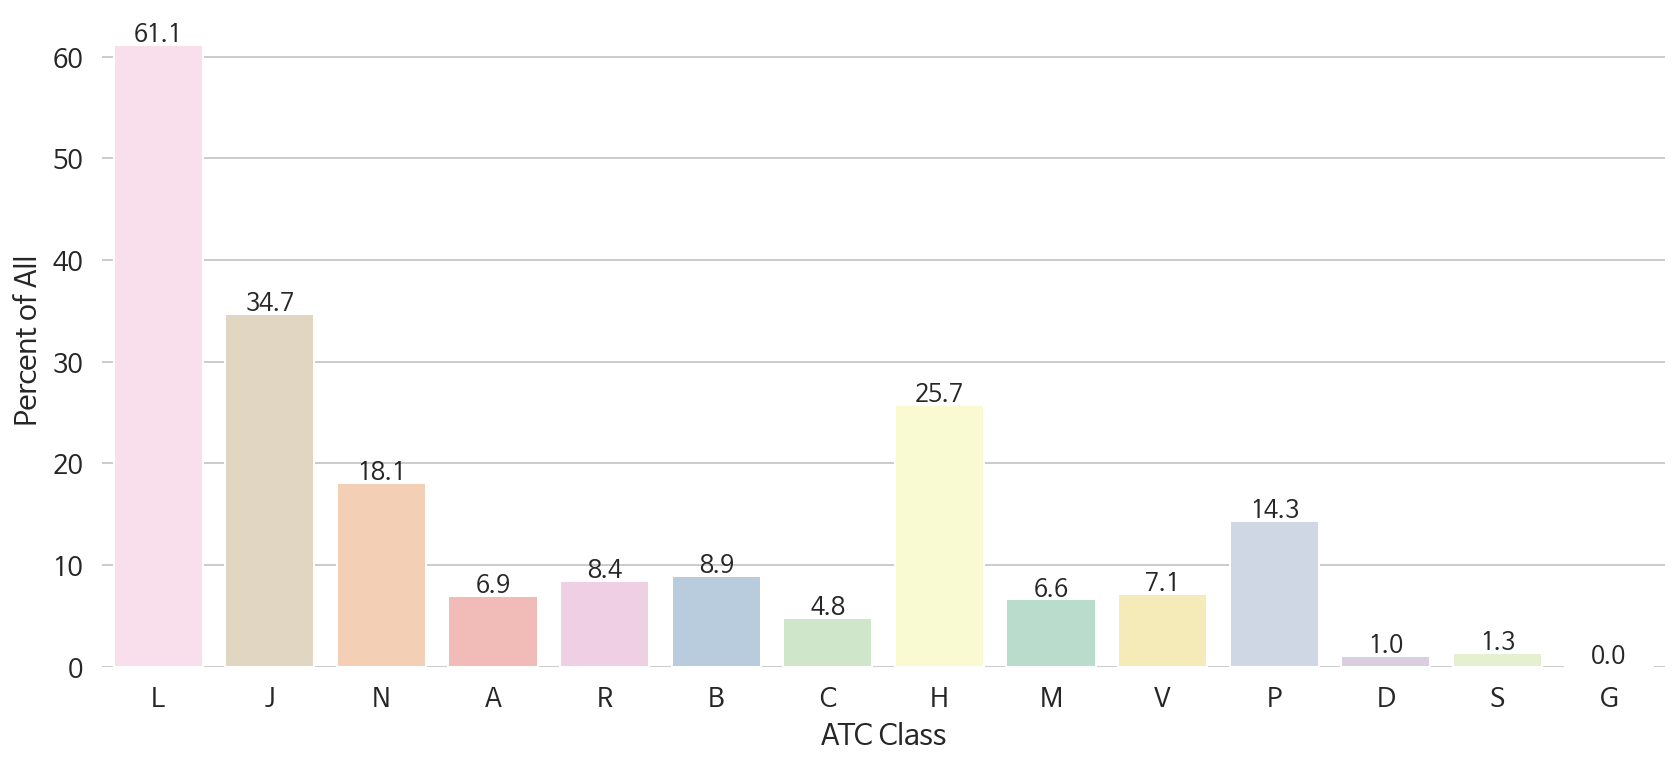

In [ ]:
barchart(data=nsaa1,
         x='ATC Class',
         y='Percent of All',
         figsize=(14, 6),
         palette=list(nsaa1['color']),
         margin=0.4,
         vertical=True,
         ratio=True)

#### 필터링

1. 해당 약물을 보고한 사람들 중 Neutropenia 부작용을 보고한 사람 비율 20% 이상
2. 해당 약물을 보고한 사람의 수 100 이상

In [ ]:
filter_outlier_drug = filtering(list(neu_id_drug['ACTIVE_DRUG_INGREDIENT'].unique()), 'Neutropenia')
len(filter_outlier_drug)

100%|██████████| 688/688 [04:40<00:00,  2.45it/s]


27

In [ ]:
drug = 'aprepitant'
print(df_neu[(df_neu['ACTIVE_DRUG_INGREDIENT']==drug)]['DOUBT_CMBT_CSF'].value_counts())
print('의심약물 KD_NO 건수 :', df_neu[(df_neu['ACTIVE_DRUG_INGREDIENT']==drug) & (df_neu['DOUBT_CMBT_CSF']=='1')]['KD_NO'].nunique())
print('병용약물 KD_NO 건수 :', df_neu[(df_neu['ACTIVE_DRUG_INGREDIENT']==drug) & (df_neu['DOUBT_CMBT_CSF']=='2')]['KD_NO'].nunique())
display(df_neu[(df_neu['ACTIVE_DRUG_INGREDIENT']==drug)])

1    1042
2     946
Name: DOUBT_CMBT_CSF, dtype: int64
의심약물 KD_NO 건수 : 263
병용약물 KD_NO 건수 : 232


,KD_NO,adr_seq,WHOART_ARRN,WHOART_SEQ,ICD10_code,ICD9CM_code,ICD10CM_code,drug_seq,DRUG_CHEM,WHO_ATC_CD,DSAS_CD,dsas_cd_ver,ACTIVE_DRUG_INGREDIENT,Phenotype,DOUBT_CMBT_CSF,ICD10CM_code,response,MaxAgeAtVisit,other_covariates(PatientSex_1=male_2=female)
2080,16481236,3,572,3.0,nan,288.0,D70,2,aprepitant,A04AD12,C50,7.0,aprepitant,Neutropenia,2,D70,1,43,2
2081,16481236,3,572,3.0,nan,288.0,D70.9,2,aprepitant,A04AD12,C50,7.0,aprepitant,Neutropenia,2,D70.9,1,43,2
2082,16481236,3,572,3.0,nan,288.00,D70,2,aprepitant,A04AD12,C50,7.0,aprepitant,Neutropenia,2,D70,1,43,2
2083,16481236,3,572,3.0,nan,288.00,D70.9,2,aprepitant,A04AD12,C50,7.0,aprepitant,Neutropenia,2,D70.9,1,43,2
2244,16968306,4,572,3.0,nan,288.0,D70,2,aprepitant,A04AD12,Z29.9,7.0,aprepitant,Neutropenia,2,D70,1,61,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147858,944516452,3,572,3.0,nan,288.00,D70.9,6,aprepitant,A04AD12,Z29,6.0,aprepitant,Neutropenia,2,D70.9,1,50,2
147859,944516452,3,572,3.0,nan,288.0,D70,6,aprepitant,A04AD12,Z29.8,6.0,aprepitant,Neutropenia,2,D70,1,50,2
147860,944516452,3,572,3.0,nan,288.0,D70.9,6,aprepitant,A04AD12,Z29.8,6.0,aprepitant,Neutropenia,2,D70.9,1,50,2
147861,944516452,3,572,3.0,nan,288.00,D70,6,aprepitant,A04AD12,Z29.8,6.0,aprepitant,Neutropenia,2,D70,1,50,2


In [ ]:
filter_outlier_drug = dict(sorted(filter_outlier_drug.items(), key=lambda x: x[1], reverse=True))
filter_outlier_drug

{'histamine dihydrochloride': 100,
 'astemizole': 67,
 'chlorquinaldol': 67,
 'tobramycin': 56,
 'dactinomycin': 54,
 'mercaptopurine': 50,
 'pegfilgrastim': 45,
 'filgrastim': 40,
 'clozapine': 36,
 'eribulin': 36,
 'dexrazoxane': 35,
 'lenograstim': 33,
 'fibrinogen': 33,
 'palbociclib': 33,
 'vinblastine': 30,
 'chlorambucil': 29,
 'peginterferon alfa-2a': 29,
 'vincristine': 27,
 'cefoperazone': 25,
 'benzocaine': 25,
 'daunorubicin': 24,
 'decitabine': 24,
 'zoledronic acid': 23,
 'darbepoetin alfa': 22,
 'benzethonium': 22,
 'pertuzumab': 21,
 'aprepitant': 20}

In [ ]:
phenotype = 'Neutropenia'

for d in filter_outlier_drug:
    print(d)
    reports_by_drug_taking(d, phenotype)
    print()

histamine dihydrochloride
histamine dihydrochloride 복용한 사람 수 : 2
histamine dihydrochloride 복용하지 않은 사람 수 : 641264
Neutropenia 보고한 사람 수 : 10404
Neutropenia 보고하지 않은 사람 수 : 630862

약물 histamine dihydrochloride 복용하고 Neutropenia 부작용을 보고한 KD_NO 개수
2
( histamine dihydrochloride 복용한 사람들 중 100.0 % ) | ( Neutropenia 부작용 보고한 사람들 중 0.02 % )

약물 histamine dihydrochloride 복용하지 않고 Neutropenia 부작용을 보고한 KD_NO 개수
10402
( histamine dihydrochloride 복용하지 않은 사람들 중 1.6 % ) | ( Neutropenia 부작용 보고한 사람들 중 99.98 % )

약물 histamine dihydrochloride 복용하고 다른 부작용을 보고한 KD_NO 개수
0
( histamine dihydrochloride 복용한 사람들 중 0.0 % ) | ( 부작용 보고하지 않은 사람들 중 0.0 % )

약물 histamine dihydrochloride 복용하지 않고 다른 부작용을 보고한 KD_NO 개수
630862
( histamine dihydrochloride 복용하지 않은 사람들 중 98.4 % ) | ( 부작용 보고하지 않은 사람들 중 100.0 % )

astemizole
astemizole 복용한 사람 수 : 3
astemizole 복용하지 않은 사람 수 : 641263
Neutropenia 보고한 사람 수 : 10404
Neutropenia 보고하지 않은 사람 수 : 630862

약물 astemizole 복용하고 Neutropenia 부작용을 보고한 KD_NO 개수
2
( astemizole 복용한 사람들 중 66.7 % ) | ( Neu

### Insomnia 

In [ ]:
df_ins = ua.loc[ua['KD_NO'].isin(ins_id) & (ua['ICD9CM_code'].isin(ins_icd) | ua['ICD10CM_code'].isin(ins_icd) | ua['ICD10_code'].isin(ins_icd))].drop_duplicates().reset_index(drop=True)
df_ins = pd.merge(df_ins, group, left_on='KD_NO', right_on='id', how='left').drop('id', axis=1)
df_ins = df_ins.dropna(subset=['ACTIVE_DRUG_INGREDIENT'])
df_ins

,KD_NO,adr_seq,WHOART_ARRN,WHOART_SEQ,ICD10_code,ICD9CM_code,ICD10CM_code,drug_seq,DRUG_CHEM,WHO_ATC_CD,DSAS_CD,dsas_cd_ver,ACTIVE_DRUG_INGREDIENT,Phenotype,DOUBT_CMBT_CSF,ICD10CM_code,response,MaxAgeAtVisit,other_covariates(PatientSex_1=male_2=female)
0,32552,1,183,1.0,nan,780.52,G47.0,1,"pseudoephedrine, combinations",R01BA52,R09.3,7.0,pseudoephedrine,Insomnia,1,G47.0,0,62,1
1,32552,1,183,1.0,nan,780.52,G47.00,1,"pseudoephedrine, combinations",R01BA52,R09.3,7.0,pseudoephedrine,Insomnia,1,G47.00,0,62,1
2,100962,2,183,1.0,nan,780.52,G47.0,1,fluorouracil,L01BC02,C25.2,7.0,fluorouracil,Insomnia,1,G47.0,0,57,2
3,100962,2,183,1.0,nan,780.52,G47.00,1,fluorouracil,L01BC02,C25.2,7.0,fluorouracil,Insomnia,1,G47.00,0,57,2
4,100962,2,183,1.0,nan,780.52,G47.0,2,oxaliplatin,L01XA03,C25.2,7.0,oxaliplatin,Insomnia,1,G47.0,0,57,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72862,1259037596,1,183,1.0,nan,780.52,G47.00,4,eperisone,M03BX09,NaN,NaN,eperisone,Insomnia,1,G47.00,0,76,1
72863,1259743040,1,183,1.0,nan,780.52,G47.0,1,risedronic acid and colecalciferol,M05BB07,M81.0,6.0,risedronic acid,Insomnia,1,G47.0,0,79,2
72864,1259743040,1,183,1.0,nan,780.52,G47.0,1,risedronic acid and colecalciferol,M05BB07,M81.0,6.0,colecalciferol,Insomnia,1,G47.0,0,79,2
72865,1259743040,1,183,1.0,nan,780.52,G47.00,1,risedronic acid and colecalciferol,M05BB07,M81.0,6.0,risedronic acid,Insomnia,1,G47.00,0,79,2


In [ ]:
df_ins.nunique()

KD_NO                                           7790
adr_seq                                           12
WHOART_ARRN                                        5
WHOART_SEQ                                         3
ICD10_code                                         2
ICD9CM_code                                        2
ICD10CM_code                                       3
drug_seq                                          78
DRUG_CHEM                                        960
WHO_ATC_CD                                      1018
DSAS_CD                                         1070
dsas_cd_ver                                        2
ACTIVE_DRUG_INGREDIENT                           870
Phenotype                                          1
DOUBT_CMBT_CSF                                     2
ICD10CM_code                                       4
response                                           2
MaxAgeAtVisit                                     96
other_covariates(PatientSex_1=male_2=female)  

#### ATC 분석

In [ ]:
ins_drug = df_ins[['ACTIVE_DRUG_INGREDIENT','WHO_ATC_CD']].drop_duplicates().reset_index(drop=True)
ins_drug

,ACTIVE_DRUG_INGREDIENT,WHO_ATC_CD
0,pseudoephedrine,R01BA52
1,fluorouracil,L01BC02
2,oxaliplatin,L01XA03
3,irinotecan,L01XX19
4,pregabalin,N03AX16
...,...,...
1115,norfloxacin,J01MA06
1116,ciclosporin,S01XA18
1117,chondroitin sulfate,M01AX25
1118,proguanil,P01BB51


In [ ]:
ins_drug['1'] = ins_drug['WHO_ATC_CD'].apply(lambda x: x[0])
ins_drug['2'] = ins_drug['WHO_ATC_CD'].apply(lambda x: x[1:3])
ins_drug['3'] = ins_drug['WHO_ATC_CD'].apply(lambda x: x[3] if len(x) > 3 else np.NaN)
ins_drug['4'] = ins_drug['WHO_ATC_CD'].apply(lambda x: x[4] if len(x) > 4 else np.NaN)
ins_drug['5'] = ins_drug['WHO_ATC_CD'].apply(lambda x: x[5:] if len(x) > 5 else np.NaN)
ins_drug

,ACTIVE_DRUG_INGREDIENT,WHO_ATC_CD,1,2,3,4,5
0,pseudoephedrine,R01BA52,R,01,B,A,52
1,fluorouracil,L01BC02,L,01,B,C,02
2,oxaliplatin,L01XA03,L,01,X,A,03
3,irinotecan,L01XX19,L,01,X,X,19
4,pregabalin,N03AX16,N,03,A,X,16
...,...,...,...,...,...,...,...
1115,norfloxacin,J01MA06,J,01,M,A,06
1116,ciclosporin,S01XA18,S,01,X,A,18
1117,chondroitin sulfate,M01AX25,M,01,A,X,25
1118,proguanil,P01BB51,P,01,B,B,51


In [ ]:
ins_drug.nunique()

ACTIVE_DRUG_INGREDIENT     870
WHO_ATC_CD                1018
1                           14
2                           13
3                           13
4                           16
5                           46
dtype: int64

In [ ]:
ins_drug.isnull().sum()

ACTIVE_DRUG_INGREDIENT    0
WHO_ATC_CD                0
1                         0
2                         0
3                         0
4                         0
5                         0
dtype: int64

In [ ]:
ins_drug_atc1 = ins_drug.groupby('1').count()
ins_drug_atc1['Percent'] = ins_drug_atc1['ACTIVE_DRUG_INGREDIENT'].apply(lambda x: x/1120*100, 1)
ins_drug_atc1 = ins_drug_atc1[['ACTIVE_DRUG_INGREDIENT','Percent']].reset_index()\
        .rename(columns={'1':'ATC Class','ACTIVE_DRUG_INGREDIENT':'ACTIVE_DRUG_INGREDIENT Count'})
ins_drug_atc1

,ATC Class,ACTIVE_DRUG_INGREDIENT Count,Percent
0,A,166,14.821429
1,B,63,5.625000
2,C,152,13.571429
3,D,45,4.017857
4,G,44,3.928571
5,H,17,1.517857
6,J,167,14.910714
7,L,109,9.732143
8,M,56,5.000000
9,N,150,13.392857


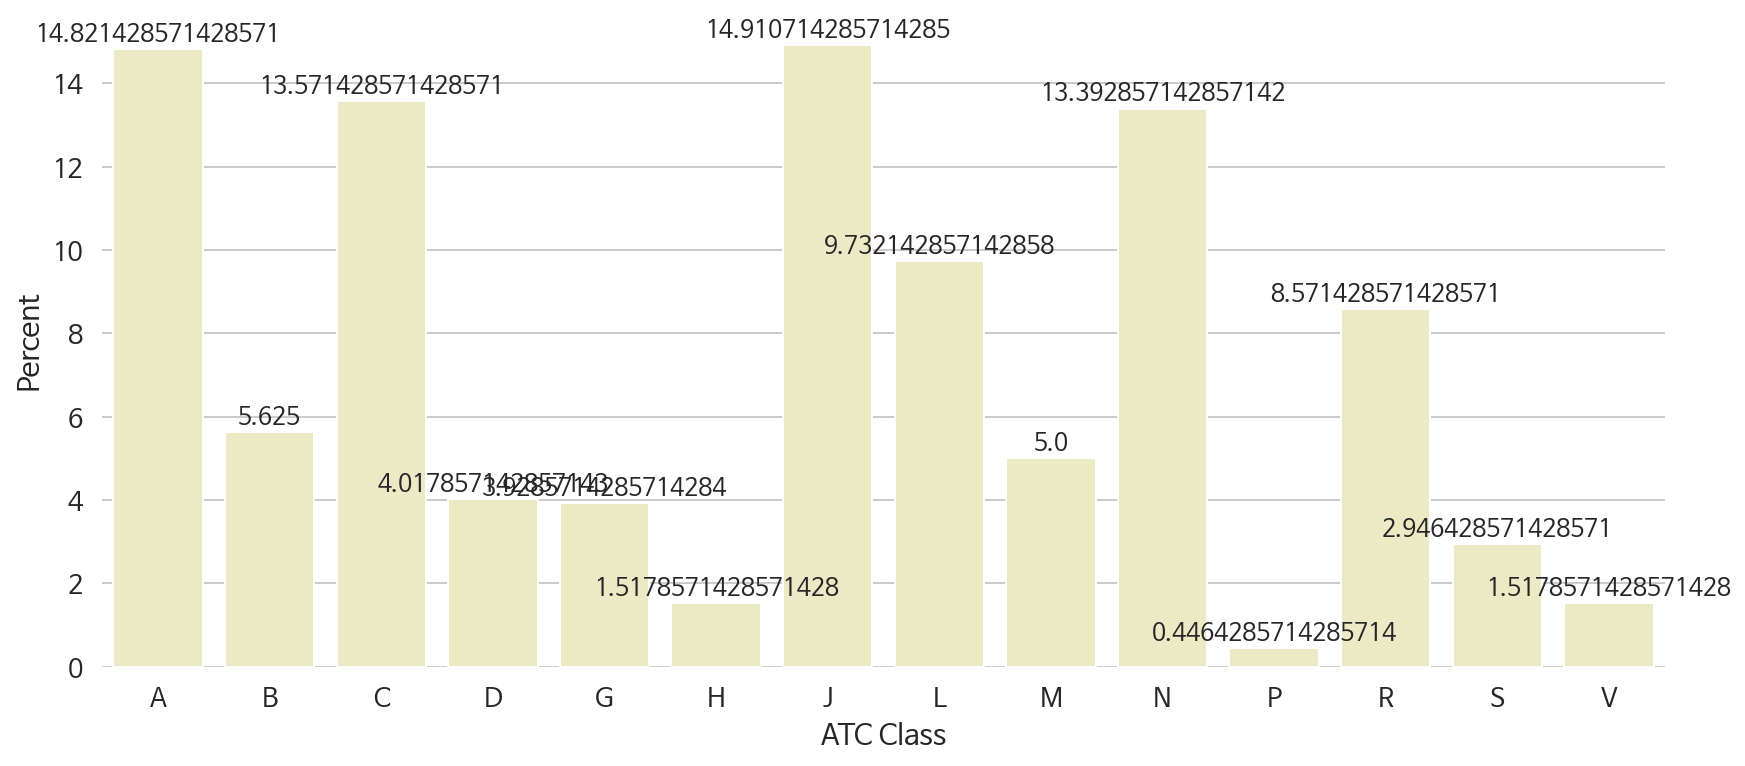

In [ ]:
barchart(data=ins_drug_atc1,
         x='ATC Class',
         y='Percent',
         figsize=(14, 6),
         color='#F2EEBF',
         margin=0.2,
         vertical=True,
         ratio=True)

In [ ]:
ins_drug_atc1['color'] = sns.color_palette('Pastel1')[:8] + sns.color_palette('Pastel2')[:6]
ins_drug_atc1_sort = ins_drug_atc1.sort_values(by='Percent', ascending=False).reset_index(drop=True)
ins_drug_atc1_sort

,ATC Class,ACTIVE_DRUG_INGREDIENT Count,Percent,color
0,J,167,14.910714,"(0.8980392156862745, 0.8470588235294118, 0.741..."
1,A,166,14.821429,"(0.984313725490196, 0.7058823529411765, 0.6823..."
2,C,152,13.571429,"(0.8, 0.9215686274509803, 0.7725490196078432)"
3,N,150,13.392857,"(0.9921568627450981, 0.803921568627451, 0.6745..."
4,L,109,9.732143,"(0.9921568627450981, 0.8549019607843137, 0.925..."
5,R,96,8.571429,"(0.9568627450980393, 0.792156862745098, 0.8941..."
6,B,63,5.625000,"(0.7019607843137254, 0.803921568627451, 0.8901..."
7,M,56,5.000000,"(0.7019607843137254, 0.8862745098039215, 0.803..."
8,D,45,4.017857,"(0.8705882352941177, 0.796078431372549, 0.8941..."
9,G,44,3.928571,"(0.996078431372549, 0.8509803921568627, 0.6509..."


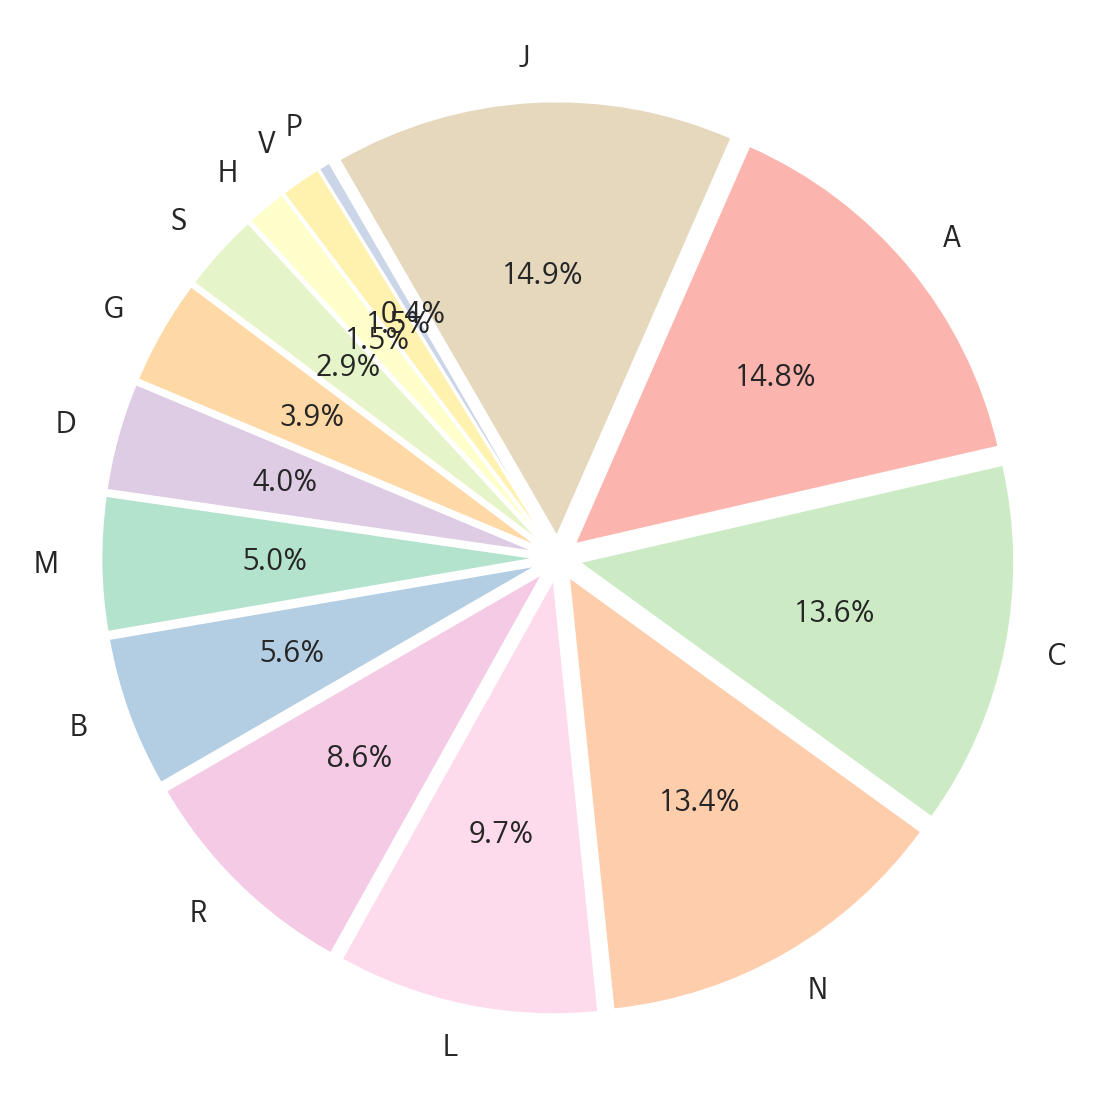

In [ ]:
data = ins_drug_atc1_sort['Percent'].to_list()
labels = ins_drug_atc1_sort['ATC Class'].to_list()
explode = [0.05] * 14
colors = ins_drug_atc1_sort['color'].to_list()
plt.figure(figsize=(10,10))
plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%', textprops={'fontsize': 14},
        explode=explode, startangle=120, counterclock=False)
plt.show()

#### 전체 ATC 분포와 비교 분석

In [ ]:
ia1 = ins_drug_atc1_sort[['ATC Class','ACTIVE_DRUG_INGREDIENT Count']]
ia1.columns = ['ATC Class','Ins Count']
ia1

,ATC Class,Ins Count
0,J,167
1,A,166
2,C,152
3,N,150
4,L,109
5,R,96
6,B,63
7,M,56
8,D,45
9,G,44


In [ ]:
aa1

,ATC Class,All Count
0,A,277
1,B,112
2,C,208
3,D,105
4,G,93
5,H,35
6,J,277
7,L,198
8,M,91
9,N,204


In [ ]:
iaa1 = pd.merge(ia1, aa1, on='ATC Class', how='inner')
iaa1

,ATC Class,Ins Count,All Count
0,J,167,277
1,A,166,277
2,C,152,208
3,N,150,204
4,L,109,198
5,R,96,143
6,B,63,112
7,M,56,91
8,D,45,105
9,G,44,93


In [ ]:
iaa1['Percent of All'] = ''

for i in range(14):
    iaa1.iloc[i, 3] = round(iaa1.iloc[i, 1] / iaa1.iloc[i, 2] * 100, 1)
    
iaa1

,ATC Class,Ins Count,All Count,Percent of All
0,J,167,277,60.3
1,A,166,277,59.9
2,C,152,208,73.1
3,N,150,204,73.5
4,L,109,198,55.1
5,R,96,143,67.1
6,B,63,112,56.2
7,M,56,91,61.5
8,D,45,105,42.9
9,G,44,93,47.3


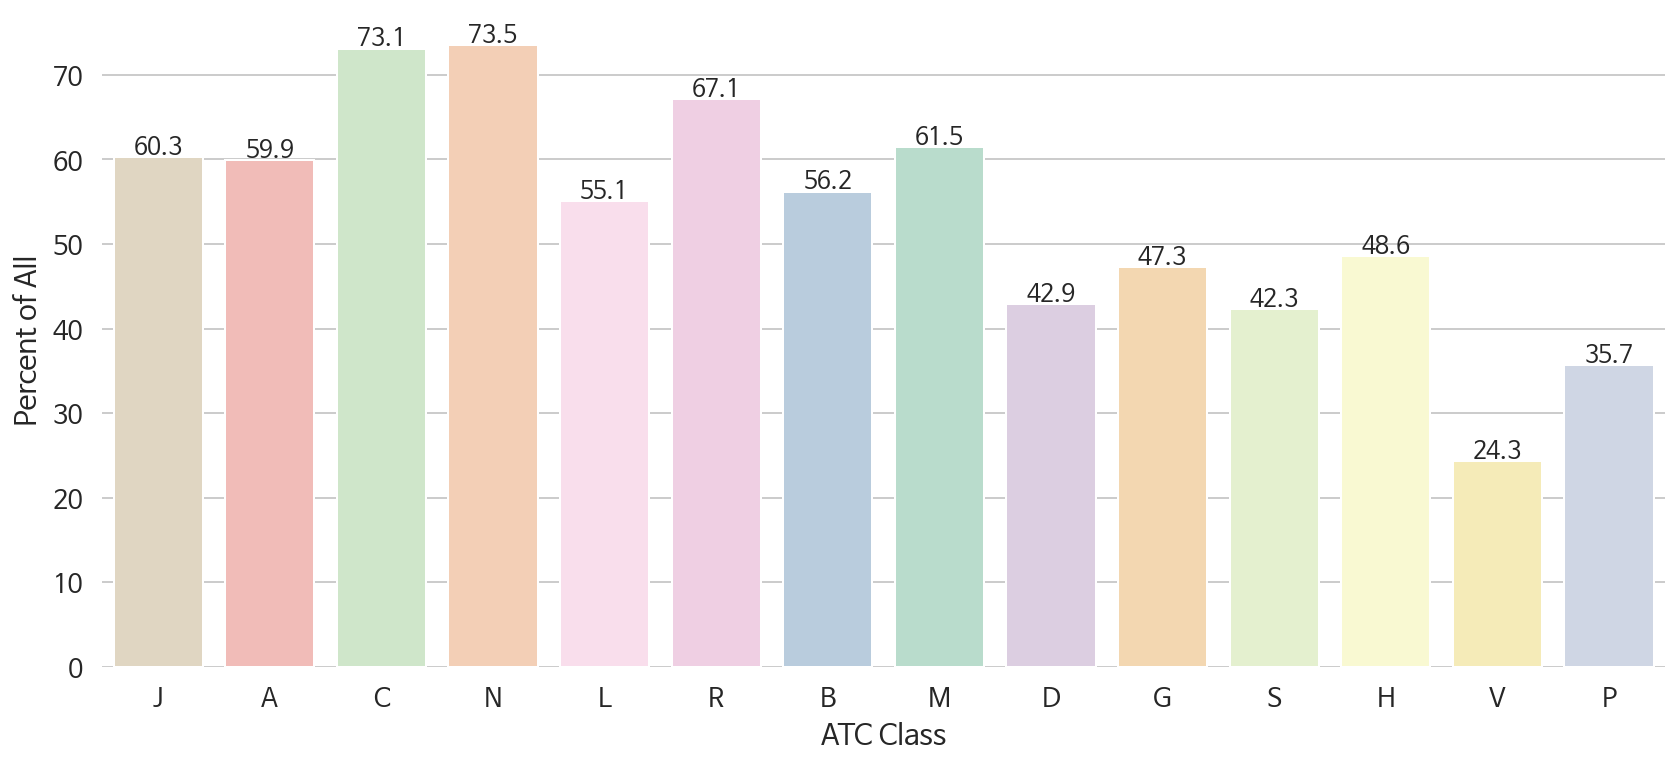

In [ ]:
barchart(data=iaa1,
         x='ATC Class',
         y='Percent of All',
         figsize=(14, 6),
         palette=ins_drug_atc1_sort['color'].to_list(),
         margin=0.4,
         vertical=True,
         ratio=True)

#### 부작용을 많이 보고한 환자/약물 상위 10개

In [ ]:
ins_id_drug = df_ins[['KD_NO','ACTIVE_DRUG_INGREDIENT','other_covariates(PatientSex_1=male_2=female)']].drop_duplicates().reset_index(drop=True)
ins_id_drug

,KD_NO,ACTIVE_DRUG_INGREDIENT,other_covariates(PatientSex_1=male_2=female)
0,32552,pseudoephedrine,1
1,100962,fluorouracil,2
2,100962,oxaliplatin,2
3,100962,irinotecan,2
4,304719,pregabalin,2
...,...,...,...
29933,1259028360,ciclopirox,1
29934,1259028360,tinidazole,1
29935,1259037596,eperisone,1
29936,1259743040,risedronic acid,2


In [ ]:
ins_id_drug.nunique()

KD_NO                                           7790
ACTIVE_DRUG_INGREDIENT                           870
other_covariates(PatientSex_1=male_2=female)       2
dtype: int64

In [ ]:
ins_id_drug['KD_NO'].value_counts()[:20]

353974677     61
447815983     57
88117581      52
700310469     48
181756518     47
297580704     46
69949448      46
302469078     46
55666117      43
251119945     43
74261834      42
1029415256    41
299108604     41
73897585      39
72584816      39
366801377     38
355193391     37
251853869     37
892630010     37
44225696      36
Name: KD_NO, dtype: int64

In [ ]:
ins_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts()[:20]

paracetamol                 1401
pseudoephedrine             1295
tramadol                     703
mosapride                    674
eperisone                    656
erdosteine                   518
rebamipide                   505
prednisolone                 451
zolpidem                     437
methylprednisolone           429
aceclofenac                  368
dexamethasone                366
acetylcysteine               359
amlodipine                   326
dexibuprofen                 297
chlorphenamine               290
beta-lactamase inhibitor     281
amoxicillin                  268
levodropropizine             263
atorvastatin                 258
Name: ACTIVE_DRUG_INGREDIENT, dtype: int64

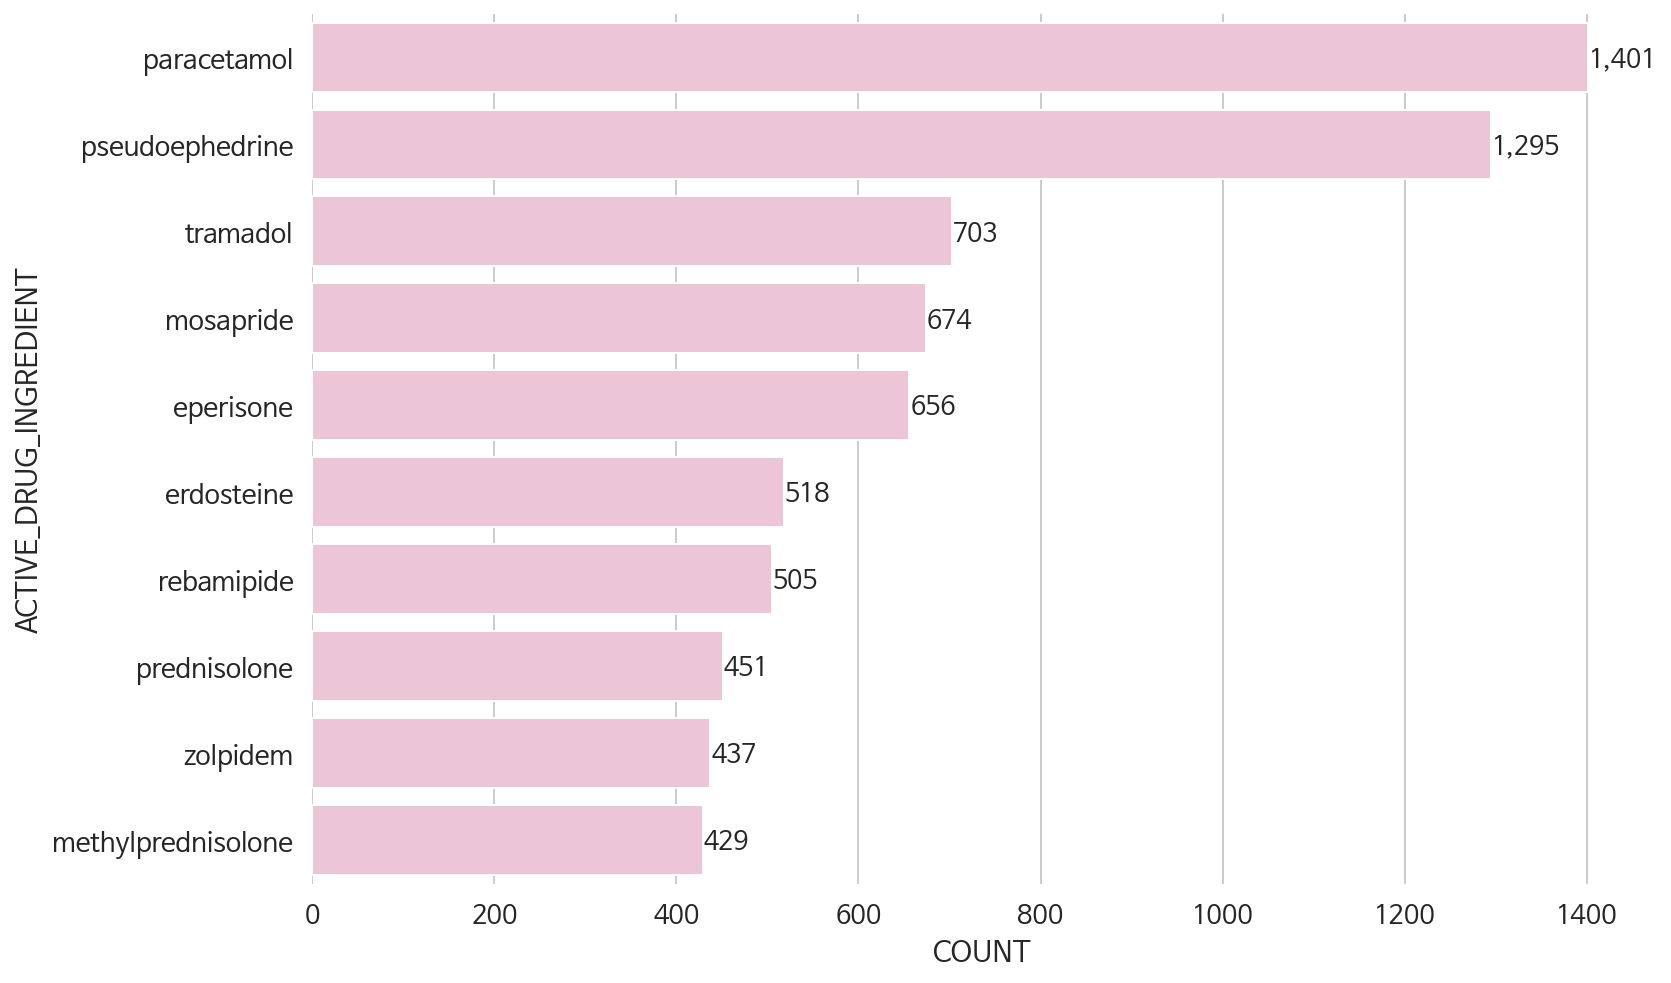

In [ ]:
barchart(data=ins_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts()[:10].to_frame().reset_index().rename(columns={'ACTIVE_DRUG_INGREDIENT':'COUNT','index':'ACTIVE_DRUG_INGREDIENT'}),
         x='COUNT',
         y='ACTIVE_DRUG_INGREDIENT',
         figsize=(12, 8),
         color='#F2BFD5',
         vertical=False)

In [ ]:
ins_id_drug.groupby(['other_covariates(PatientSex_1=male_2=female)']).count()

,KD_NO,ACTIVE_DRUG_INGREDIENT
other_covariates(PatientSex_1=male_2=female),,
1,11123,11123
2,18815,18815


In [ ]:
ins_id_drug[ins_id_drug['other_covariates(PatientSex_1=male_2=female)']==1].nunique()

KD_NO                                           2543
ACTIVE_DRUG_INGREDIENT                           719
other_covariates(PatientSex_1=male_2=female)       1
dtype: int64

In [ ]:
ins_id_drug[ins_id_drug['other_covariates(PatientSex_1=male_2=female)']==2].nunique()

KD_NO                                           5247
ACTIVE_DRUG_INGREDIENT                           771
other_covariates(PatientSex_1=male_2=female)       1
dtype: int64

In [ ]:
round(2543/7790*100, 1), round(5247/7790*100, 1)

(32.6, 67.4)

In [ ]:
ins_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().describe()

count     870.000000
mean       34.411494
std        94.075507
min         1.000000
25%         3.000000
50%         9.000000
75%        28.750000
max      1401.000000
Name: ACTIVE_DRUG_INGREDIENT, dtype: float64

In [ ]:
print('min :', ins_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().min())
print('max :', ins_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().max())
print('mean :', round(ins_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().mean(), 1))
print('median :', ins_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts().median())

min : 1
max : 1401
mean : 34.4
median : 9.0


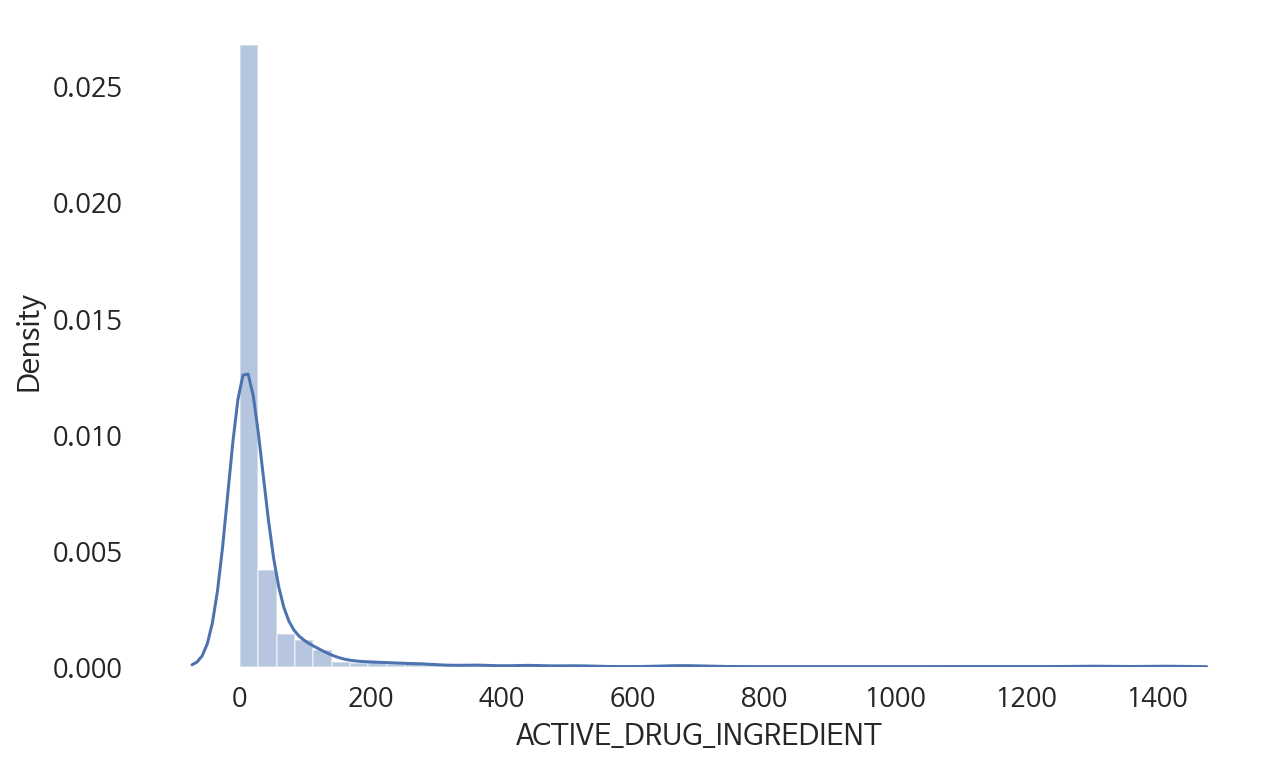

In [ ]:
sns.set(font_scale = 1.2, rc={'figure.figsize':(10, 6), "axes.unicode_minus":False}, style='white', font="NanumBarunGothic")
ax = sns.distplot(ins_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts())
sns.despine(left=True, bottom=True)
plt.show()

#### 약물들과 같이 보고된 약물들 (병용약물)

methylprednisolone 병용약물


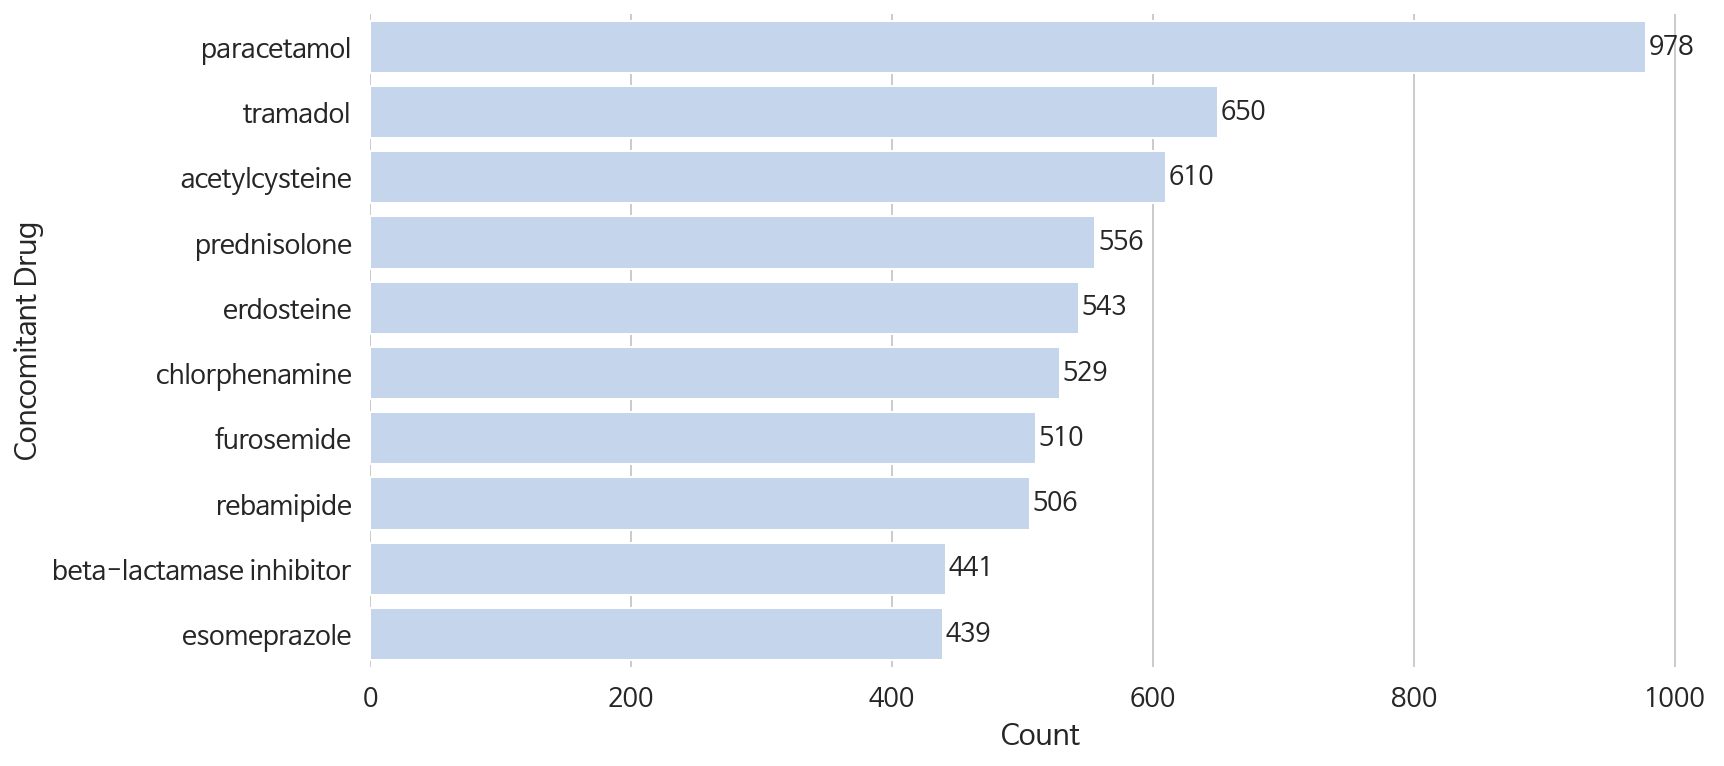

In [ ]:
for drug in ins_drug_10[9:]:
    print(drug, '병용약물')
    
    ids = list(set(amd[amd['ACTIVE_DRUG_INGREDIENT']==drug]['KD_NO']))
    tmp = amd[amd['KD_NO'].isin(ids) & (amd['DOUBT_CMBT_CSF']==2)][['KD_NO','ACTIVE_DRUG_INGREDIENT']].drop_duplicates().reset_index(drop=True)['ACTIVE_DRUG_INGREDIENT'].value_counts()[:11].to_frame()
    
    if drug in tmp.index:
        tmp = tmp.drop(drug).reset_index().rename(columns={'index':'Concomitant Drug', 'ACTIVE_DRUG_INGREDIENT':'Count'})
    else:
        tmp = tmp.reset_index().drop(10).rename(columns={'index':'Concomitant Drug', 'ACTIVE_DRUG_INGREDIENT':'Count'})
    # display(tmp)
    
    barchart(data=tmp,
             x='Count',
             y='Concomitant Drug',
             figsize=(12, 6),
             margin=100,
             color='#BFD5F2',
             vertical=False)
    # print()

#### 약물별 복용 여부에 따른 2 x 2 매트릭스 확인

In [ ]:
phenotype = 'Insomnia'

for d in ins_drug_10:
    print(d)
    reports_by_drug_taking(d, phenotype)
    print()

paracetamol
paracetamol 복용한 사람 수 : 40804
paracetamol 복용하지 않은 사람 수 : 600462
Insomnia 보고한 사람 수 : 7790
Insomnia 보고하지 않은 사람 수 : 633476

약물 paracetamol 복용하고 Insomnia 부작용을 보고한 KD_NO 개수
1401
( paracetamol 복용한 사람들 중 3.4 % ) | ( Insomnia 부작용 보고한 사람들 중 17.98 % )

약물 paracetamol 복용하지 않고 Insomnia 부작용을 보고한 KD_NO 개수
6389
( paracetamol 복용하지 않은 사람들 중 1.1 % ) | ( Insomnia 부작용 보고한 사람들 중 82.02 % )

약물 paracetamol 복용하고 다른 부작용을 보고한 KD_NO 개수
39403
( paracetamol 복용한 사람들 중 96.6 % ) | ( 부작용 보고하지 않은 사람들 중 6.22 % )

약물 paracetamol 복용하지 않고 다른 부작용을 보고한 KD_NO 개수
594073
( paracetamol 복용하지 않은 사람들 중 98.9 % ) | ( 부작용 보고하지 않은 사람들 중 93.78 % )

pseudoephedrine
pseudoephedrine 복용한 사람 수 : 6981
pseudoephedrine 복용하지 않은 사람 수 : 634285
Insomnia 보고한 사람 수 : 7790
Insomnia 보고하지 않은 사람 수 : 633476

약물 pseudoephedrine 복용하고 Insomnia 부작용을 보고한 KD_NO 개수
1295
( pseudoephedrine 복용한 사람들 중 18.6 % ) | ( Insomnia 부작용 보고한 사람들 중 16.62 % )

약물 pseudoephedrine 복용하지 않고 Insomnia 부작용을 보고한 KD_NO 개수
6495
( pseudoephedrine 복용하지 않은 사람들 중 1.0 % ) | ( Insomni

#### 약물 복용 여부와 부작용 보고 여부 개수 CSV 파일 만들기

In [ ]:
ins_matrix = pd.DataFrame()
ins_drug = list(df_ins['ACTIVE_DRUG_INGREDIENT'].unique())
phenotype = 'Insomnia'

for drug in tqdm(ins_drug):
    ins_matrix = ins_matrix.append(table_reports_by_drug_taking(drug, phenotype))

100%|██████████| 870/870 [26:00<00:00,  1.79s/it]


In [ ]:
ins_matrix = ins_matrix.reset_index(drop=True)
ins_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
0,pseudoephedrine,Insomnia,1295,6495,5686,627790
1,fluorouracil,Insomnia,21,7769,12306,621170
2,oxaliplatin,Insomnia,12,7778,10471,623005
3,irinotecan,Insomnia,13,7777,6565,626911
4,pregabalin,Insomnia,126,7664,5307,628169
...,...,...,...,...,...,...
865,fulvestrant,Insomnia,3,7787,110,633366
866,bromperidol,Insomnia,1,7789,0,633476
867,norfloxacin,Insomnia,1,7789,23,633453
868,chondroitin sulfate,Insomnia,1,7789,18,633458


In [ ]:
ins_matrix.sort_values(by='d_Y_p_Y', ascending=False)

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
35,paracetamol,Insomnia,1401,6389,39403,594073
0,pseudoephedrine,Insomnia,1295,6495,5686,627790
34,tramadol,Insomnia,703,7087,69010,564466
82,mosapride,Insomnia,674,7116,9205,624271
65,eperisone,Insomnia,656,7134,6203,627273
...,...,...,...,...,...,...
630,ulipristal,Insomnia,1,7789,194,633282
750,bendazac,Insomnia,1,7789,8,633468
486,ademetionine,Insomnia,1,7789,32,633444
752,niraparib,Insomnia,1,7789,5,633471


In [ ]:
# ins_matrix.to_csv('Insomnia_count_matrix.csv', index=False)

In [ ]:
# Insomnia 의심약물만

ins_susp_matrix = pd.DataFrame()
ins_susp_drug = list(df_ins[df_ins['DOUBT_CMBT_CSF']=='1']['ACTIVE_DRUG_INGREDIENT'].unique())
phenotype = 'Insomnia'

for drug in tqdm(ins_susp_drug):
    ins_susp_matrix = ins_susp_matrix.append(table_reports_by_drug_taking(drug, phenotype))

 70%|███████   | 466/664 [13:59<05:56,  1.80s/it]

In [ ]:
ins_susp_matrix = ins_susp_matrix.reset_index(drop=True)
ins_susp_matrix

In [ ]:
ins_susp_matrix.sort_values(by='d_Y_p_Y', ascending=False)

In [ ]:
ins_susp_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
0,pseudoephedrine,Insomnia,1295,6495,5686,627790
1,fluorouracil,Insomnia,21,7769,12306,621170
2,oxaliplatin,Insomnia,12,7778,10471,623005
3,irinotecan,Insomnia,13,7777,6565,626911
4,pregabalin,Insomnia,126,7664,5307,628169
...,...,...,...,...,...,...
659,testosterone,Insomnia,2,7788,54,633422
660,midodrine,Insomnia,4,7786,90,633386
661,golimumab,Insomnia,2,7788,115,633361
662,clindamycin,Insomnia,4,7786,829,632647


#### 카이 제곱 검정 및 오즈비 구하기

In [ ]:
ins_matrix = pd.read_csv('Insomnia_count_matrix.csv')
ins_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
0,pseudoephedrine,Insomnia,1295,6495,5686,627790
1,fluorouracil,Insomnia,21,7769,12306,621170
2,oxaliplatin,Insomnia,12,7778,10471,623005
3,irinotecan,Insomnia,13,7777,6565,626911
4,pregabalin,Insomnia,126,7664,5307,628169
...,...,...,...,...,...,...
865,fulvestrant,Insomnia,3,7787,110,633366
866,bromperidol,Insomnia,1,7789,0,633476
867,norfloxacin,Insomnia,1,7789,23,633453
868,chondroitin sulfate,Insomnia,1,7789,18,633458


In [ ]:
ins_matrix['p-value'] = ''
ins_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value
0,pseudoephedrine,Insomnia,1295,6495,5686,627790,
1,fluorouracil,Insomnia,21,7769,12306,621170,
2,oxaliplatin,Insomnia,12,7778,10471,623005,
3,irinotecan,Insomnia,13,7777,6565,626911,
4,pregabalin,Insomnia,126,7664,5307,628169,
...,...,...,...,...,...,...,...
865,fulvestrant,Insomnia,3,7787,110,633366,
866,bromperidol,Insomnia,1,7789,0,633476,
867,norfloxacin,Insomnia,1,7789,23,633453,
868,chondroitin sulfate,Insomnia,1,7789,18,633458,


In [ ]:
columns = ['phenotype_O','phenotype_X']
index = ['drug_O','drug_X']

for i in tqdm(range(len(ins_matrix))):
    row = ins_matrix.iloc[i]
    data = [[row['d_Y_p_Y'], row['d_Y_p_N']], [row['d_N_p_Y'], row['d_N_p_N']]]
    df = pd.DataFrame(data, columns=columns, index=index)

    chi_result = chi2_contingency(df, correction=False)
    ins_matrix.iloc[i, 6] = chi_result[1]
ins_matrix

100%|██████████| 870/870 [00:00<00:00, 1934.65it/s]


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959
1,fluorouracil,Insomnia,21,7769,12306,621170,0.0,0.136442
2,oxaliplatin,Insomnia,12,7778,10471,623005,0.0,0.091795
3,irinotecan,Insomnia,13,7777,6565,626911,0.0,0.159626
4,pregabalin,Insomnia,126,7664,5307,628169,0.0,1.945998
...,...,...,...,...,...,...,...,...
865,fulvestrant,Insomnia,3,7787,110,633366,0.162246,2.218264
866,bromperidol,Insomnia,1,7789,0,633476,0.0,inf
867,norfloxacin,Insomnia,1,7789,23,633453,0.186791,3.53594
868,chondroitin sulfate,Insomnia,1,7789,18,633458,0.107202,4.518181


In [ ]:
ins_matrix['odds_ratio'] = ''
ins_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,
1,fluorouracil,Insomnia,21,7769,12306,621170,0.0,
2,oxaliplatin,Insomnia,12,7778,10471,623005,0.0,
3,irinotecan,Insomnia,13,7777,6565,626911,0.0,
4,pregabalin,Insomnia,126,7664,5307,628169,0.0,
...,...,...,...,...,...,...,...,...
865,fulvestrant,Insomnia,3,7787,110,633366,0.162246,
866,bromperidol,Insomnia,1,7789,0,633476,0.0,
867,norfloxacin,Insomnia,1,7789,23,633453,0.186791,
868,chondroitin sulfate,Insomnia,1,7789,18,633458,0.107202,


In [ ]:
for i in tqdm(range(len(ins_matrix))):
    row = ins_matrix.iloc[i]
    odds = (row['d_Y_p_Y'] / row['d_Y_p_N']) / (row['d_N_p_Y'] / row['d_N_p_N'])
    ins_matrix.iloc[i, 7] = odds
ins_matrix

100%|██████████| 870/870 [00:00<00:00, 5444.56it/s]


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959
1,fluorouracil,Insomnia,21,7769,12306,621170,0.0,0.136442
2,oxaliplatin,Insomnia,12,7778,10471,623005,0.0,0.091795
3,irinotecan,Insomnia,13,7777,6565,626911,0.0,0.159626
4,pregabalin,Insomnia,126,7664,5307,628169,0.0,1.945998
...,...,...,...,...,...,...,...,...
865,fulvestrant,Insomnia,3,7787,110,633366,0.162246,2.218264
866,bromperidol,Insomnia,1,7789,0,633476,0.0,inf
867,norfloxacin,Insomnia,1,7789,23,633453,0.186791,3.53594
868,chondroitin sulfate,Insomnia,1,7789,18,633458,0.107202,4.518181


In [ ]:
ins_matrix.sort_values(by=['p-value'])[:15]

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959
138,levodropropizine,Insomnia,263,7527,2697,630779,0.0,8.172033
145,erdosteine,Insomnia,518,7272,5521,627955,0.0,8.101896
109,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103
82,mosapride,Insomnia,674,7116,9205,624271,0.0,6.423524
65,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771
253,methylprednisolone,Insomnia,429,7361,4790,628686,0.0,7.649248
35,paracetamol,Insomnia,1401,6389,39403,594073,0.0,3.306098
29,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603
11,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753


In [ ]:
ins_matrix.sort_values(by=['p-value', 'odds_ratio'], ascending=[True, False], inplace=True)

In [ ]:
ins_matrix = ins_matrix.reset_index(drop=True)
ins_matrix

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771
...,...,...,...,...,...,...,...,...
865,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743
866,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683
867,cilazapril,Insomnia,1,7789,80,633396,0.987031,1.016491
868,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491


In [ ]:
ins_matrix[:15]

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771
5,levodropropizine,Insomnia,263,7527,2697,630779,0.0,8.172033
6,erdosteine,Insomnia,518,7272,5521,627955,0.0,8.101896
7,methylprednisolone,Insomnia,429,7361,4790,628686,0.0,7.649248
8,prednisolone,Insomnia,451,7339,6000,627476,0.0,6.426663
9,mosapride,Insomnia,674,7116,9205,624271,0.0,6.423524


In [ ]:
ins_matrix.to_csv('Insomnia_count_matrix_v2.csv', index=False)

In [ ]:
len_ins_matrix = len(ins_matrix)
bon_correction = 0.05 / len_ins_matrix

print(bon_correction)
ins_matrix['bon_correction'] = ins_matrix['p-value'].apply(lambda x: True if x < bon_correction else False)
ins_matrix

5.7471264367816097e-05


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753,True
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959,True
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103,True
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603,True
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771,True
...,...,...,...,...,...,...,...,...,...
865,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743,False
866,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683,False
867,cilazapril,Insomnia,1,7789,80,633396,0.987031,1.016491,False
868,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491,False


In [ ]:
display(ins_matrix[ins_matrix['bon_correction']==True])
display(ins_matrix[ins_matrix['bon_correction']==False])

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753,True
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959,True
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103,True
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603,True
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771,True
...,...,...,...,...,...,...,...,...,...
342,indobufen,Insomnia,3,7787,30,633446,0.000036,8.13466,True
343,fimasartan,Insomnia,32,7758,1266,632210,0.000038,2.059813,True
344,gamolenic acid,Insomnia,10,7780,234,633242,0.000039,3.478358,True
345,pazopanib,Insomnia,19,7771,615,632861,0.000042,2.515996,True


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction
347,chlorpromazine,Insomnia,8,7782,170,633306,0.000065,3.829688,False
348,everolimus,Insomnia,9,7781,205,633271,0.000065,3.573081,False
349,dasabuvir,Insomnia,2,7788,15,633461,0.000072,10.845078,False
350,ketotifen,Insomnia,14,7776,407,633069,0.000077,2.800454,False
351,trihexyphenidyl,Insomnia,7,7783,140,633336,0.000086,4.068714,False
...,...,...,...,...,...,...,...,...,...
865,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743,False
866,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683,False
867,cilazapril,Insomnia,1,7789,80,633396,0.987031,1.016491,False
868,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491,False


In [ ]:
# https://stackoverflow.com/questions/7450957/how-to-implement-rs-p-adjust-in-python

from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')

p_adjust = stats.p_adjust(FloatVector(ins_matrix['p-value'].to_list()), method = 'bonferroni')
p_adjust

0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000


In [ ]:
adjust_p = pd.DataFrame.from_dict({'adjust_p-value': list(p_adjust)})

ins_matrix_adj = pd.concat([ins_matrix, adjust_p], axis=1)
ins_matrix_adj

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction,adjust_p-value
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753,True,0.0
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959,True,0.0
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103,True,0.0
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603,True,0.0
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771,True,0.0
...,...,...,...,...,...,...,...,...,...,...
865,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743,False,1.0
866,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683,False,1.0
867,cilazapril,Insomnia,1,7789,80,633396,0.987031,1.016491,False,1.0
868,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491,False,1.0


In [ ]:
display(ins_matrix_adj[ins_matrix_adj['bon_correction']==True])
display(ins_matrix_adj[ins_matrix_adj['bon_correction']==False])

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction,adjust_p-value
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753,True,0.000000
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959,True,0.000000
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103,True,0.000000
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603,True,0.000000
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771,True,0.000000
...,...,...,...,...,...,...,...,...,...,...
342,indobufen,Insomnia,3,7787,30,633446,0.000036,8.13466,True,0.031515
343,fimasartan,Insomnia,32,7758,1266,632210,0.000038,2.059813,True,0.033393
344,gamolenic acid,Insomnia,10,7780,234,633242,0.000039,3.478358,True,0.034041
345,pazopanib,Insomnia,19,7771,615,632861,0.000042,2.515996,True,0.036235


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,bon_correction,adjust_p-value
347,chlorpromazine,Insomnia,8,7782,170,633306,0.000065,3.829688,False,0.056331
348,everolimus,Insomnia,9,7781,205,633271,0.000065,3.573081,False,0.056377
349,dasabuvir,Insomnia,2,7788,15,633461,0.000072,10.845078,False,0.062306
350,ketotifen,Insomnia,14,7776,407,633069,0.000077,2.800454,False,0.066702
351,trihexyphenidyl,Insomnia,7,7783,140,633336,0.000086,4.068714,False,0.075034
...,...,...,...,...,...,...,...,...,...,...
865,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743,False,1.000000
866,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683,False,1.000000
867,cilazapril,Insomnia,1,7789,80,633396,0.987031,1.016491,False,1.000000
868,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491,False,1.000000


In [ ]:
ins_matrix_adj = ins_matrix_adj.drop('bon_correction', axis=1)
ins_matrix_adj

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753,0.0
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959,0.0
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103,0.0
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603,0.0
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771,0.0
...,...,...,...,...,...,...,...,...,...
865,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743,1.0
866,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683,1.0
867,cilazapril,Insomnia,1,7789,80,633396,0.987031,1.016491,1.0
868,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491,1.0


In [ ]:
display(ins_matrix_adj[ins_matrix_adj['adjust_p-value'] < 0.05])
display(ins_matrix_adj[ins_matrix_adj['adjust_p-value'] >= 0.05])

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753,0.000000
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959,0.000000
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103,0.000000
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603,0.000000
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771,0.000000
...,...,...,...,...,...,...,...,...,...
342,indobufen,Insomnia,3,7787,30,633446,0.000036,8.13466,0.031515
343,fimasartan,Insomnia,32,7758,1266,632210,0.000038,2.059813,0.033393
344,gamolenic acid,Insomnia,10,7780,234,633242,0.000039,3.478358,0.034041
345,pazopanib,Insomnia,19,7771,615,632861,0.000042,2.515996,0.036235


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
347,chlorpromazine,Insomnia,8,7782,170,633306,0.000065,3.829688,0.056331
348,everolimus,Insomnia,9,7781,205,633271,0.000065,3.573081,0.056377
349,dasabuvir,Insomnia,2,7788,15,633461,0.000072,10.845078,0.062306
350,ketotifen,Insomnia,14,7776,407,633069,0.000077,2.800454,0.066702
351,trihexyphenidyl,Insomnia,7,7783,140,633336,0.000086,4.068714,0.075034
...,...,...,...,...,...,...,...,...,...
865,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743,1.000000
866,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683,1.000000
867,cilazapril,Insomnia,1,7789,80,633396,0.987031,1.016491,1.000000
868,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491,1.000000


In [ ]:
ins_matrix_adj.to_csv('Insomnia_count_matrix_v3.csv', index=False)

In [ ]:
# Insomnia 의심약물만

ins_susp_matrix_adj = matrix_pval_odds_corr(ins_susp_matrix)

100%|██████████| 664/664 [00:00<00:00, 1950.44it/s]


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value
0,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0
1,fluorouracil,Insomnia,21,7769,12306,621170,0.0
2,oxaliplatin,Insomnia,12,7778,10471,623005,0.0
3,irinotecan,Insomnia,13,7777,6565,626911,0.0
4,pregabalin,Insomnia,126,7664,5307,628169,0.0
...,...,...,...,...,...,...,...
659,testosterone,Insomnia,2,7788,54,633422,0.10741
660,midodrine,Insomnia,4,7786,90,633386,0.007119
661,golimumab,Insomnia,2,7788,115,633361,0.625242
662,clindamycin,Insomnia,4,7786,829,632647,0.052786


100%|██████████| 664/664 [00:00<00:00, 5726.51it/s]


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771
...,...,...,...,...,...,...,...,...
659,pilocarpine,Insomnia,3,7787,249,633227,0.971894,0.979741
660,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743
661,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683
662,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491


Bonferroni correction 0.05 / 664 : 7.530120481927712e-05


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753,0.0
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959,0.0
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103,0.0
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603,0.0
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771,0.0
...,...,...,...,...,...,...,...,...,...
659,pilocarpine,Insomnia,3,7787,249,633227,0.971894,0.979741,1.0
660,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743,1.0
661,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683,1.0
662,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491,1.0


In [ ]:
display(ins_susp_matrix_adj[ins_susp_matrix_adj['adjust_p-value'] < 0.05])
display(ins_susp_matrix_adj[ins_susp_matrix_adj['adjust_p-value'] >= 0.05])

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
0,phentermine,Insomnia,163,7627,375,633101,0.0,36.080753,0.000000
1,pseudoephedrine,Insomnia,1295,6495,5686,627790,0.0,22.013959,0.000000
2,varenicline,Insomnia,117,7673,555,632921,0.0,17.389103,0.000000
3,zolpidem,Insomnia,437,7353,3821,629655,0.0,9.793603,0.000000
4,eperisone,Insomnia,656,7134,6203,627273,0.0,9.298771,0.000000
...,...,...,...,...,...,...,...,...,...
308,pazopanib,Insomnia,19,7771,615,632861,0.000042,2.515996,0.027655
309,minoxidil,Insomnia,6,7784,103,633373,0.000043,4.739917,0.028796
310,chlorpromazine,Insomnia,8,7782,170,633306,0.000065,3.829688,0.042993
311,everolimus,Insomnia,9,7781,205,633271,0.000065,3.573081,0.043028


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N,p-value,odds_ratio,adjust_p-value
313,ketotifen,Insomnia,14,7776,407,633069,0.000077,2.800454,0.050908
314,trihexyphenidyl,Insomnia,7,7783,140,633336,0.000086,4.068714,0.057267
315,warfarin,Insomnia,34,7756,1423,632053,0.000095,1.947107,0.063148
316,anastrozole,Insomnia,6,7784,110,633366,0.0001,4.438237,0.066175
317,influenza vaccines,Insomnia,28,7762,4673,628803,0.0001,0.485404,0.066672
...,...,...,...,...,...,...,...,...,...
659,pilocarpine,Insomnia,3,7787,249,633227,0.971894,0.979741,1.000000
660,bicalutamide,Insomnia,2,7788,166,633310,0.977052,0.979743,1.000000
661,camostat,Insomnia,2,7788,165,633311,0.983829,0.985683,1.000000
662,sirolimus,Insomnia,1,7789,80,633396,0.987031,1.016491,1.000000


In [ ]:
ins_susp_matrix_adj.to_csv('Insomnia_count_matrix_susp.csv', index=False)

#### 의심약물과 병용약물 확인

In [ ]:
# 병용 약물을 보고한 보고번호 리스트
KD_NO_list = list(df_ins[df_ins['DOUBT_CMBT_CSF']=='2']['KD_NO'].unique())
ins_conc = drugs_by_reports(df_ins, KD_NO_list)
ins_conc

100%|██████████| 2139/2139 [00:47<00:00, 45.20it/s]


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,499822,Insomnia,theobromine,acetylcysteine/amoxicillin/beta-lactamase inhi...
1,895625,Insomnia,paroxetine,alprazolam/clonazepam
2,1062211,Insomnia,paroxetine,alprazolam/flunitrazepam/lactic acid producing...
3,1078192,Insomnia,paroxetine,bromazepam/flunitrazepam
4,1405517,Insomnia,paroxetine,amitriptyline/benzatropine/paliperidone/procyc...
...,...,...,...,...
2134,1124413642,Insomnia,risperidone,clonazepam/diltiazem/linagliptin/metformin/que...
2135,1124554758,Insomnia,escitalopram,acetylsalicylic acid/amiodarone/atorvastatin/c...
2136,1145967564,Insomnia,montelukast,clarithromycin/desloratadine/doxofylline/lafut...
2137,1198154236,Insomnia,carboplatin/etoposide,ifosfamide


In [ ]:
# ins_conc.to_csv('Insomnia_concomitant_drug.csv', index=False)

In [ ]:
ins_dbr = drugs_by_reports(df_ins, ins_id)
ins_dbr

100%|██████████| 7790/7790 [02:54<00:00, 44.64it/s]


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,32552,Insomnia,pseudoephedrine,NaN
1,100962,Insomnia,fluorouracil/irinotecan/oxaliplatin,NaN
2,304719,Insomnia,pregabalin,NaN
3,499822,Insomnia,theobromine,acetylcysteine/amoxicillin/beta-lactamase inhi...
4,855215,Insomnia,phentermine,NaN
...,...,...,...,...
7785,1258262752,Insomnia,eperisone/paracetamol,NaN
7786,1258496197,Insomnia,amoxicillin/beta-lactamase inhibitor/methylpre...,NaN
7787,1259028360,Insomnia,alverine/ciclopirox/itopride/phloroglucinol/ra...,NaN
7788,1259037596,Insomnia,eperisone,NaN


In [ ]:
# ins_dbr.to_csv('Insomnia_drugs_by_reports.csv', index=False)

In [ ]:
pd.options.display.max_rows = 20

display(ins_dbr[ins_dbr['concomitant_drug'].isnull()].reset_index(drop=True))
display(ins_dbr[ins_dbr['concomitant_drug'].notnull()].reset_index(drop=True))
display(ins_dbr[ins_dbr['suspected_drug'].isnull()].reset_index(drop=True))
display(ins_dbr[ins_dbr['suspected_drug'].notnull()].reset_index(drop=True))

pd.options.display.max_rows = 60

,KD_NO,phenotype,suspected_drug,concomitant_drug
0,32552,Insomnia,pseudoephedrine,NaN
1,100962,Insomnia,fluorouracil/irinotecan/oxaliplatin,NaN
2,304719,Insomnia,pregabalin,NaN
3,855215,Insomnia,phentermine,NaN
4,1351817,Insomnia,iobitridol,NaN
...,...,...,...,...
5646,1258262752,Insomnia,eperisone/paracetamol,NaN
5647,1258496197,Insomnia,amoxicillin/beta-lactamase inhibitor/methylpre...,NaN
5648,1259028360,Insomnia,alverine/ciclopirox/itopride/phloroglucinol/ra...,NaN
5649,1259037596,Insomnia,eperisone,NaN


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,499822,Insomnia,theobromine,acetylcysteine/amoxicillin/beta-lactamase inhi...
1,895625,Insomnia,paroxetine,alprazolam/clonazepam
2,1062211,Insomnia,paroxetine,alprazolam/flunitrazepam/lactic acid producing...
3,1078192,Insomnia,paroxetine,bromazepam/flunitrazepam
4,1405517,Insomnia,paroxetine,amitriptyline/benzatropine/paliperidone/procyc...
...,...,...,...,...
2134,1124413642,Insomnia,risperidone,clonazepam/diltiazem/linagliptin/metformin/que...
2135,1124554758,Insomnia,escitalopram,acetylsalicylic acid/amiodarone/atorvastatin/c...
2136,1145967564,Insomnia,montelukast,clarithromycin/desloratadine/doxofylline/lafut...
2137,1198154236,Insomnia,carboplatin/etoposide,ifosfamide


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,14268511,Insomnia,NaN,amlodipine/atorvastatin/pseudoephedrine/tibolone
1,14482830,Insomnia,NaN,levocarnitine/magnesium/orlistat/rifaximin
2,14527135,Insomnia,NaN,levocarnitine/magnesium/mecobalamin/orlistat/p...
3,14588237,Insomnia,NaN,magnesium/orlistat/orphenadrine
4,14786962,Insomnia,NaN,orlistat/spironolactone
...,...,...,...,...
167,964703779,Insomnia,NaN,benzatropine/bromperidol/lorazepam
168,964717041,Insomnia,NaN,benzatropine/lorazepam/propranolol/varenicline...
169,994919108,Insomnia,NaN,acetylcysteine/almagate/cefuroxime/procaterol
170,1065893932,Insomnia,NaN,mosapride


,KD_NO,phenotype,suspected_drug,concomitant_drug
0,32552,Insomnia,pseudoephedrine,NaN
1,100962,Insomnia,fluorouracil/irinotecan/oxaliplatin,NaN
2,304719,Insomnia,pregabalin,NaN
3,499822,Insomnia,theobromine,acetylcysteine/amoxicillin/beta-lactamase inhi...
4,855215,Insomnia,phentermine,NaN
...,...,...,...,...
7613,1258262752,Insomnia,eperisone/paracetamol,NaN
7614,1258496197,Insomnia,amoxicillin/beta-lactamase inhibitor/methylpre...,NaN
7615,1259028360,Insomnia,alverine/ciclopirox/itopride/phloroglucinol/ra...,NaN
7616,1259037596,Insomnia,eperisone,NaN


#### 의심약물 부작용 보고건수 상위 10개

In [ ]:
ins_dbr = pd.read_csv('Insomnia_drugs_by_reports.csv')
ins_id_susp = ins_dbr[['KD_NO','suspected_drug']].drop_duplicates().reset_index(drop=True)
ins_id_susp

,KD_NO,suspected_drug
0,32552,pseudoephedrine
1,100962,fluorouracil/irinotecan/oxaliplatin
2,304719,pregabalin
3,499822,theobromine
4,855215,phentermine
...,...,...
7785,1258262752,eperisone/paracetamol
7786,1258496197,amoxicillin/beta-lactamase inhibitor/methylpre...
7787,1259028360,alverine/ciclopirox/itopride/phloroglucinol/ra...
7788,1259037596,eperisone


In [ ]:
ins_id_susp['suspected_drug'].value_counts()[:20]

pseudoephedrine         433
paracetamol/tramadol    218
phentermine             126
teriparatide            126
varenicline             109
eperisone               102
prednisolone            100
dexamethasone            85
donepezil                84
aprepitant               77
paroxetine               71
methylprednisolone       68
montelukast              55
paliperidone             55
lenalidomide             53
zolpidem                 52
afatinib                 51
escitalopram             49
atorvastatin             47
duloxetine               47
Name: suspected_drug, dtype: int64

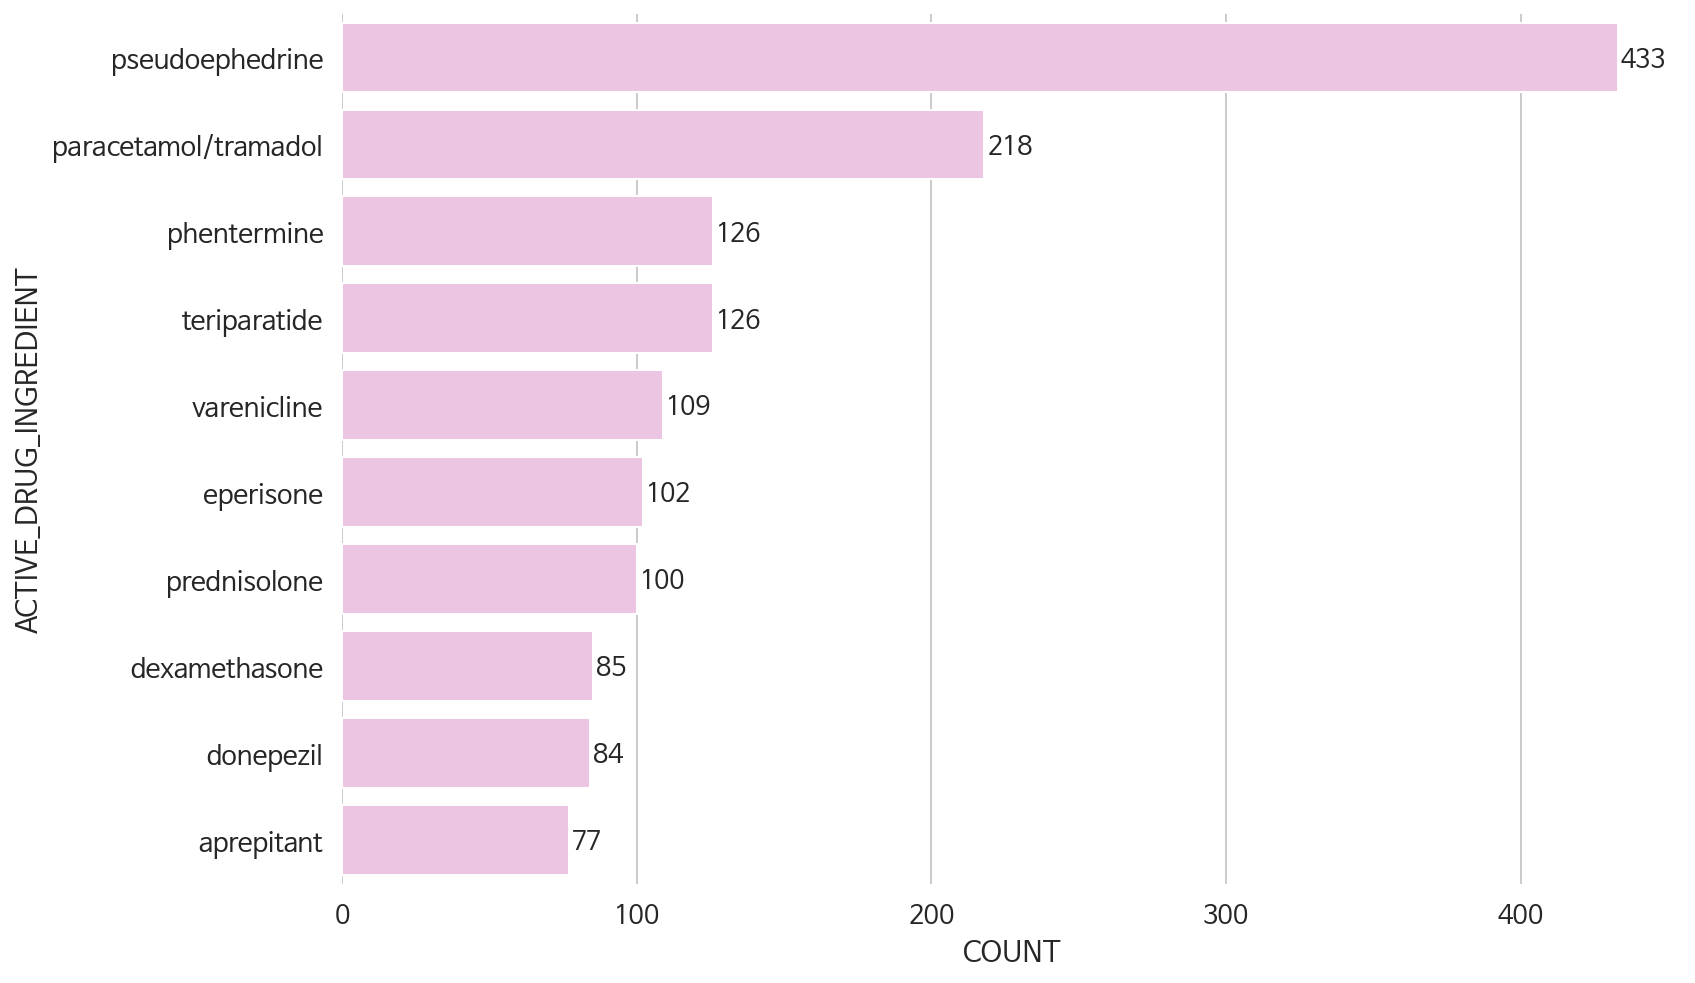

In [ ]:
barchart(data=ins_id_susp['suspected_drug'].value_counts()[:10].to_frame().reset_index().rename(columns={'suspected_drug':'COUNT','index':'ACTIVE_DRUG_INGREDIENT'}),
         x='COUNT',
         y='ACTIVE_DRUG_INGREDIENT',
         figsize=(12, 8),
         color='#F2BFE7',
         vertical=False)

In [ ]:
def get_matrix(matrix, drug_list):
    result = pd.DataFrame()

    for drug in drug_list:
        drugs = drug.split('/')
        for d in drugs:
            result = result.append(matrix[matrix['Drug']==d])

    return result

ins_matrix = pd.read_csv('Insomnia_count_matrix.csv')
    
print('의심약물 순위')
display(get_matrix(ins_matrix, list(ins_id_susp['suspected_drug'].value_counts()[:10].index)))

print('의심+병용약물 순위')
display(get_matrix(ins_matrix, list(ins_id_drug['ACTIVE_DRUG_INGREDIENT'].value_counts()[:10].index)))

의심약물 순위


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
0,pseudoephedrine,Insomnia,1295,6495,5686,627790
35,paracetamol,Insomnia,1401,6389,39403,594073
34,tramadol,Insomnia,703,7087,69010,564466
11,phentermine,Insomnia,163,7627,375,633101
86,teriparatide,Insomnia,127,7663,4392,629084
109,varenicline,Insomnia,117,7673,555,632921
65,eperisone,Insomnia,656,7134,6203,627273
61,prednisolone,Insomnia,451,7339,6000,627476
45,dexamethasone,Insomnia,366,7424,7588,625888
188,donepezil,Insomnia,128,7662,2063,631413


의심+병용약물 순위


,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
35,paracetamol,Insomnia,1401,6389,39403,594073
0,pseudoephedrine,Insomnia,1295,6495,5686,627790
34,tramadol,Insomnia,703,7087,69010,564466
82,mosapride,Insomnia,674,7116,9205,624271
65,eperisone,Insomnia,656,7134,6203,627273
145,erdosteine,Insomnia,518,7272,5521,627955
5,rebamipide,Insomnia,505,7285,7657,625819
61,prednisolone,Insomnia,451,7339,6000,627476
29,zolpidem,Insomnia,437,7353,3821,629655
253,methylprednisolone,Insomnia,429,7361,4790,628686


In [ ]:
def divide_age_group(x):
    if 0 <= x < 10:
        return '0-9'
    elif 10 <= x < 20:
        return '10-19'
    elif 20 <= x < 30:
        return '20-29'
    elif 30 <= x < 40:
        return '30-39'
    elif 40 <= x < 50:
        return '40-49'
    elif 50 <= x < 60:
        return '50-59'
    elif 60 <= x < 70:
        return '60-69'
    elif 70 <= x < 80:
        return '70-79'
    elif 80 <= x < 90:
        return '80-89'
    else:
        return '90-'
    
ins_age = df_ins[['KD_NO','MaxAgeAtVisit']].drop_duplicates().reset_index(drop=True)
ins_age['age_group'] = ins_age['MaxAgeAtVisit'].apply(divide_age_group)

ins_id_susp['KD_NO'] = ins_id_susp['KD_NO'].astype(str)
ins_id_susp_age = pd.merge(ins_id_susp, ins_age, on='KD_NO', how='left')
ins_id_susp_age.drop('MaxAgeAtVisit', axis=1, inplace=True)
ins_id_susp_age

,KD_NO,suspected_drug,age_group
0,32552,pseudoephedrine,60-69
1,100962,fluorouracil/irinotecan/oxaliplatin,50-59
2,304719,pregabalin,50-59
3,499822,theobromine,70-79
4,855215,phentermine,50-59
...,...,...,...
7785,1258262752,eperisone/paracetamol,50-59
7786,1258496197,amoxicillin/beta-lactamase inhibitor/methylpre...,60-69
7787,1259028360,alverine/ciclopirox/itopride/phloroglucinol/ra...,40-49
7788,1259037596,eperisone,70-79


In [ ]:
ins_susp_age_pivot = pd.pivot_table(ins_id_susp_age[ins_id_susp_age['suspected_drug'].isin(ins_id_susp['suspected_drug'].value_counts()[:10].index.to_list())],
                                    index='suspected_drug',
                                    columns='age_group',
                                    values='KD_NO',
                                    aggfunc='count',
                                    fill_value=0)
ins_susp_age_pivot

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
suspected_drug,,,,,,,,,,
aprepitant,0,0,0,3,16,20,22,14,2,0
dexamethasone,1,1,1,9,13,23,29,6,2,0
donepezil,0,0,0,0,0,8,14,36,25,1
eperisone,0,0,0,2,10,35,25,23,7,0
paracetamol/tramadol,0,2,2,9,21,44,81,45,14,0
phentermine,0,2,18,31,40,19,15,1,0,0
prednisolone,2,1,2,11,13,23,24,20,4,0
pseudoephedrine,5,7,11,38,67,107,121,58,19,0
teriparatide,0,0,0,2,2,18,33,39,31,1


In [ ]:
# 약물 기준
ins_susp_age_pivot.style.background_gradient(cmap='Blues', axis=1)

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
suspected_drug,,,,,,,,,,
aprepitant,0,0,0,3,16,20,22,14,2,0
dexamethasone,1,1,1,9,13,23,29,6,2,0
donepezil,0,0,0,0,0,8,14,36,25,1
eperisone,0,0,0,2,10,35,25,23,7,0
paracetamol/tramadol,0,2,2,9,21,44,81,45,14,0
phentermine,0,2,18,31,40,19,15,1,0,0
prednisolone,2,1,2,11,13,23,24,20,4,0
pseudoephedrine,5,7,11,38,67,107,121,58,19,0
teriparatide,0,0,0,2,2,18,33,39,31,1


In [ ]:
# 나이 기준
ins_susp_age_pivot.style.background_gradient(cmap='Blues', axis=0)

age_group,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-
suspected_drug,,,,,,,,,,
aprepitant,0,0,0,3,16,20,22,14,2,0
dexamethasone,1,1,1,9,13,23,29,6,2,0
donepezil,0,0,0,0,0,8,14,36,25,1
eperisone,0,0,0,2,10,35,25,23,7,0
paracetamol/tramadol,0,2,2,9,21,44,81,45,14,0
phentermine,0,2,18,31,40,19,15,1,0,0
prednisolone,2,1,2,11,13,23,24,20,4,0
pseudoephedrine,5,7,11,38,67,107,121,58,19,0
teriparatide,0,0,0,2,2,18,33,39,31,1


In [ ]:
ins_gender = df_ins[['KD_NO','other_covariates(PatientSex_1=male_2=female)']].drop_duplicates().reset_index(drop=True)
ins_gender.columns = ['KD_NO', 'patient_sex']
ins_gender['patient_sex'] = ins_gender['patient_sex'].astype(str)
ins_gender['patient_sex'] = ins_gender['patient_sex'].apply(lambda x: 'Male' if x == '1' else 'Female')

ins_id_susp['KD_NO'] = ins_id_susp['KD_NO'].astype(str)
ins_id_susp_gen = pd.merge(ins_id_susp, ins_gender, on='KD_NO', how='left')
ins_id_susp_gen

,KD_NO,suspected_drug,patient_sex
0,32552,pseudoephedrine,Male
1,100962,fluorouracil/irinotecan/oxaliplatin,Female
2,304719,pregabalin,Female
3,499822,theobromine,Female
4,855215,phentermine,Female
...,...,...,...
7785,1258262752,eperisone/paracetamol,Female
7786,1258496197,amoxicillin/beta-lactamase inhibitor/methylpre...,Female
7787,1259028360,alverine/ciclopirox/itopride/phloroglucinol/ra...,Male
7788,1259037596,eperisone,Male


In [ ]:
ins_susp_gen_pivot = pd.pivot_table(ins_id_susp_gen[ins_id_susp_gen['suspected_drug'].isin(ins_id_susp['suspected_drug'].value_counts()[:10].index.to_list())],
                                    index='suspected_drug',
                                    columns='patient_sex',
                                    values='KD_NO',
                                    aggfunc='count')
ins_susp_gen_pivot

patient_sex,Female,Male
suspected_drug,,
aprepitant,45,32
dexamethasone,49,36
donepezil,50,34
eperisone,66,36
paracetamol/tramadol,147,71
phentermine,116,10
prednisolone,70,30
pseudoephedrine,355,78
teriparatide,105,21


In [ ]:
# 약물 기준
ins_susp_gen_pivot.style.background_gradient(cmap='Greens', axis=1)

patient_sex,Female,Male
suspected_drug,,
aprepitant,45,32
dexamethasone,49,36
donepezil,50,34
eperisone,66,36
paracetamol/tramadol,147,71
phentermine,116,10
prednisolone,70,30
pseudoephedrine,355,78
teriparatide,105,21


In [ ]:
# 성별 기준
ins_susp_gen_pivot.style.background_gradient(cmap='Greens', axis=0)

patient_sex,Female,Male
suspected_drug,,
aprepitant,45,32
dexamethasone,49,36
donepezil,50,34
eperisone,66,36
paracetamol/tramadol,147,71
phentermine,116,10
prednisolone,70,30
pseudoephedrine,355,78
teriparatide,105,21


In [ ]:
ins_matrix = pd.read_csv('Insomnia_count_matrix.csv')
ins_matrix[ins_matrix['Drug']=='varenicline']

,Drug,Phenotype,d_Y_p_Y,d_N_p_Y,d_Y_p_N,d_N_p_N
109,varenicline,Insomnia,117,7673,555,632921


#### 의심약물 ATC 분포 확인

In [ ]:
ins_susp_drug = df_ins[df_ins['DOUBT_CMBT_CSF']=='1'][['ACTIVE_DRUG_INGREDIENT','WHO_ATC_CD']].drop_duplicates().reset_index(drop=True)
ins_susp_drug

,ACTIVE_DRUG_INGREDIENT,WHO_ATC_CD
0,pseudoephedrine,R01BA52
1,fluorouracil,L01BC02
2,oxaliplatin,L01XA03
3,irinotecan,L01XX19
4,pregabalin,N03AX16
...,...,...
832,testosterone,G03BA03
833,midodrine,C01CA17
834,golimumab,L04AB06
835,clindamycin,D10AF01


In [ ]:
ins_susp_drug.nunique()

ACTIVE_DRUG_INGREDIENT    664
WHO_ATC_CD                749
1                          14
2                          12
3                          13
4                          16
5                          43
dtype: int64

In [ ]:
ins_susp_drug['1'] = ins_susp_drug['WHO_ATC_CD'].apply(lambda x: x[0])
ins_susp_drug['2'] = ins_susp_drug['WHO_ATC_CD'].apply(lambda x: x[1:3])
ins_susp_drug['3'] = ins_susp_drug['WHO_ATC_CD'].apply(lambda x: x[3] if len(x) > 3 else np.NaN)
ins_susp_drug['4'] = ins_susp_drug['WHO_ATC_CD'].apply(lambda x: x[4] if len(x) > 4 else np.NaN)
ins_susp_drug['5'] = ins_susp_drug['WHO_ATC_CD'].apply(lambda x: x[5:] if len(x) > 5 else np.NaN)

ins_susp_drug_atc1 = ins_susp_drug.groupby('1').count()
ins_susp_drug_atc1['Percent'] = ins_susp_drug_atc1['ACTIVE_DRUG_INGREDIENT'].apply(lambda x: x/837*100)
ins_susp_drug_atc1 = ins_susp_drug_atc1[['ACTIVE_DRUG_INGREDIENT','Percent']].reset_index()\
        .rename(columns={'1':'ATC Class','ACTIVE_DRUG_INGREDIENT':'ACTIVE_DRUG_INGREDIENT Count'})

ins_susp_drug_atc1['color'] = sns.color_palette('Pastel1')[:8] + sns.color_palette('Pastel2')[:6]
ins_susp_drug_atc1 = ins_susp_drug_atc1.sort_values(by='Percent', ascending=False).reset_index(drop=True)
ins_susp_drug_atc1

,ATC Class,ACTIVE_DRUG_INGREDIENT Count,Percent,color
0,A,122,14.575866,"(0.984313725490196, 0.7058823529411765, 0.6823..."
1,C,117,13.978495,"(0.8, 0.9215686274509803, 0.7725490196078432)"
2,N,115,13.739546,"(0.9921568627450981, 0.803921568627451, 0.6745..."
3,J,111,13.261649,"(0.8980392156862745, 0.8470588235294118, 0.741..."
4,L,91,10.872162,"(0.9921568627450981, 0.8549019607843137, 0.925..."
5,R,88,10.513740,"(0.9568627450980393, 0.792156862745098, 0.8941..."
6,M,46,5.495818,"(0.7019607843137254, 0.8862745098039215, 0.803..."
7,G,40,4.778973,"(0.996078431372549, 0.8509803921568627, 0.6509..."
8,B,29,3.464755,"(0.7019607843137254, 0.803921568627451, 0.8901..."
9,D,29,3.464755,"(0.8705882352941177, 0.796078431372549, 0.8941..."


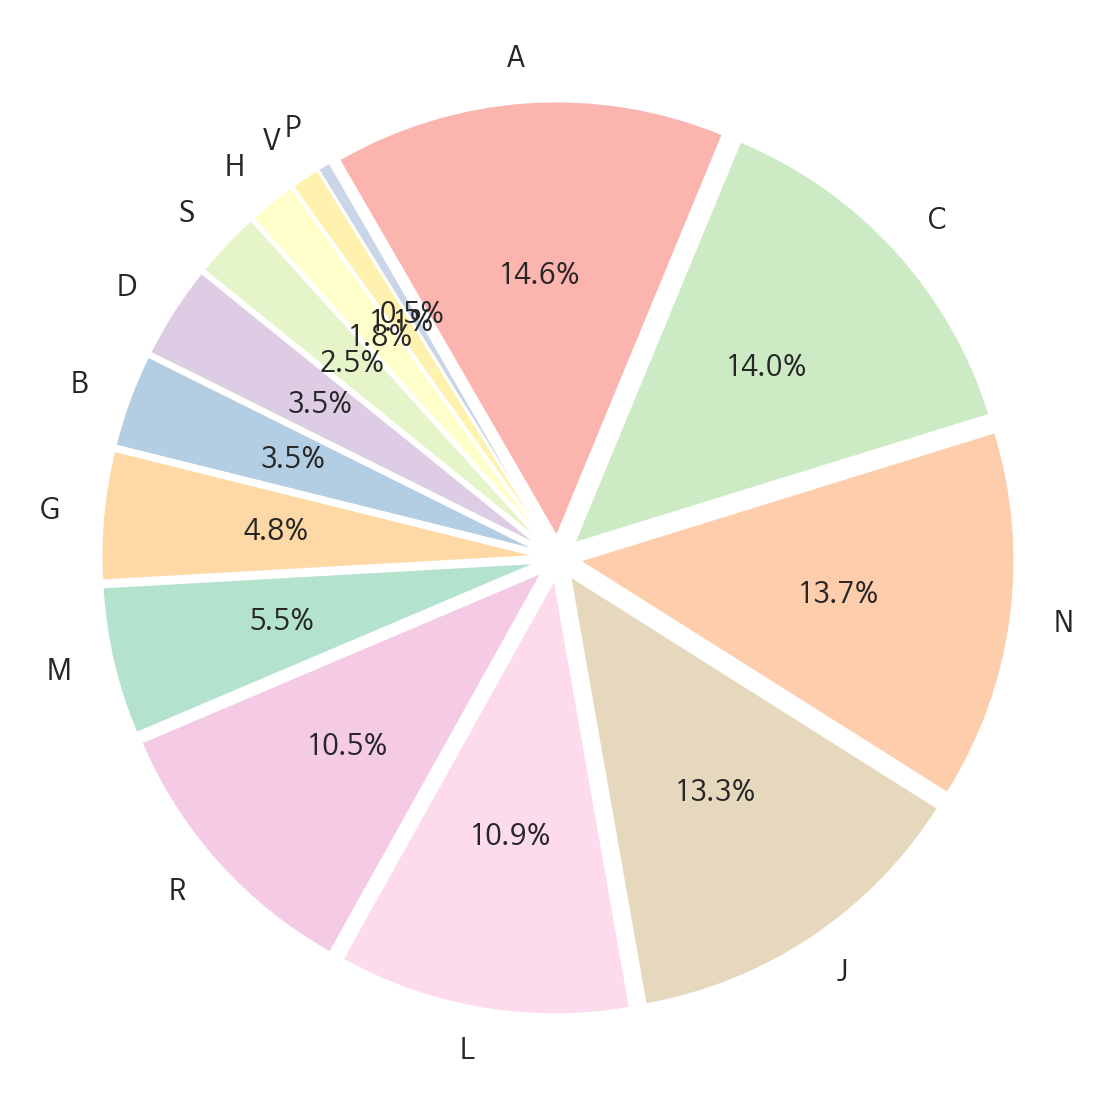

In [ ]:
data = ins_susp_drug_atc1['Percent'].to_list()
labels = ins_susp_drug_atc1['ATC Class'].to_list()
explode = [0.05] * 14
colors = ins_susp_drug_atc1['color'].to_list()
plt.figure(figsize=(10,10))
plt.pie(data, labels = labels, colors = colors, autopct='%.1f%%', textprops={'fontsize': 14},
        explode=explode, startangle=120, counterclock=False)
plt.show()

In [ ]:
isa1 = ins_susp_drug_atc1[['ATC Class','ACTIVE_DRUG_INGREDIENT Count']]
isa1.columns = ['ATC Class','Neu Count']

aa1 = all_drug_atc1[['ATC Class','ACTIVE_DRUG_INGREDIENT Count']]
aa1.columns = ['ATC Class','All Count']

isaa1 = pd.merge(isa1, aa1, on='ATC Class', how='inner')
isaa1['Percent of All'] = ''

for i in range(14):
    isaa1.iloc[i, 3] = round(isaa1.iloc[i, 1] / isaa1.iloc[i, 2] * 100, 1)
    
isaa1['color'] = ins_susp_drug_atc1['color']
isaa1

,ATC Class,Neu Count,All Count,Percent of All,color
0,A,122,277,44.0,"(0.984313725490196, 0.7058823529411765, 0.6823..."
1,C,117,208,56.2,"(0.8, 0.9215686274509803, 0.7725490196078432)"
2,N,115,204,56.4,"(0.9921568627450981, 0.803921568627451, 0.6745..."
3,J,111,277,40.1,"(0.8980392156862745, 0.8470588235294118, 0.741..."
4,L,91,198,46.0,"(0.9921568627450981, 0.8549019607843137, 0.925..."
5,R,88,143,61.5,"(0.9568627450980393, 0.792156862745098, 0.8941..."
6,M,46,91,50.5,"(0.7019607843137254, 0.8862745098039215, 0.803..."
7,G,40,93,43.0,"(0.996078431372549, 0.8509803921568627, 0.6509..."
8,B,29,112,25.9,"(0.7019607843137254, 0.803921568627451, 0.8901..."
9,D,29,105,27.6,"(0.8705882352941177, 0.796078431372549, 0.8941..."


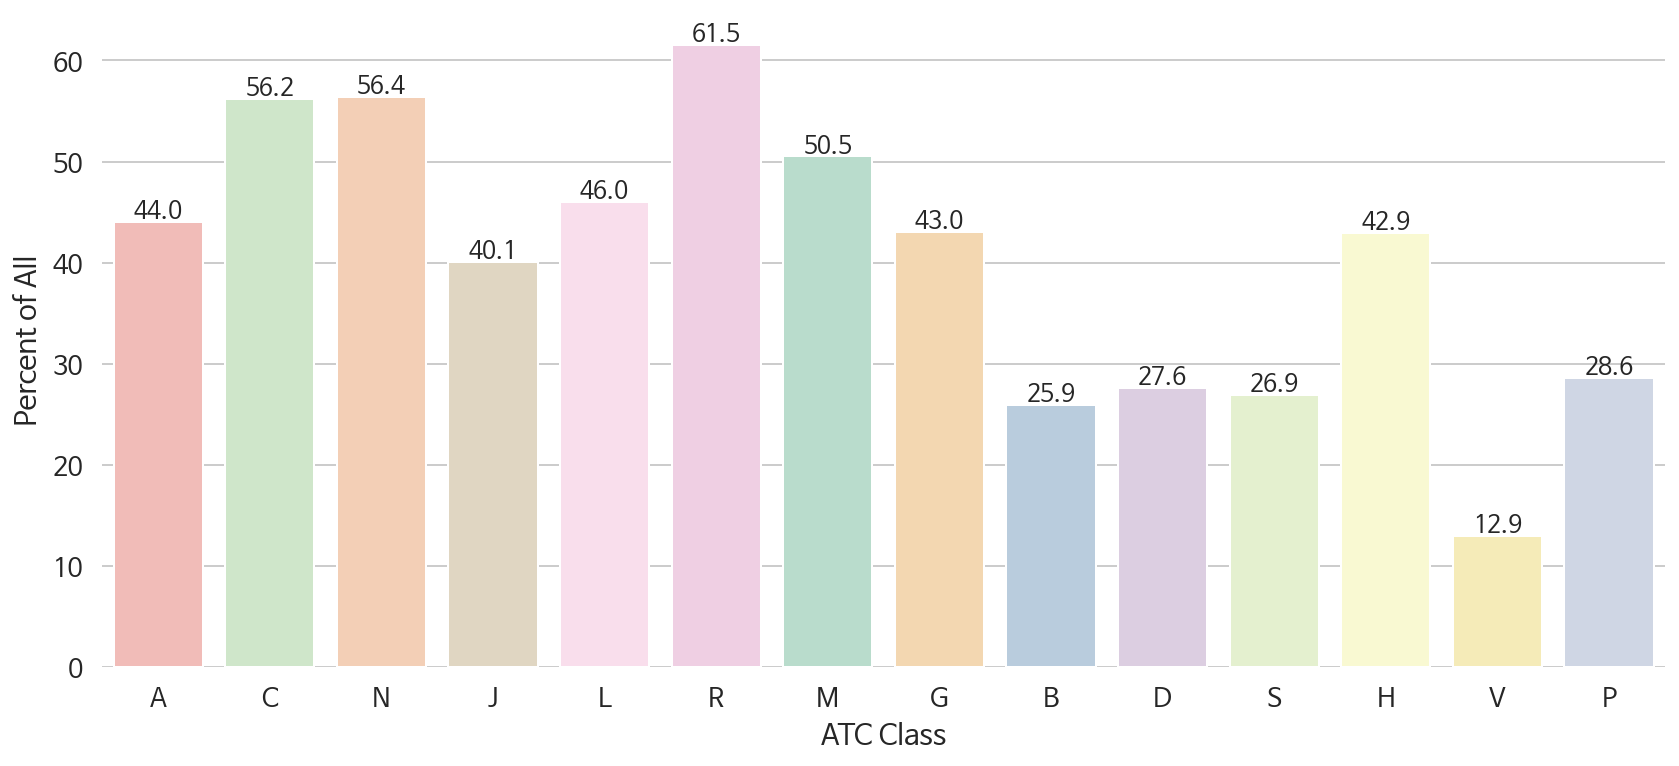

In [ ]:
barchart(data=isaa1,
         x='ATC Class',
         y='Percent of All',
         figsize=(14, 6),
         palette=list(isaa1['color']),
         margin=0.4,
         vertical=True,
         ratio=True)

#### 필터링
1. 해당 약물을 보고한 사람들 중 Neutropenia 부작용을 보고한 사람 비율 20% 이상

In [ ]:
# rate = 20 
filter_outlier_drug_ins = filtering(list(ins_id_drug['ACTIVE_DRUG_INGREDIENT'].unique()), 'Insomnia')
len(filter_outlier_drug_ins)

100%|██████████| 870/870 [05:46<00:00,  2.51it/s]


22

In [ ]:
# rate = 15
filter_outlier_drug_ins = filtering(list(ins_id_drug['ACTIVE_DRUG_INGREDIENT'].unique()), 'Insomnia', rate=15)
len(filter_outlier_drug_ins)

100%|██████████| 870/870 [05:53<00:00,  2.46it/s]


38

In [ ]:
drug = 'bambuterol'
print(df_ins[(df_ins['ACTIVE_DRUG_INGREDIENT']==drug)]['DOUBT_CMBT_CSF'].value_counts())
print('의심약물 KD_NO 건수 :', df_ins[(df_ins['ACTIVE_DRUG_INGREDIENT']==drug) & (df_ins['DOUBT_CMBT_CSF']=='1')]['KD_NO'].nunique())
print('병용약물 KD_NO 건수 :', df_ins[(df_ins['ACTIVE_DRUG_INGREDIENT']==drug) & (df_ins['DOUBT_CMBT_CSF']=='2')]['KD_NO'].nunique())
display(df_ins[(df_ins['ACTIVE_DRUG_INGREDIENT']==drug)])

1    80
2     8
Name: DOUBT_CMBT_CSF, dtype: int64
의심약물 KD_NO 건수 : 40
병용약물 KD_NO 건수 : 4


,KD_NO,adr_seq,WHOART_ARRN,WHOART_SEQ,ICD10_code,ICD9CM_code,ICD10CM_code,drug_seq,DRUG_CHEM,WHO_ATC_CD,DSAS_CD,dsas_cd_ver,ACTIVE_DRUG_INGREDIENT,Phenotype,DOUBT_CMBT_CSF,ICD10CM_code,response,MaxAgeAtVisit,other_covariates(PatientSex_1=male_2=female)
3623,38243544,1,183,1.0,nan,780.52,G47.0,1,bambuterol,R03CC12,J44.9,7.0,bambuterol,Insomnia,1,G47.0,0,74,1
3624,38243544,1,183,1.0,nan,780.52,G47.00,1,bambuterol,R03CC12,J44.9,7.0,bambuterol,Insomnia,1,G47.00,0,74,1
6469,57851565,2,183,1.0,nan,780.52,G47.0,13,bambuterol,R03CC12,J42,7.0,bambuterol,Insomnia,2,G47.0,1,70,1
6470,57851565,2,183,1.0,nan,780.52,G47.00,13,bambuterol,R03CC12,J42,7.0,bambuterol,Insomnia,2,G47.00,1,70,1
14145,96039812,1,183,1.0,nan,780.52,G47.0,2,bambuterol,R03CC12,J20.9,7.0,bambuterol,Insomnia,1,G47.0,0,43,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71611,1019359634,2,183,4.0,nan,780.52,G47.00,4,bambuterol,R03CC12,NaN,NaN,bambuterol,Insomnia,1,G47.00,1,57,2
72291,1092432216,1,183,4.0,nan,780.52,G47.0,3,bambuterol,R03CC12,NaN,NaN,bambuterol,Insomnia,1,G47.0,0,26,1
72292,1092432216,1,183,4.0,nan,780.52,G47.00,3,bambuterol,R03CC12,NaN,NaN,bambuterol,Insomnia,1,G47.00,0,26,1
72811,1228171154,2,183,4.0,nan,780.52,G47.0,3,bambuterol,R03CC12,NaN,NaN,bambuterol,Insomnia,1,G47.0,1,56,2


In [ ]:
filter_outlier_drug_ins = dict(sorted(filter_outlier_drug_ins.items(), key=lambda x: x[1], reverse=True))
filter_outlier_drug_ins

{'molindone': 100,
 'bromperidol': 100,
 'etifoxine': 50,
 'liquid paraffin': 50,
 'azelaic acid': 50,
 'citalopram': 33,
 'estrone': 33,
 'phentermine': 30,
 'amoxapine': 26,
 'senna glycosides': 25,
 'terbutaline': 25,
 'zotepine': 25,
 'orlistat': 22,
 'mefloquine': 22,
 'flunitrazepam': 21,
 'amfepramone': 21,
 'aminophylline': 20,
 'bambuterol': 20,
 'sisomicin': 20,
 'nalfurafine': 20,
 'toremifene': 20,
 'proguanil': 20,
 'pseudoephedrine': 19,
 'Hyperici herba': 19,
 'varenicline': 17,
 'flurazepam': 17,
 'glycerol': 17,
 'ziprasidone': 17,
 'butenafine': 17,
 'oxatomide': 17,
 'homatropine': 17,
 'xipamide': 17,
 'neltenexine': 17,
 'niraparib': 17,
 'diphenhydramine': 17,
 'bromazepam': 15,
 'fluoxetine': 15,
 'argatroban': 15}

In [ ]:
phenotype = 'Insomnia'

for d in filter_outlier_drug_ins:
    print(d)
    reports_by_drug_taking(d, phenotype)
    print()

molindone
molindone 복용한 사람 수 : 1
molindone 복용하지 않은 사람 수 : 641265
Insomnia 보고한 사람 수 : 7790
Insomnia 보고하지 않은 사람 수 : 633476

약물 molindone 복용하고 Insomnia 부작용을 보고한 KD_NO 개수
1
( molindone 복용한 사람들 중 100.0 % ) | ( Insomnia 부작용 보고한 사람들 중 0.01 % )

약물 molindone 복용하지 않고 Insomnia 부작용을 보고한 KD_NO 개수
7789
( molindone 복용하지 않은 사람들 중 1.2 % ) | ( Insomnia 부작용 보고한 사람들 중 99.99 % )

약물 molindone 복용하고 다른 부작용을 보고한 KD_NO 개수
0
( molindone 복용한 사람들 중 0.0 % ) | ( 부작용 보고하지 않은 사람들 중 0.0 % )

약물 molindone 복용하지 않고 다른 부작용을 보고한 KD_NO 개수
633476
( molindone 복용하지 않은 사람들 중 98.8 % ) | ( 부작용 보고하지 않은 사람들 중 100.0 % )

bromperidol
bromperidol 복용한 사람 수 : 1
bromperidol 복용하지 않은 사람 수 : 641265
Insomnia 보고한 사람 수 : 7790
Insomnia 보고하지 않은 사람 수 : 633476

약물 bromperidol 복용하고 Insomnia 부작용을 보고한 KD_NO 개수
1
( bromperidol 복용한 사람들 중 100.0 % ) | ( Insomnia 부작용 보고한 사람들 중 0.01 % )

약물 bromperidol 복용하지 않고 Insomnia 부작용을 보고한 KD_NO 개수
7789
( bromperidol 복용하지 않은 사람들 중 1.2 % ) | ( Insomnia 부작용 보고한 사람들 중 99.99 % )

약물 bromperidol 복용하고 다른 부작용을 보고한 KD_NO 개수
